In [2]:
import ROOT                                                                                                             
import uproot                                                                                                           
import uproot.behaviors.TGraph                                                                                          
import uproot3                                                                                                          
import os                                                                                                               
import csv                                                                                                              
import pandas as pd                                                                                                     
import numpy as np                                                                                                      
import multiprocessing as mp                                                                                            
import awkward as ak                                                                                                    
import matplotlib.pyplot as plt  
import matplotlib 
import seaborn as sns                                                                                                   
from tools.binnings_collection import get_nbins_in_range, get_sub_binning, get_bin_center, compute_dayfromtime          
from tools.binnings_collection import mass_binning, fbinning_energy, LithiumRigidityBinningFullRange, Rigidity_Analysis_Binning_FullRange                                                                                                      
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar_v2, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, FONTSIZE_BIG, FONTSIZE_MID, plot1d_errorbar, plot1d_step, set_plot_defaultstyle                                                                                                                  
from tools.calculator import calc_rig_from_ekin, calc_ratio_err, calc_ekin_from_beta, calc_mass                         
from tools.constants import ISOTOPES_MASS, NUCLEI_CHARGE, NUCLEIS ,  ISOTOPES_COLOR, ISO_LABELS, DETECTOR_LABEL, DETECTOR_COLOR                                              
from tools.histograms import Histogram, plot_histogram_2d                                                               
from tools.binnings import Binning                                                                                      
from tools.roottree import read_tree                                                                                    
from tools.selections import *                                                                                          
import pickle                                                                                                           
from tools.graphs import MGraph, slice_graph, plot_graph, slice_graph_by_value
from scipy.optimize import curve_fit
from tools.massfit_tools import get_fitpdf_witherr, get_fitpdferrorband
from tools.functions import poly, upoly
from tools.jupytertools import *

Welcome to JupyROOT 6.26/10


/home/manbing/.local/lib/python3.10/site-packages/awkward0/__init__.py:8: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(numpy.__version__) < distutils.version.LooseVersion("1.13.1"):


In [3]:
figsize1 = (21, 25)
fontsize1 = 45
fontsize2 = 55
mksize = 20

In [4]:
tick_length = 14                                                                                         
tick_width=1.5                                                                                           
tick_labelsize = 40                                                                                      
legendfontsize = 45   
      

In [5]:
nuclei = 'Be'                                                                                               
detectors = ["Tof", "NaF", "Agl"]        
#detectors = ["Tof", "NaF", "Agl"]                                                                                   
detectors_alias = {"Tof": "tof", "Agl":"agl", "NaF": "naf"}                                                         
variable = 'Ekin'                                                                                          
massbinning = Binning(mass_binning())                                                                               
inverse_mass_binning = Binning(np.linspace(0.05, 0.3, 100))     
plotfile = '/home/manbing/Documents/lithiumanalysis/slides/plots/GetTemplateParsRange'

In [6]:
polyfitp0 = {dec: {} for dec in detectors}    
parnames = ["mean",  "sigma", "fraccore", "sigma_ratio", "asy_factor"]      
polyfitp0["Agl"] = {"mean": [0.15, 0.0, 0.0], "sigma":[0.016, 0.0, 0.0, 0.001], 'sigma_ratio': [1.5, 0.1, 0.1], 'asy_factor':[1.1, 0.1, 0.001], 'fraccore': [0.8, 0.01 , 0.01]}                                                 
polyfitp0["NaF"] = {"mean": [0.15, 0.0, 0.0], "sigma":[0.016, 0.0, 0.0], 'sigma_ratio': [1.5], 'asy_factor':[1.1], 'fraccore': [0.75]}                                                                             
polyfitp0["Tof"] = {"mean": [0.15, 0.0, 0.0], "sigma":[0.016, 0.001, 0.001], 'sigma_ratio': [1.2, 0.001, 0.001], 'asy_factor':[1.4, 0.01, 0.001], 'fraccore': [0.823]}  
ylim_range_be7 = {'mean'  :     [0.145, 0.16], 'sigma' : [0.012, 0.022], 'sigma_ratio':[1.6, 2.0], 'asy_factor': [0.8, 1.3], 'fraccore':   [0.7, 1.0], "norm":       [0, 40]} 

par_names_axes = {'mean': '$\mathrm{\mu}$',                                                                                                                                                                        
                  'sigma': '$\mathrm{\sigma}$',                                                                                                                                                                
                  "sigma_ratio": '$\mathrm{ \epsilon(\sigma ratio)}$',                                                                                                                                             
                  "asy_factor":'asy_factor (a)',                                                                                                                                                                            
                  "fraccore":'$\mathrm{f_{core}}$',                                                                                                                                                                
                  'norm':'Norm'}       

def plot_parswitherr(fig, ax1, graph1, col, p0_mean, labelname=None):
    
    plot_graph(fig, ax1, graph1, color=col, style="EP", xlog=False, ylog=False, scale=None, markersize=mksize+5, label=labelname)
    popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0_mean)  
    ax1.plot(graph1.xvalues, poly(np.log(graph1.xvalues), *popt), "-",  label='fit', color=col)
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    mufit_lower, mufit_upper = get_fitpdferrorband(np.log(graph1.xvalues), polypars, upoly)  
    ax1.fill_between(graph1.xvalues, mufit_lower, mufit_upper, color=col, alpha=0.2) 
    ax1.legend(fontsize=40)

In [7]:
from tools.constants import ISOTOPES_MASS
from tools.massfit_tools import get_fitpdferrorband
import uncertainties                                                                                                                                                                                               
from uncertainties import unumpy                                                                                                                                                                                   
from uncertainties import ufloat    

def plot_parswitherr(fig, ax1, graph_mean, col, p0_mean, labelname=None):
    plot_graph(fig, ax1, graph_mean, color=col, style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=labelname)
    popt, pcov = curve_fit(poly, np.log(graph_mean.xvalues), graph_mean.yvalues, p0 = p0_mean)  
    ax1.plot(graph_mean.xvalues, poly(np.log(graph_mean.xvalues), *popt), "-", color=col)
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    mufit_lower, mufit_upper = get_fitpdferrorband(np.log(graph_mean.xvalues), polypars, upoly)  
    ax1.fill_between(graph_mean.xvalues, mufit_lower, mufit_upper, color=col, alpha=0.2)   
    
    

filepathU = {'Tof':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCUnTuned_Rebin/',
             'NaF': '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedLow_Rebin/',
             'Agl':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedLow_Rebin/'}

filepathT = {'Tof':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin/',
             'NaF': '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedUp_Rebin/',
             'Agl':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedUp_Rebin/'}

#filepathT = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBetaExtLow_Rebin/'
#filepathU = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBetaExtUp_Rebin/'
itername = 'iter0'

graph_meanU = {}
graph_sigmaU = {}

graph_meanT = {}
graph_sigmaT = {}
graph_parsUntuned = {dec: {} for dec in detectors}
graph_parsTuned = {dec: {} for dec in detectors}

decs = {'Tof', 'NaF', 'Agl'}
for dec in decs:
    file_mean = filepathU[dec] + f'df_mean_{itername}.npz'
    file_sigma = filepathU[dec] + f'df_sigma_{itername}.npz'
    file_mean2 = filepathT[dec] + f'df_mean_{itername}.npz'
    file_sigma2 = filepathT[dec] + f'df_sigma_{itername}.npz'

    df_mean = np.load(f'{file_mean}')
    df_sig = np.load(f'{file_sigma}')
    df_mean2 = np.load(f'{file_mean2}')
    df_sig2 = np.load(f'{file_sigma2}')
    
    graph_meanU[dec] = MGraph.from_file(df_mean, f'graph_mean_{dec}')
    graph_sigmaU[dec] = MGraph.from_file(df_sig, f'graph_sigma_{dec}')
    graph_meanT[dec] = MGraph.from_file(df_mean2, f'graph_mean_{dec}')
    graph_sigmaT[dec] = MGraph.from_file(df_sig2, f'graph_sigma_{dec}')
    
    graph_parsUntuned[dec]['mean'] =  graph_meanU[dec]
    graph_parsTuned[dec]['mean'] = graph_meanT[dec]
    graph_parsUntuned[dec]['sigma'] =  graph_sigmaU[dec]
    graph_parsTuned[dec]['sigma'] = graph_sigmaT[dec]

    
slicevalue_trueratio ={'Tof':[0.3, 1.2], 'NaF':[0.9, 6.0], 'Agl':[3.5, 12.0]}


fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(24, 18))    
xaxistext = {"Tof": 0.03, "NaF": 0.25, "Agl": 0.6}
p0_mean = {'Tof':[0.152, 0.1, 0.1], 'NaF':[0.152, 0.1, 0.1], "Agl":[0.152, 0.1, 0.1, 0.1]}
p0_sigma = {'Tof':[0.01, 0.01, 0.01], 'NaF':[0.01, 0.1, 0.1], "Agl":[0.01, 0.1, 0.1, 0.1]}

for dec in decs: 
    plot_parswitherr(fig, ax1, graph_meanU[dec], DETECTOR_COLOR[dec], p0_mean[dec])
    plot_parswitherr(fig, ax1, graph_meanT[dec], 'grey', p0_mean[dec])
    plot_parswitherr(fig, ax2, graph_sigmaU[dec], DETECTOR_COLOR[dec], p0_sigma[dec])
    plot_parswitherr(fig, ax2, graph_sigmaT[dec], 'grey', p0_sigma[dec])
    ax1.text(xaxistext[dec], 0.98,  f"{DETECTOR_LABEL[dec]}", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=DETECTOR_COLOR[dec], fontweight="bold")      
    
#ax1.text(0.5, 0.5,  f"", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='grey', fontweight="bold")      
set_plot_style(ax1) 
set_plot_style(ax2)  
equation_text = r'$\mathrm{\mu = p_{0} + p_{1} \cdot x + p_{2} \cdot x^{2} , x = \log(E)}$'
#ax1.text(0.03, 0.15, equation_text, fontsize=35, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black') 
equation_sig = r'$\mathrm{\sigma = p_{0} + p_{1} \cdot x + p_{2} \cdot x^{2} + (p_{3} \cdot x^{3}), x = \log(E)}$'
equation_sig = r'$\mathrm{\sigma = \sum_{i}p_{i}\cdot x^{i}, x = \log(E)}$'
#ax2.text(0.03, 0.18, equation_sig, fontsize=35, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color='black') 
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax1.set_xlabel("Ekin/n (GeV/n)") 

ax1.set_ylim([0.147, 0.155])
ax2.set_ylim([0.012, 0.022])
ax2.set_xlabel('Ekin/n (GeV/n)', fontsize=fontsize1)
ax1.set_ylabel(r'$\mathrm{\mu}$', fontsize=fontsize1)
ax2.set_ylabel(r'$\mathrm{\sigma}$', fontsize=fontsize1)
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=fontsize1)
ax2.legend(loc='lower right', fontsize=fontsize1)
ax2.set_xscale('log')
savefig_tofile(fig, plotfile, 'mean_sigma_iter0_All', 1)




FileNotFoundError: [Errno 2] No such file or directory: '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedLow_Rebin/df_mean_iter0.npz'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Agl sigma
/home/manbing/Documents/lithiumanalysis/slides/plots/GetTemplateParsRange


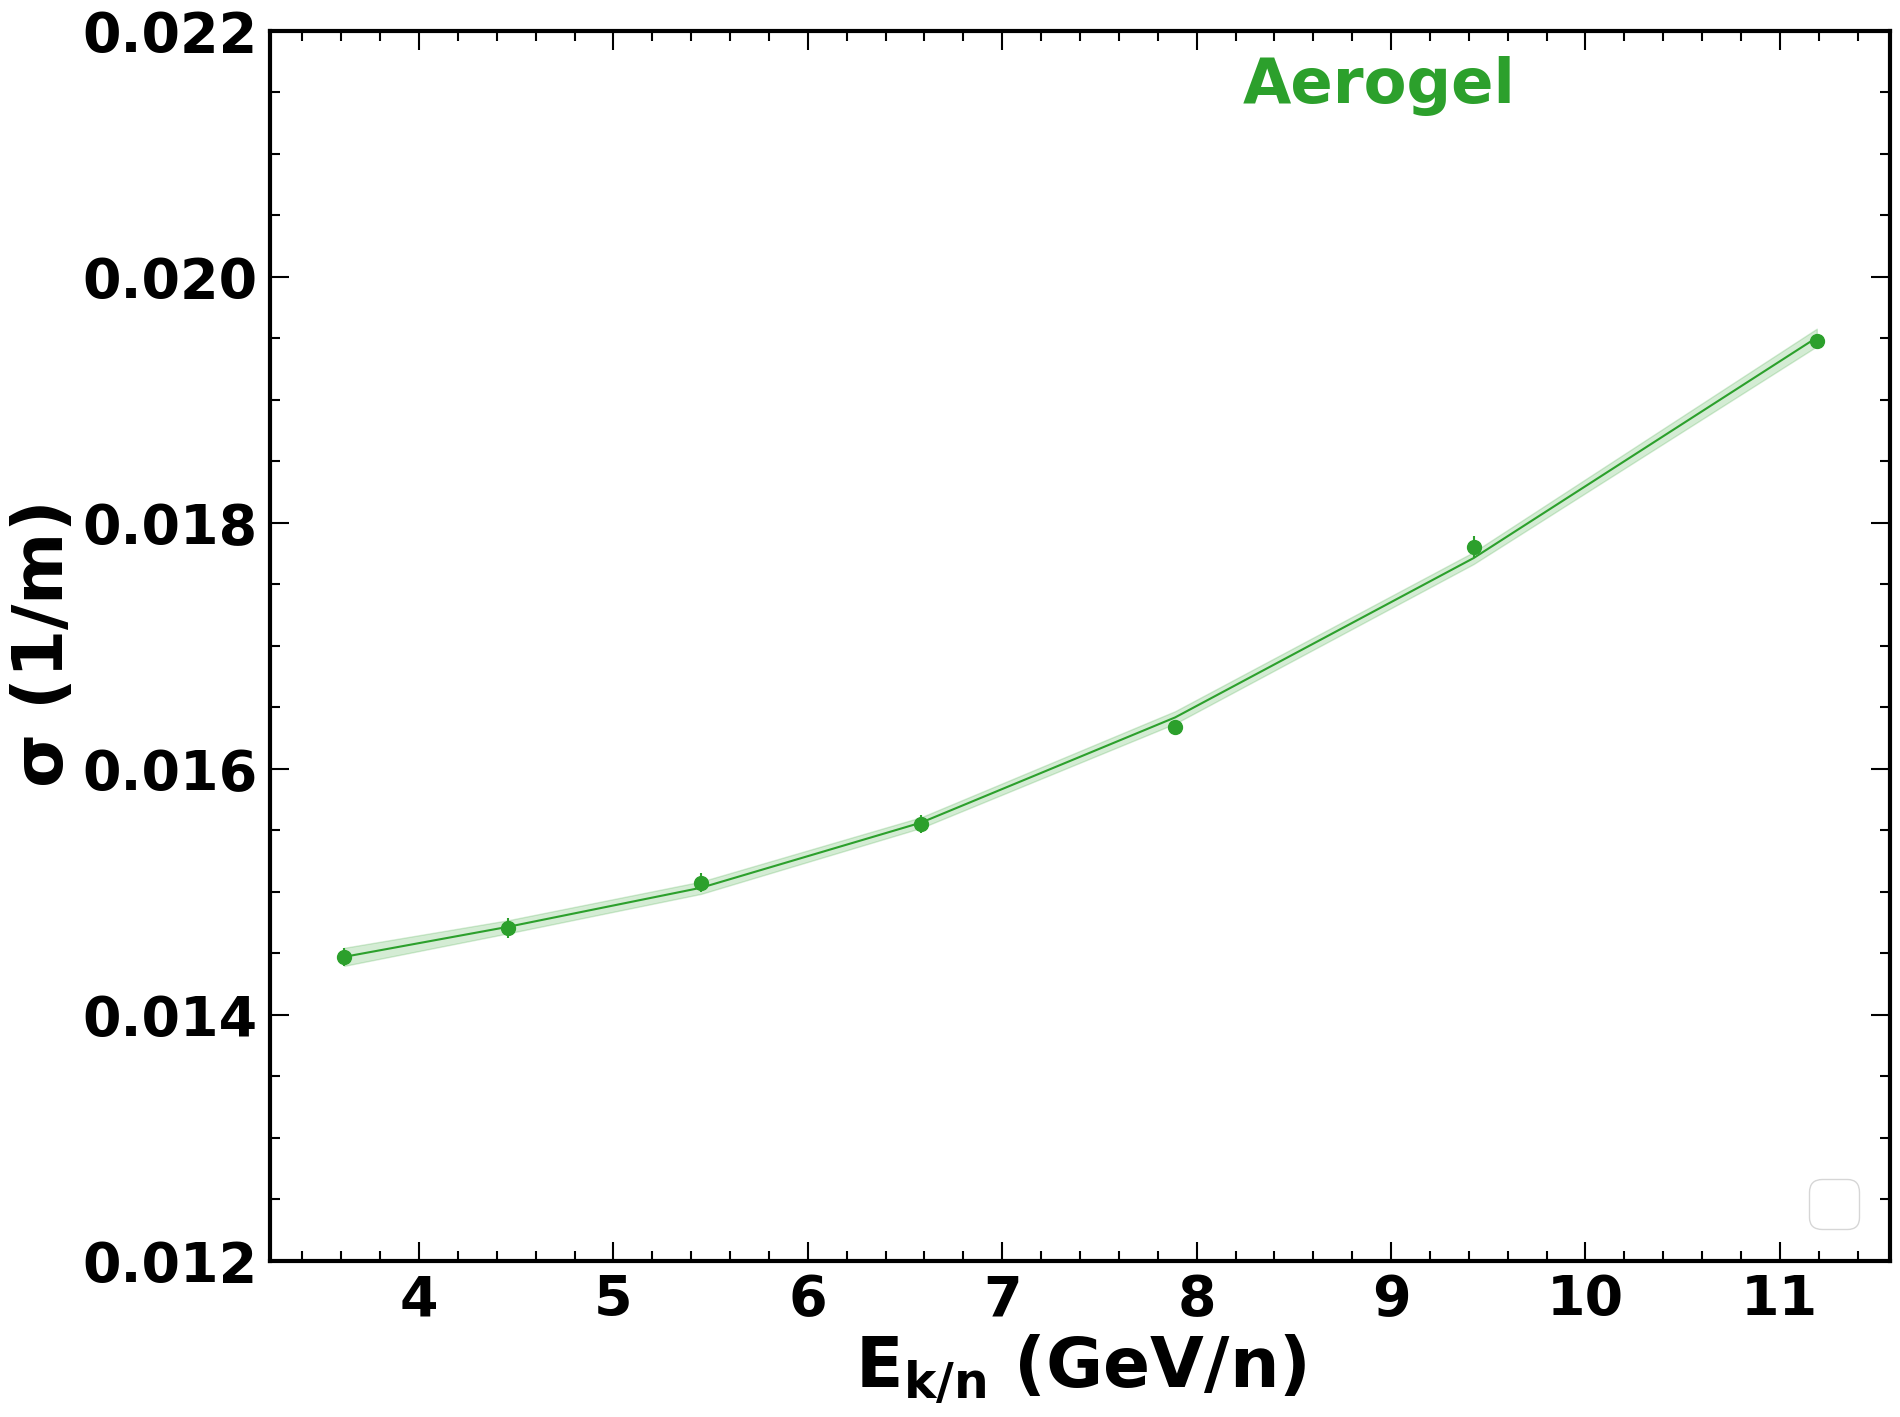

In [68]:
fig, ax1 = plt.subplots(1, 1, figsize=FIGSIZE2)  
fig.subplots_adjust(left= 0.16, right=0.97, bottom=0.13, top=0.95)
dec = 'Agl'
thispar = 'sigma'

filepathTuneMax = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedMax_Rebin'
df_sigma_maxscale = np.load(os.path.join(filepathTuneMax, f'df_sigma_{itername}.npz'))
graph_sigmaMaxScale = MGraph.from_file(df_sigma_maxscale, f'graph_sigma_{dec}')
#plot_graph(fig, ax1, graph_sigmaMaxScale, color='blue', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label='uncertainty MC')


#plot_parswitherr(fig, ax1, graph_sigmaU[dec], DETECTOR_COLOR[dec], p0_sigma[dec])
plot_parswitherr(fig, ax1, graph_sigmaT[dec], DETECTOR_COLOR[dec], p0_sigma[dec])
ax1.text(xaxistext[dec], 0.98,  f"{DETECTOR_LABEL[dec]}", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=DETECTOR_COLOR[dec], fontweight="bold")      
ax1.set_ylim([0.013, 0.02])
#graph_fitlow[dec][par], graph_fitup[dec][par] = plot_errband_constraint(fig, ax1, df_graph_parslim, graph_parsUntuned[dec][par], graph_parsTuned[dec][par],  DETECTOR_COLOR[dec], par, polyfitp0[dec][par])
#ax1.fill_between(graph_fitlow[dec][par].xvalues, graph_fitlow[dec][par].yvalues, graph_fitup[dec][par].yvalues , color=DETECTOR_COLOR[dec], alpha=0.3) 
#plt.subplots_adjust(hspace=.0)                                                                                                                                                                                                                                                                                                                                            
ax1.set_xlabel(r"$\mathrm{E_{k/n} \ (GeV/n)}$", fontsize=50)     
ax1.set_ylim(ylim_range_be7[thispar])
#ax1.set_xscale('log')
#ax1.legend(loc='lower right', fontsize=fontsize1)
ax1.set_ylabel(f'{par_names_axes[thispar]} (1/m)', fontsize=50)
print(dec, thispar)
set_plot_style(ax1)
print(plotfile)
#popt, pcov = curve_fit(p0_sigma[dec], np.log(graph_sigmaT[dec].xvalues),  graph_sigmaT[dec].yvalues, p0 = p0_sigma[dec])  
#ax1.plot(graph_sigmaT[dec].xvalues, poly(np.log(graph_sigmaT[dec].xvalues), *popt), "-",  label='fit', color=col)
ax1.legend(loc='lower right')
savefig_tofile(fig, plotfile, f'{dec}_sigma_be7', 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dict_items([('Tof', {'mean': <tools.graphs.MGraph object at 0x7aeeae97bbb0>, 'sigma': <tools.graphs.MGraph object at 0x7aeeae92bd30>, 'fraccore': <tools.graphs.MGraph object at 0x7aeeaef41180>, 'sigma_ratio': <tools.graphs.MGraph object at 0x7aeeac3aa620>, 'asy_factor': <tools.graphs.MGraph object at 0x7aeeae583010>}), ('NaF', {'mean': <tools.graphs.MGraph object at 0x7aeeae847f70>, 'sigma': <tools.graphs.MGraph object at 0x7aeeae9296c0>, 'fraccore': <tools.graphs.MGraph object at 0x7aeeaea8c820>, 'sigma_ratio': <tools.graphs.MGraph object at 0x7aeeae044070>, 'asy_factor': <tools.graphs.MGraph object at 0x7aeeae0471c0>}), ('Agl', {'mean': <tools.graphs.MGraph object at 0x7aeeae928a60>, 'sigma': <tools.graphs.MGraph object at 0x7aeeaecd57b0>, 'fraccore': <tools.graphs.MGraph object at 0x7aeeac3aa830>, 'sigma_ratio': <tools.graphs.MGraph object at 0x7aeeaf1e0580>, 'asy_factor': <tools.graphs.MGraph object at 0x7aeeaf1e3580>})])


Text(0.5, 0, 'Ekin/n (GeV/n)')

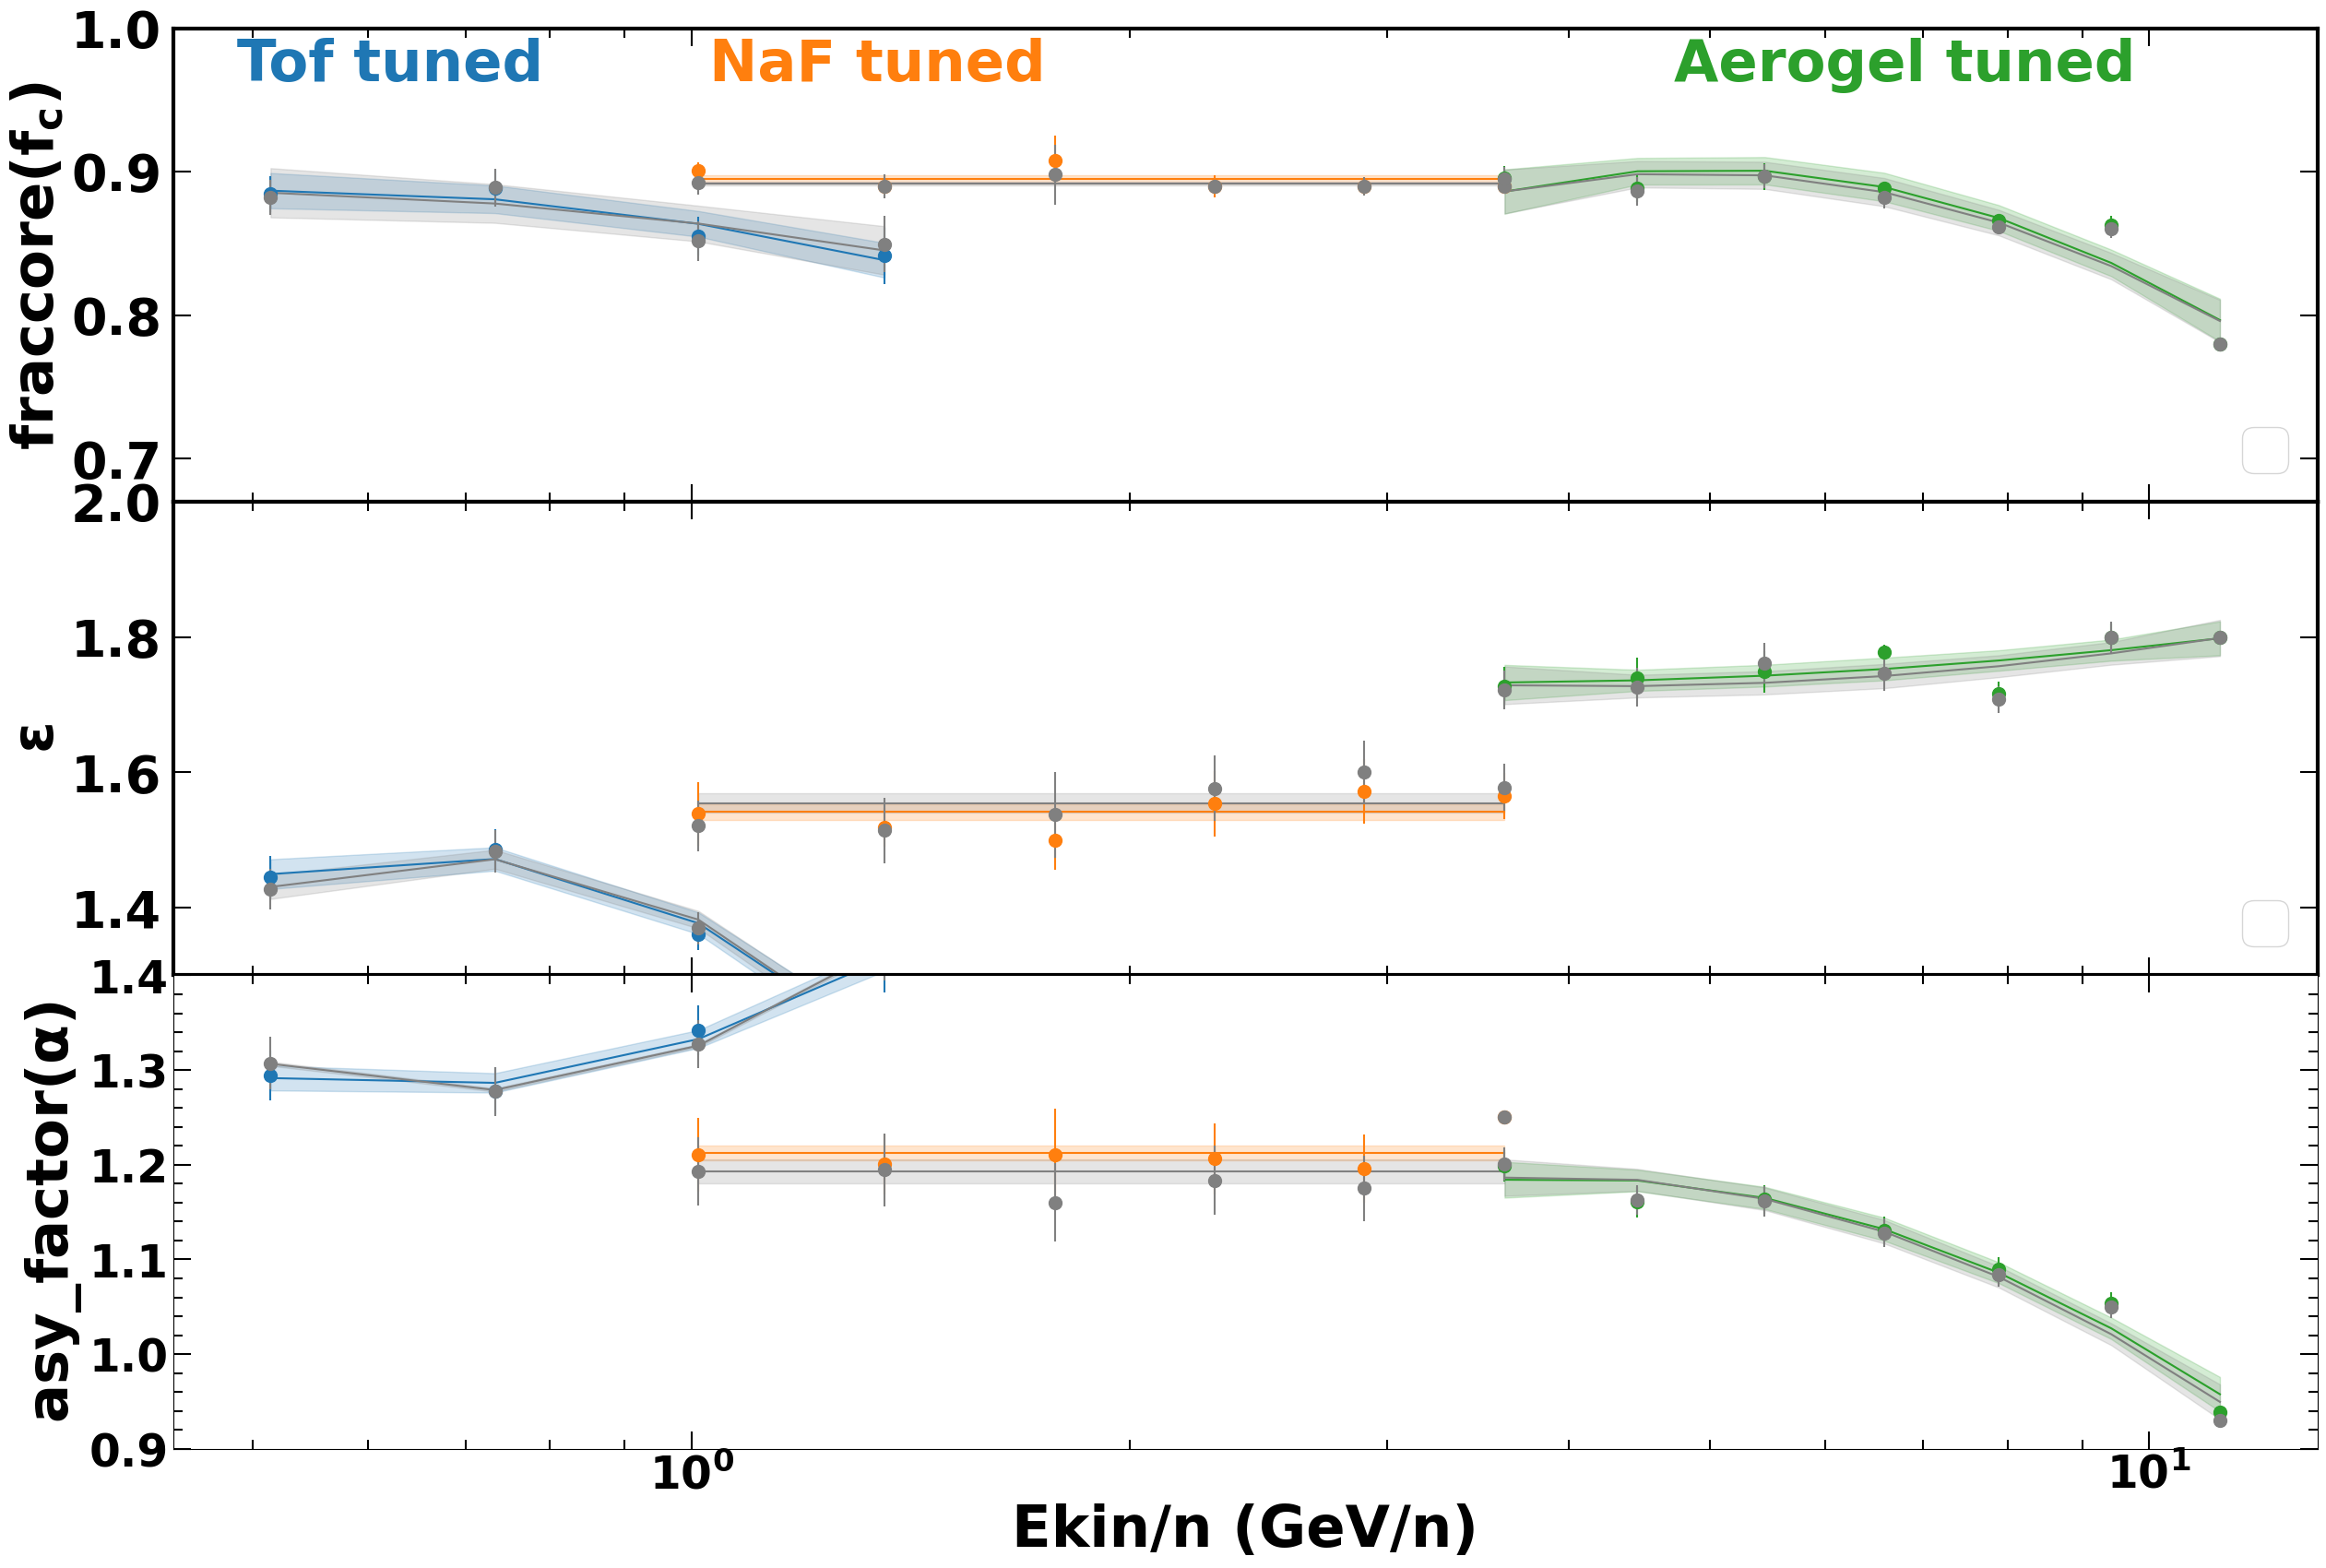

In [57]:
from tools.constants import ISOTOPES_MASS
from tools.massfit_tools import get_fitpdferrorband
import uncertainties                                                                                                                                                                                               
from uncertainties import unumpy                                                                                                                                                                                   
from uncertainties import ufloat  

n_iter = 'iter0'

#filepathU = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBetaExtUp_Rebin'
#filepathT0 = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMassTunedBetaHighR_Rebin/fitBe7/'
#filepathT = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBetaExtLow_Rebin'

filepathU = {'Tof':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCUnTuned_Rebin/',
             'NaF': '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedLow_Rebin/',
             'Agl':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedLow_Rebin/'}

filepathT = {'Tof':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin/',
             'NaF': '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedUp_Rebin/',
             'Agl':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedUp_Rebin/'}



graph_fraccoreU = {}
graph_fraccoreT = {}

graph_sigmaratioU = {}
graph_sigmaratioT = {}

graph_alphaU = {}
graph_alphaT = {}

decs = ['Tof', 'NaF','Agl']
for dec in decs:
    df_fraccoreU = np.load(os.path.join(filepathU[dec], f'df_fraccore_{n_iter}.npz'))
    df_fraccoreT = np.load(os.path.join(filepathT[dec], f'df_fraccore_{n_iter}.npz'))
    df_sigmaratioU = np.load(os.path.join(filepathU[dec], f'df_sigma_ratio_{n_iter}.npz'))
    df_sigmaratioT = np.load(os.path.join(filepathT[dec], f'df_sigma_ratio_{n_iter}.npz'))
    df_alphaU = np.load(os.path.join(filepathU[dec], f'df_asy_factor_{n_iter}.npz'))
    df_alphaT = np.load(os.path.join(filepathT[dec], f'df_asy_factor_{n_iter}.npz'))
    
    graph_fraccoreU[dec] = MGraph.from_file(df_fraccoreU, f'graph_fraccore_{dec}')
    graph_fraccoreT[dec] = MGraph.from_file(df_fraccoreT, f'graph_fraccore_{dec}')
    graph_sigmaratioU[dec] = MGraph.from_file(df_sigmaratioU, f'graph_sigma_ratio_{dec}')
    graph_sigmaratioT[dec] = MGraph.from_file(df_sigmaratioT, f'graph_sigma_ratio_{dec}')
    graph_alphaU[dec] = MGraph.from_file(df_alphaU, f'graph_asy_factor_{dec}')
    graph_alphaT[dec] = MGraph.from_file(df_alphaT, f'graph_asy_factor_{dec}')
    graph_parsUntuned[dec]['fraccore'] =  graph_fraccoreU[dec]
    graph_parsTuned[dec]['fraccore'] = graph_fraccoreT[dec]
    graph_parsUntuned[dec]['sigma_ratio'] =  graph_sigmaratioU[dec]
    graph_parsTuned[dec]['sigma_ratio'] = graph_sigmaratioT[dec]
    graph_parsUntuned[dec]['asy_factor'] =  graph_alphaU[dec]
    graph_parsTuned[dec]['asy_factor'] = graph_alphaT[dec]

print(graph_parsUntuned.items())
slicevalue_trueratio ={'Tof':[0.3, 1.2], 'NaF':[0.9, 6.0], 'Agl':[3.5, 12.0]}
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.33, 0.33, 0.33]}, figsize=(30, 20))                                                                     
xaxistext = {"Tof": 0.03, "NaF": 0.25, "Agl": 0.7}
p0_mean = {'Tof':[0.9], 'NaF':[0.8], "Agl":[0.8]}
p0_sigma = {'Tof':[1.0, 0.1, 0.1], 'NaF':[1.0], "Agl":[1.0, 0.1, 0.1]}

for dec in decs: 
    plot_parswitherr(fig, ax1, graph_fraccoreU[dec], DETECTOR_COLOR[dec], p0_sigma[dec])
    plot_parswitherr(fig, ax1, graph_fraccoreT[dec], 'grey', p0_sigma[dec])
    plot_parswitherr(fig, ax2, graph_sigmaratioU[dec], DETECTOR_COLOR[dec], p0_sigma[dec])
    plot_parswitherr(fig, ax2, graph_sigmaratioT[dec], 'grey', p0_sigma[dec])
    plot_parswitherr(fig, ax3, graph_alphaU[dec], DETECTOR_COLOR[dec], p0_sigma[dec])
    plot_parswitherr(fig, ax3, graph_alphaT[dec], 'grey', p0_sigma[dec])
    ax1.text(xaxistext[dec], 0.98,  f"{DETECTOR_LABEL[dec]} tuned", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=DETECTOR_COLOR[dec], fontweight="bold")      
             
#ax1.text(0.3, 0.5,  f"Untuned MC", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='grey', fontweight="bold")      
set_plot_style(ax1) 
set_plot_style(ax2)  
equation_text = r'$\mathrm{\mu = p_{0} + p_{1} \cdot x + p_{2} \cdot x^{2} , x = \log(E)}$'
#ax1.text(0.03, 0.15, equation_text, fontsize=35, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black') 
equation_sig = r'$\mathrm{\sigma = p_{0} + p_{1} \cdot x + p_{2} \cdot x^{2} + (p_{3} \cdot x^{3}), x = \log(E)}$'
equation_sig = r'$\mathrm{\sigma = \sum_{i}p_{i}\cdot x^{i}, x = \log(E)}$'
#ax2.text(0.03, 0.18, equation_sig, fontsize=35, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color='black') 
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax1.set_xlabel("Ekin/n (GeV/n)") 
#ax1.set_xscale('log')
#ax1.fill_betweenx(np.linspace(0.75, 0.8, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 
#ax1.axhline(y=ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'], color='orange', linestyle='--') 

#ax1.axhline(y=1.0, color='orange', linestyle='--')  
#ax1.axhline(y=0.77869417, color='black', linestyle='--')  

ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=fontsize1)
ax2.legend(loc='lower right', fontsize=fontsize1)
ax2.set_xscale('log')
ax3.set_xscale('log')

ax1.set_ylabel(r'$\mathrm{fraccore (f_{c})}$', fontsize=fontsize1)
ax2.set_ylabel(r'$\mathrm{\epsilon}$', fontsize=fontsize1)
ax3.set_ylabel(r'$\mathrm{asy\_factor (\alpha)}$', fontsize=fontsize1)
ax1.set_ylim([0.67, 1.0])
ax2.set_ylim([1.3, 2.0])
ax3.set_ylim([0.9, 1.4])
ax3.set_xlabel('Ekin/n (GeV/n)', fontsize=fontsize1)
#savefig_tofile(fig, plotfile, 'asygaus_tailpars_iter0_Agl2', 1)




In [58]:
def GetFitValueLim(graph1, p0, withsigma=True):
    if withsigma:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, sigma=graph1.yerrs, p0 = p0)  
    else:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0)  
        
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    fit_lower, fit_upper = get_fitpdferrorband(np.log(graph1.xvalues), polypars, upoly)
    return fit_lower, fit_upper

def get_uncertainty_spline(graphlow, graphup):
    xvector = graphlow.xvalues
    yvector = ((graphup.yvalues - graphlow.yvalues)/2)/((graphup.yvalues + graphlow.yvalues)/2)
    spline_fit = UnivariateSpline(np.log(xvector), yvector, k=3, s=5)
    return spline_fit

def GetFitValue(graph1, p0, withsigma=True):
    if withsigma:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, sigma=graph1.yerrs, p0 = p0)  
    else:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0)  
        
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    fity, fityerr = get_fitpdf_witherr(np.log(graph1.xvalues), polypars, upoly)
    graph_fit = MGraph(graph1.xvalues, fity, fityerr)
    return graph_fit

def getgraph_errband(graph1,  parname, par0, withsig=False):
    fit_lower1, fit_upper1 = GetFitValueLim(graph1, par0, withsigma=withsig)
    err1= (fit_upper1 - fit_lower1)/2 
    graph_fitlow = MGraph(graph1.xvalues,fit_lower1, np.zeros_like(fit_lower1))
    graph_fitup = MGraph(graph1.xvalues,fit_upper1, np.zeros_like(fit_upper1))
    return graph_fitlow, graph_fitup

def getgrapherr(graph1,  parname, par0, withsig=False):
    fit_lower1, fit_upper1 = GetFitValueLim(graph1, par0, withsigma=withsig)
    err1= (fit_upper1 - fit_lower1)/2 
    graph_err = MGraph(graph1.xvalues, err1, np.zeros_like(fit_upper1))
    return graph_err

def getgrapherr_fromLowUp(graphlow,  graphup):
    err= (graphup.yvalues - graphlow.yvalues)/2 
    graph_err = MGraph(graphlow.xvalues, err, np.zeros_like(err))
    return graph_err

def plot_errband_constraint(fig, ax1, dffile, graph1, graph2, col, parname, p0_mean, withsig=False):
    fit_lower1, fit_upper1 = GetFitValueLim(graph1, p0_mean, withsigma=withsig)
    err1= (fit_upper1 - fit_lower1)/2 
    fit_lower2, fit_upper2 = GetFitValueLim(graph2, p0_mean, withsigma=withsig)
    err2= (fit_upper2 - fit_lower2)/2
    fitlow = np.minimum(fit_lower1, fit_lower2) 
    fitup = np.maximum(fit_upper1, fit_upper2) 
    
    graph_fitlow = MGraph(graph1.xvalues, fitlow, np.zeros_like(fitlow))
    graph_fitup = MGraph(graph1.xvalues, fitup, np.zeros_like(fitup))
    graph_fitlow.add_to_file(dffile, f'graph_{parname}low_{dec}')
    graph_fitup.add_to_file(dffile, f'graph_{parname}up_{dec}')
    #print('up - low:', fitup - fitlow)
    return graph_fitlow, graph_fitup
    

dict_items([('Tof', {'mean': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7aeeaf0356f0>, 'sigma': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7aeeaf035ff0>, 'fraccore': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7aeeaf0348e0>, 'sigma_ratio': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7aeeaf037f10>, 'asy_factor': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7aeeaf034eb0>}), ('NaF', {'mean': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7aeeaf035540>, 'sigma': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7aeeaf035c30>, 'fraccore': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7aeeaf037880>, 'sigma_ratio': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7aeeaf034dc0>, 'asy_factor': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7aeeaf037370>}), ('Agl', {'mean': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7aeeaf035690

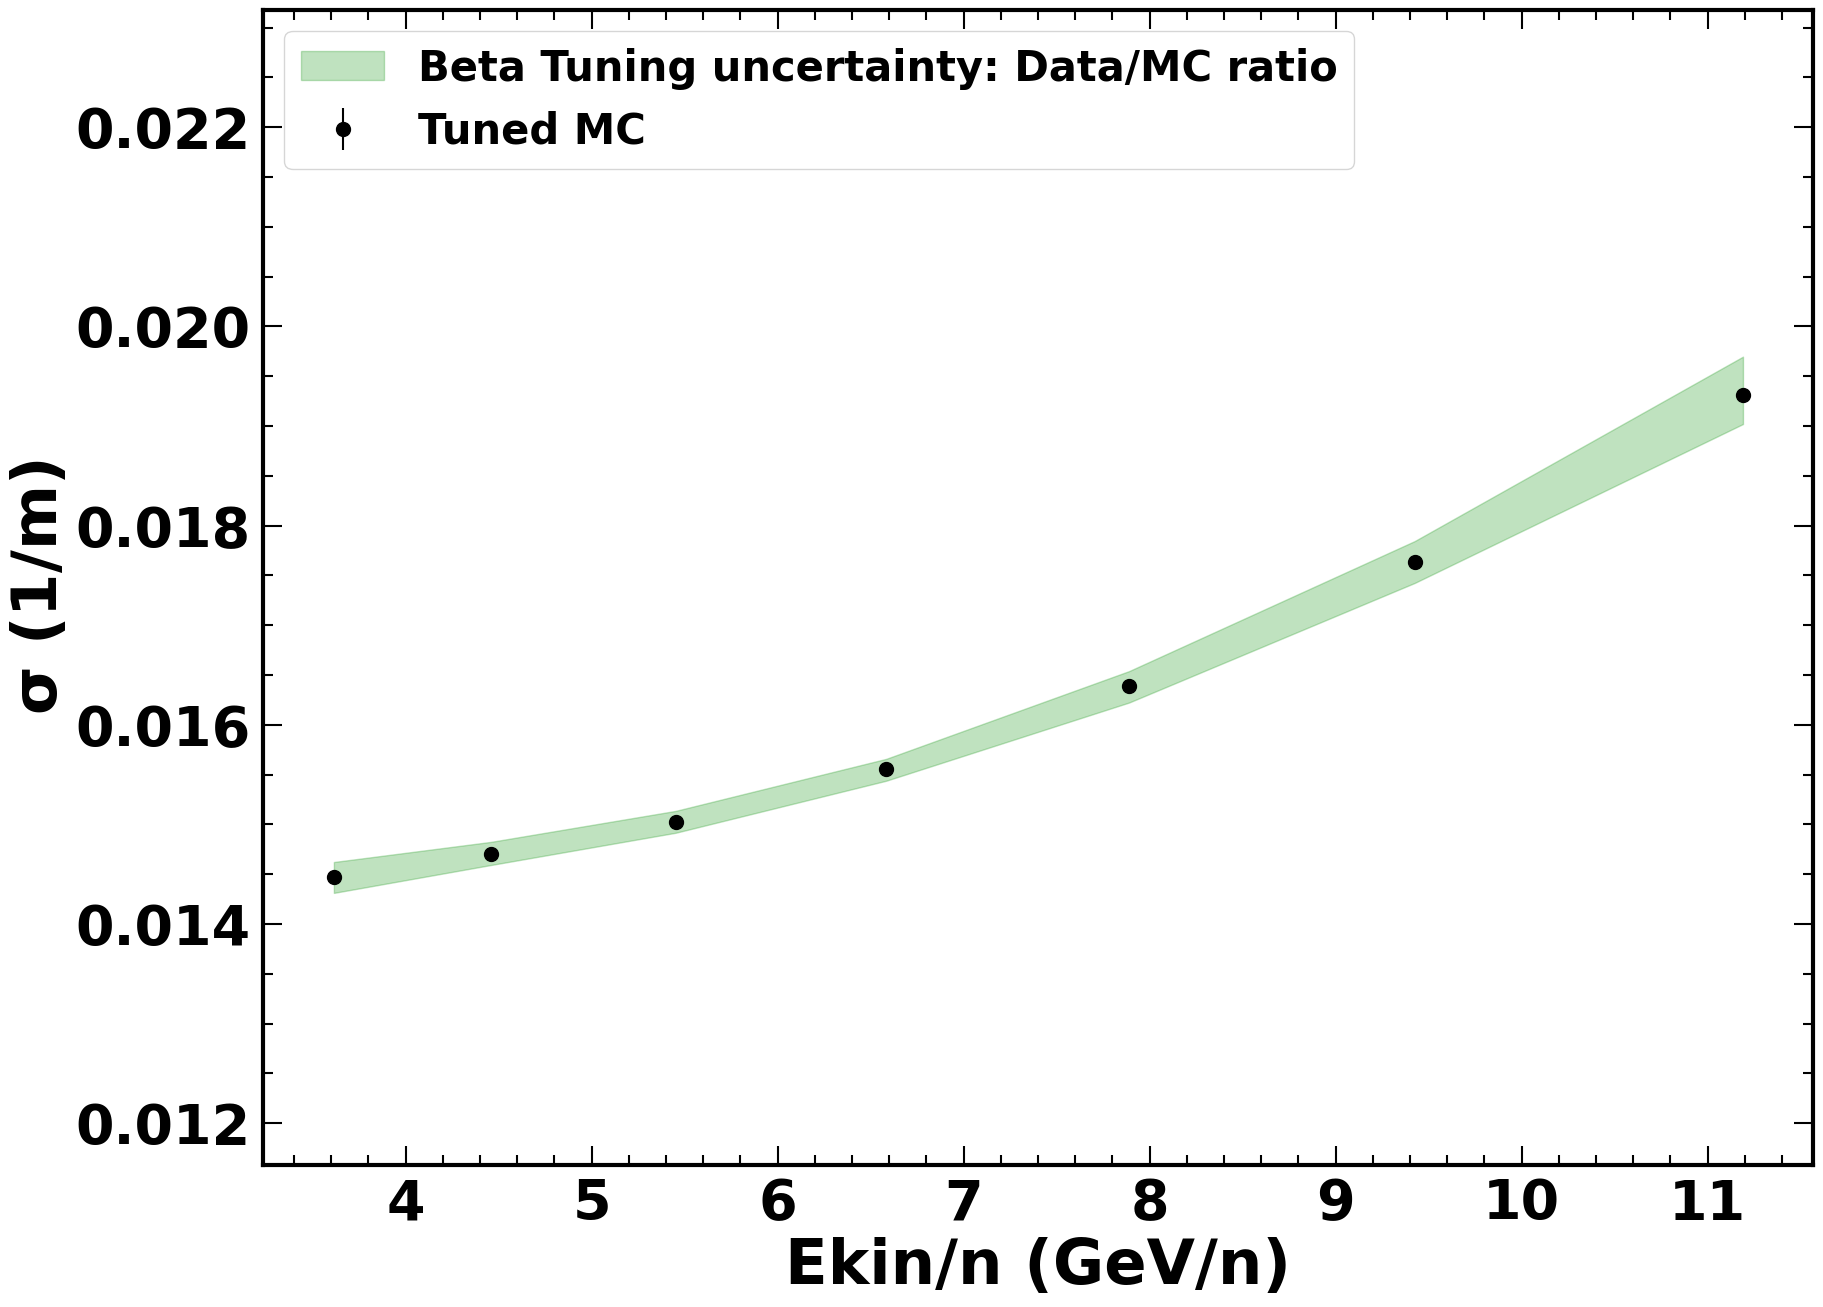

In [16]:

with open('/home/manbing/Documents/Data/data_BeP8/FitParsRange/splines_pars_uncertainty_rigSigma.pkl', 'rb') as file:
    loaddic_rigSigma = pickle.load(file)

import pickle
from scipy.interpolate import  UnivariateSpline

xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
df_graph_parslim = {}
df_graph_parslim_ext = {}

graph_fitlow = {dec:{} for dec in detectors}
graph_fitup = {dec:{} for dec in detectors}
graph_fitlowmax = {dec:{} for dec in detectors}
graph_fitupmax = {dec:{} for dec in detectors}

#print(graph_parsUntuned.items())

filepathTuneMax = {'Tof':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin',
                   'NaF':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedMin_Rebin',
                   'Agl':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedMin_Rebin'}

filepathTune = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin'
graph_MaxScale = {dec:{} for dec in detectors}
graph_MaxScaleLow = {dec:{} for dec in detectors}
graph_MaxScaleUp = {dec:{} for dec in detectors}

graph_TunedBeta0 = {dec:{} for dec in detectors}
graphfitted_TunedBeta0 = {dec:{} for dec in detectors}
ylim_range_be7 = {'mean':[0.145, 0.16], 'sigma':[0.013, 0.021], 'sigma_ratio':[1.6, 2.0], 'asy_factor': [0.8, 1.3], 'fraccore':[0.7, 1.0], "norm":[0, 40]} 
splinefit_uncertainty = {dec:{} for dec in detectors}
splinefit_uncertaintymax = {dec:{} for dec in detectors}
graph_MaxScaleErr = {dec:{} for dec in detectors}
df_graph_parslim_max = {}

for dec in ['Agl']:
    for par in ['sigma']:
        
        fig, ax1 = plt.subplots(1, 1, figsize=  FIGSIZE2)
        set_plot_style(ax1) 
        graph_fitlow[dec][par], graph_fitup[dec][par] = plot_errband_constraint(fig, ax1, df_graph_parslim, graph_parsUntuned[dec][par], graph_parsTuned[dec][par],  DETECTOR_COLOR[dec], par, polyfitp0[dec][par])
        #print(dec, par)
        #print(((graph_fitup[dec][par].yvalues - graph_fitlow[dec][par].yvalues)* 0.5)/((graph_fitlow[dec][par].yvalues + graph_fitup[dec][par].yvalues) *0.5))
        splinefit_uncertainty[dec][par] = get_uncertainty_spline(graph_fitlow[dec][par], graph_fitup[dec][par])
        
        
        df_maxscale = np.load(os.path.join(filepathTuneMax[dec], f'df_{par}_{itername}.npz'))
        graph_MaxScale[dec][par] = MGraph.from_file(df_maxscale, f'graph_{par}_{dec}')
        
        df_parT0 = np.load(os.path.join(filepathTune, f'df_{par}_{itername}.npz'))
        graph_TunedBeta0[dec][par] = MGraph.from_file(df_parT0, f'graph_{par}_{dec}')   
        graphfitted_TunedBeta0[dec][par] = GetFitValue(graph_TunedBeta0[dec][par], polyfitp0[dec][par], withsigma=False)
        #plot_graph(fig, ax1, graph_TunedBeta0[dec][par], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label='Tuned MC')
        plot_graph(fig, ax1, graphfitted_TunedBeta0[dec][par], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label='Tuned MC')
        #plot_graph(fig, ax1, graph_TunedBeta0[dec][par], color='green', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize)
        #graph_MaxScaleLow[dec][par], graph_MaxScaleUp[dec][par] = getgraph_errband(graph_MaxScale[dec][par], par, polyfitp0[dec][par])
        graph_MaxScaleLow[dec][par], graph_MaxScaleUp[dec][par] = plot_errband_constraint(fig, ax1, df_graph_parslim_ext, graph_MaxScale[dec][par], graph_parsUntuned[dec][par], 'grey', par, polyfitp0[dec][par], withsig=False)
        
        #graph_MaxScaleErr[dec][par] = getgrapherr(graph_MaxScale[dec][par],  par, polyfitp0[dec][par], withsig=False)
        graph_MaxScaleErr[dec][par] = getgrapherr_fromLowUp(graph_MaxScaleLow[dec][par], graph_MaxScaleUp[dec][par])
        #if par == 'fraccore':
        #    graph_fitup[dec][par].yvalues = graph_fitup[dec][par].yvalues * 1.002
        #ax1.fill_between(graph_fitlow[dec][par].xvalues, graph_fitlow[dec][par].yvalues, graph_fitup[dec][par].yvalues , color=DETECTOR_COLOR[dec], alpha=0.3, label=r'Beta Tuning uncertainty: Data/MC ratio')
        #ax1.fill_between(graph_MaxScaleLow[dec][par].xvalues, graph_MaxScaleLow[dec][par].yvalues, graph_MaxScaleUp[dec][par].yvalues , color="grey", alpha=0.3, label=r'uncertainty from MC $\mathrm{\sigma_{\beta}}$ at R>200GV')
        
        #First Err
        ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 1.0 * graph_MaxScaleErr[dec][par].yvalues , 1.0 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues, color=DETECTOR_COLOR[dec], alpha=0.3, label=r'Beta Tuning uncertainty: Data/MC ratio')
        
        
        #ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitup[dec][par].yvalues, 1.0 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues , color='grey', alpha=0.7)
        #Second Err
        #ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.65 * graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues -  graph_MaxScaleErr[dec][par].yvalues , color='grey', alpha=0.7, label=r'Beta Tuning uncertainty: energy dependence')
        #ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues , 2.65 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues,  color='grey', alpha=0.7)
        
        plt.subplots_adjust(hspace=.0)                                                                                                                                                                                                                                                                                                                                            
        ax1.set_xlabel("Ekin/n (GeV/n)")  
        ax1.set_ylim([0.8 * min(graphfitted_TunedBeta0[dec][par].yvalues), 1.2 *max(graphfitted_TunedBeta0[dec][par].yvalues)] )
        #ax1.set_ylim(ylim_range_be7[par])
        #ax1.set_xscale('log')
        
        ax1.set_ylabel(f'{par_names_axes[par]} (1/m)', fontsize=fontsize1)
        #print(dec, par)
        #ax1.legend()
       
        
        
        graph_fitlowmax[dec][par] = MGraph(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.65 * graph_MaxScaleErr[dec][par].yvalues, np.zeros_like(graph_MaxScaleErr[dec][par].xvalues))
        graph_fitupmax[dec][par] = MGraph(graph_MaxScaleErr[dec][par].xvalues, graph_fitup[dec][par].yvalues + 2.65 * graph_MaxScaleErr[dec][par].yvalues, np.zeros_like(graph_MaxScaleErr[dec][par].xvalues))
        graph_fitlowmax[dec][par].add_to_file(df_graph_parslim_max, f'graph_{par}low_{dec}')
        graph_fitupmax[dec][par].add_to_file(df_graph_parslim_max, f'graph_{par}up_{dec}')
        splinefit_uncertaintymax[dec][par] = get_uncertainty_spline(graph_fitlowmax[dec][par], graph_fitupmax[dec][par])
        
        #######################################################
        #Draw the uncertainty from Rig if rig sigma core +/- 5%
        #######################################################
        print(loaddic_rigSigma.items())
        rigSigErr = loaddic_rigSigma[dec][par](np.log(graph_MaxScaleErr[dec][par].xvalues))
        lowPile2 = graph_fitlow[dec][par].yvalues - 2.65 * graph_MaxScaleErr[dec][par].yvalues 
        upPile2 = 2.65 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues
        #ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues,  lowPile2 - 2 * rigSigErr, lowPile2, color='tab:blue', alpha=0.3, label=r'Tuning uncertainty of Rig Sig +/- 5%')
        #ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues,  upPile2, upPile2 + 2 * rigSigErr, color='tab:blue', alpha=0.3)
        ax1.legend(loc='upper left', fontsize=30)
        print(plotfile)
        set_plot_style(ax1)
        savefig_tofile(fig, plotfile, f'fitrange_{dec}_{par}_Err1', 1)
    #print(loaddic.items())
    
np.savez(os.path.join('/home/manbing/Documents/Data/data_BeP8', 'graph_parslim_TunedUncertainty.npz'), **df_graph_parslim_max)




[0.05986845 0.05871522 0.05591379 0.05308309 0.05139964 0.05148915
 0.05372221]
[0.01184855 0.00845736 0.0077723  0.00740873 0.00959629 0.01041804
 0.01365802]
[0.06102966 0.0593212  0.0564514  0.05359761 0.05228778 0.05253254
 0.0554312 ]
/home/manbing/Documents/lithiumanalysis/slides/plots/GetTemplateParsRange


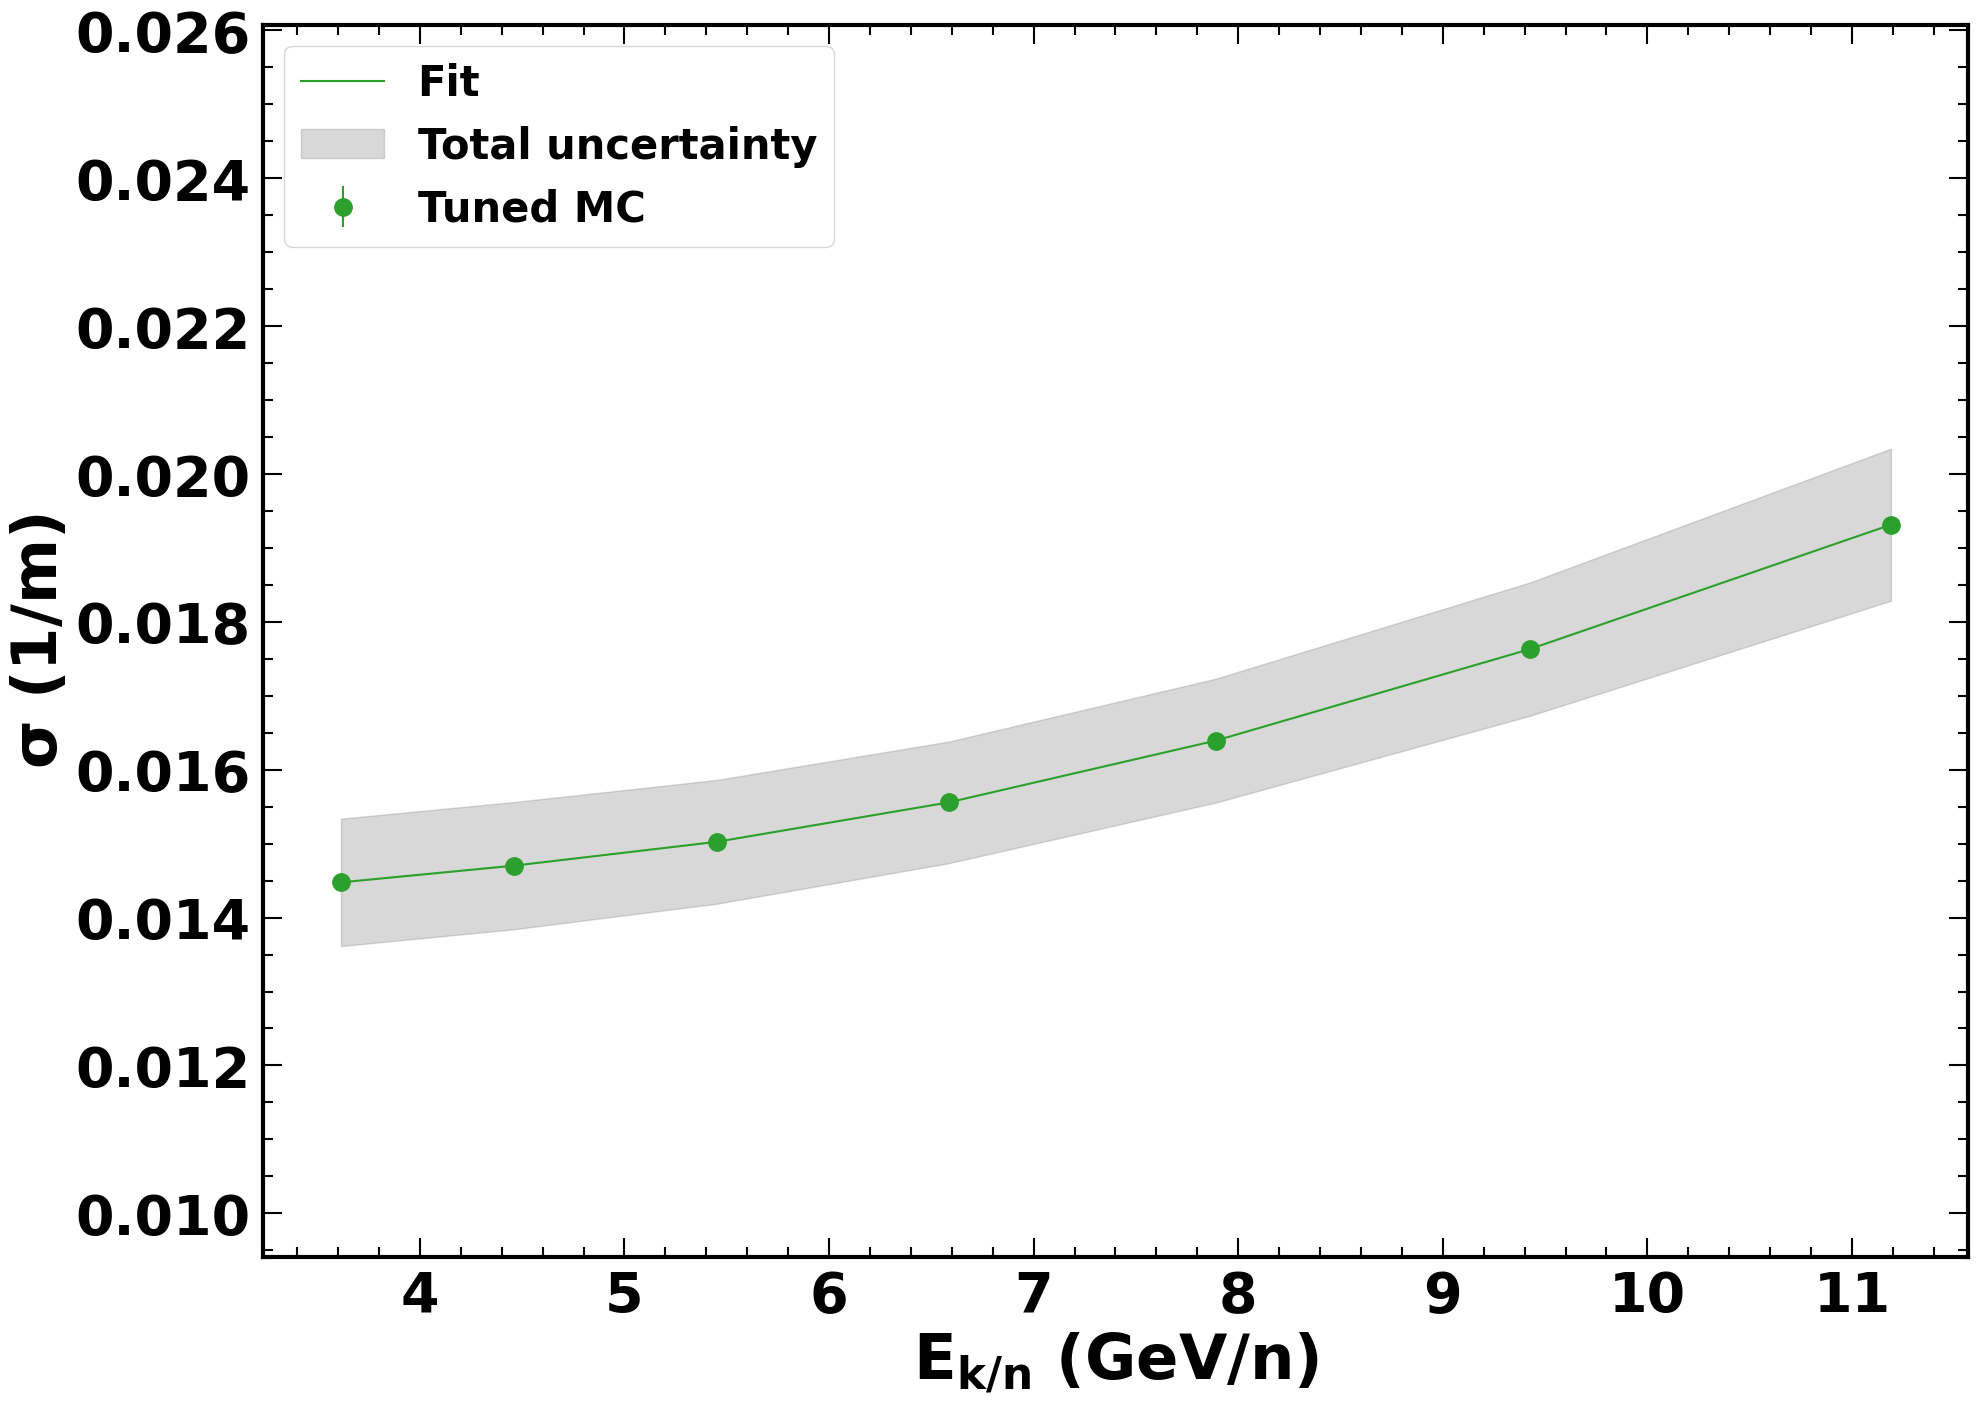

In [25]:

with open('/home/manbing/Documents/Data/data_BeP8/FitParsRange/splines_pars_uncertainty_rigSigma.pkl', 'rb') as file:
    loaddic_rigSigma = pickle.load(file)

import pickle
from scipy.interpolate import  UnivariateSpline

xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
df_graph_parslim = {}
df_graph_parslim_ext = {}

graph_fitlow = {dec:{} for dec in detectors}
graph_fitup = {dec:{} for dec in detectors}
graph_fitlowmax = {dec:{} for dec in detectors}
graph_fitupmax = {dec:{} for dec in detectors}

#print(graph_parsUntuned.items())

filepathTuneMax = {'Tof':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin',
                   'NaF':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedMin_Rebin',
                   'Agl':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedMin_Rebin'}

filepathTune = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin'
graph_MaxScale = {dec:{} for dec in detectors}
graph_MaxScaleLow = {dec:{} for dec in detectors}
graph_MaxScaleUp = {dec:{} for dec in detectors}

graph_TunedBeta0 = {dec:{} for dec in detectors}
graphfitted_TunedBeta0 = {dec:{} for dec in detectors}
ylim_range_be7 = {'mean':[0.145, 0.16], 'sigma':[0.013, 0.021], 'sigma_ratio':[1.6, 2.0], 'asy_factor': [0.8, 1.3], 'fraccore':[0.7, 1.0], "norm":[0, 40]} 
splinefit_uncertainty = {dec:{} for dec in detectors}
splinefit_uncertaintymax = {dec:{} for dec in detectors}
graph_MaxScaleErr = {dec:{} for dec in detectors}
df_graph_parslim_max = {}

for dec in ['Agl']:
    for par in ['sigma']:    
        fig, ax1 = plt.subplots(1, 1, figsize=  FIGSIZE3)
        set_plot_style(ax1) 
        graph_fitlow[dec][par], graph_fitup[dec][par] = plot_errband_constraint(fig, ax1, df_graph_parslim, graph_parsUntuned[dec][par], graph_parsTuned[dec][par],  DETECTOR_COLOR[dec], par, polyfitp0[dec][par])
        splinefit_uncertainty[dec][par] = get_uncertainty_spline(graph_fitlow[dec][par], graph_fitup[dec][par])
        
        df_maxscale = np.load(os.path.join(filepathTuneMax[dec], f'df_{par}_{itername}.npz'))
        graph_MaxScale[dec][par] = MGraph.from_file(df_maxscale, f'graph_{par}_{dec}')
        
        df_parT0 = np.load(os.path.join(filepathTune, f'df_{par}_{itername}.npz'))
        graph_TunedBeta0[dec][par] = MGraph.from_file(df_parT0, f'graph_{par}_{dec}')   
        graphfitted_TunedBeta0[dec][par] = GetFitValue(graph_TunedBeta0[dec][par], polyfitp0[dec][par], withsigma=False)
        
        plot_graph(fig, ax1, graphfitted_TunedBeta0[dec][par], color='tab:green', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize+5, label='Tuned MC')
        plot_graph(fig, ax1, graphfitted_TunedBeta0[dec][par], color='tab:green', style="hist", xlog=False, ylog=False, scale=None, markersize=mksize+5, label='Fit')
        
        graph_MaxScaleLow[dec][par], graph_MaxScaleUp[dec][par] = plot_errband_constraint(fig, ax1, df_graph_parslim_ext, graph_MaxScale[dec][par], graph_parsUntuned[dec][par], 'grey', par, polyfitp0[dec][par], withsig=False)
        graph_MaxScaleErr[dec][par] = getgrapherr_fromLowUp(graph_MaxScaleLow[dec][par], graph_MaxScaleUp[dec][par])
        
        #First Err
        #ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.2 * graph_MaxScaleErr[dec][par].yvalues , 2.2 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues, color='grey', alpha=0.3, label=r'Uncertainty from beta resolution')
        
        #Second Err
        #ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.65 * graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues -  graph_MaxScaleErr[dec][par].yvalues , color='grey', alpha=0.7, label=r'Beta Tuning uncertainty: energy dependence')
        #ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues , 2.65 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues,  color='grey', alpha=0.7)
        
        plt.subplots_adjust(hspace=.0)                                                                                                                                                                                                                                                                                                                                            
        ax1.set_xlabel(r"$\mathrm{E_{k/n} \  (GeV/n)}$")  
        ax1.set_ylim([0.65 * min(graphfitted_TunedBeta0[dec][par].yvalues), 1.35 *max(graphfitted_TunedBeta0[dec][par].yvalues)] )
        
        ax1.set_ylabel(f'{par_names_axes[par]} (1/m)', fontsize=fontsize1)
        graph_fitlowmax[dec][par] = MGraph(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.65 * graph_MaxScaleErr[dec][par].yvalues, np.zeros_like(graph_MaxScaleErr[dec][par].xvalues))
        graph_fitupmax[dec][par] = MGraph(graph_MaxScaleErr[dec][par].xvalues, graph_fitup[dec][par].yvalues + 2.65 * graph_MaxScaleErr[dec][par].yvalues, np.zeros_like(graph_MaxScaleErr[dec][par].xvalues))
        graph_fitlowmax[dec][par].add_to_file(df_graph_parslim_max, f'graph_{par}low_{dec}')
        graph_fitupmax[dec][par].add_to_file(df_graph_parslim_max, f'graph_{par}up_{dec}')
        splinefit_uncertaintymax[dec][par] = get_uncertainty_spline(graph_fitlowmax[dec][par], graph_fitupmax[dec][par])
        
        #######################################################
        #Draw the uncertainty from Rig if rig sigma core +/- 5%
        #######################################################
        rigSigErr = loaddic_rigSigma[dec][par](np.log(graph_MaxScaleErr[dec][par].xvalues))
        lowPile2 = graph_fitlow[dec][par].yvalues - 2.2 * graph_MaxScaleErr[dec][par].yvalues 
        upPile2 = 2.2 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues
        print(2*rigSigErr/graph_fitlow[dec][par].yvalues)
        print(2.2 * graph_MaxScaleErr[dec][par].yvalues/graph_fitlow[dec][par].yvalues)
        totalerr = np.sqrt((2.2 * graph_MaxScaleErr[dec][par].yvalues)**2 + (2 * rigSigErr)**2)
        print(totalerr/graph_fitlow[dec][par].yvalues)
        ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graphfitted_TunedBeta0[dec][par].yvalues  -  2* rigSigErr, graphfitted_TunedBeta0[dec][par].yvalues  +  2 *rigSigErr, color='grey', alpha=0.3, label=r'Total uncertainty')
        #ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues,  upPile2, upPile2 +  totalerr, color='tab:blue', alpha=0.3)
        ax1.legend(loc='upper left', fontsize=30)
        savefig_tofile(fig, plotfile, f'fitrange_{dec}_{par}_Errband', 1)
    #print(loaddic.items())
        set_plot_style(ax1)
print(plotfile)
np.savez(os.path.join('/home/manbing/Documents/Data/data_BeP8', 'graph_parslim_TunedUncertainty.npz'), **df_graph_parslim_max)




[0.05986845 0.05871522 0.05591379 0.05308309 0.05139964 0.05148915
 0.05372221]
[0.01184855 0.00845736 0.0077723  0.00740873 0.00959629 0.01041804
 0.01365802]
[0.06102966 0.0593212  0.0564514  0.05359761 0.05228778 0.05253254
 0.0554312 ]
/home/manbing/Documents/lithiumanalysis/slides/plots/GetTemplateParsRange


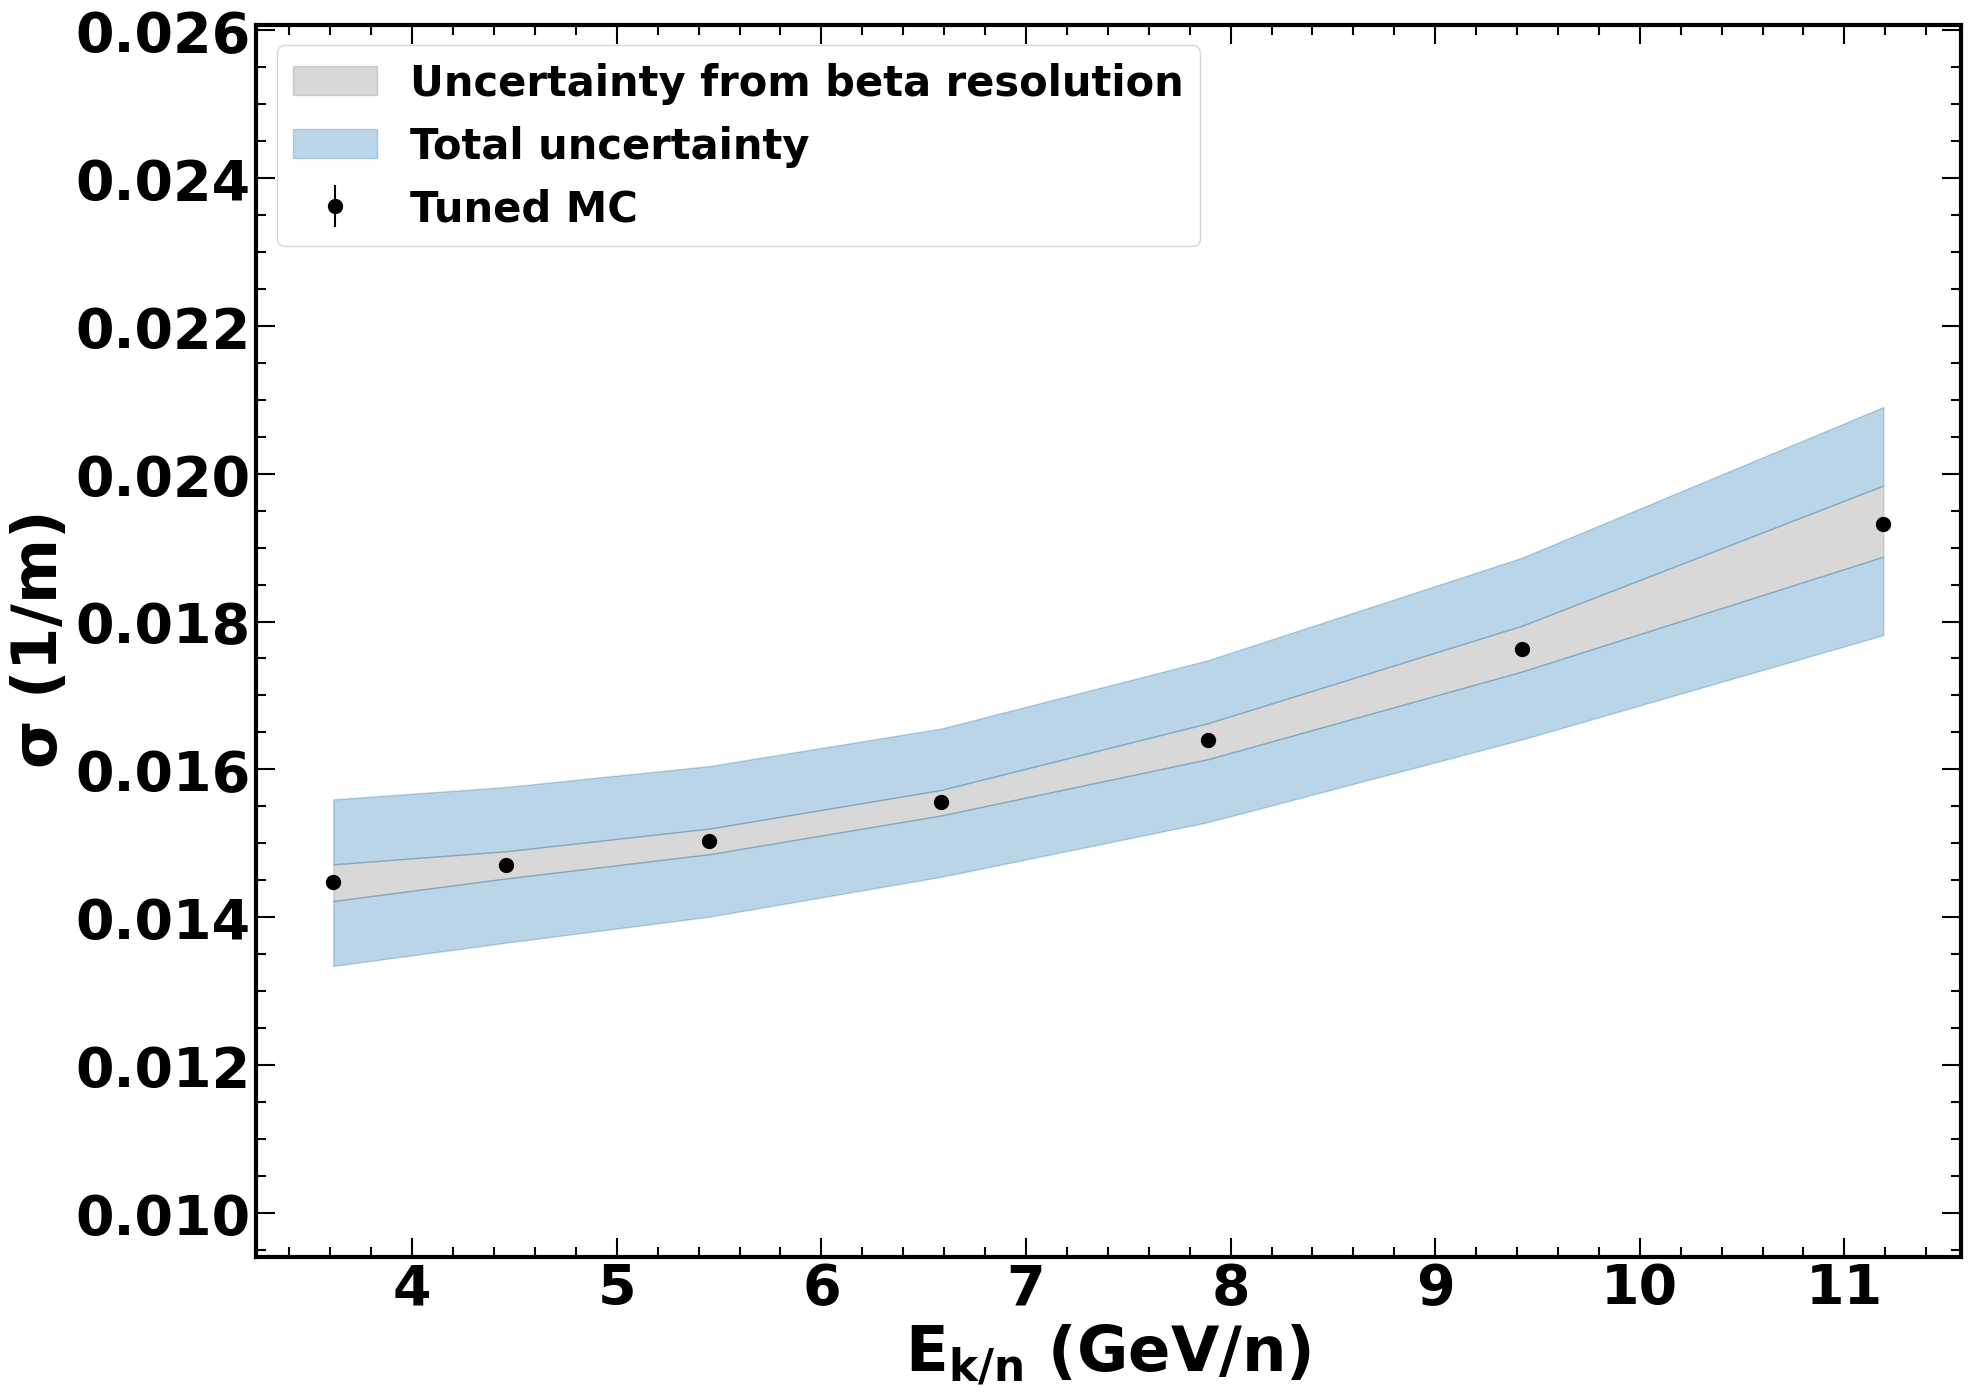

In [12]:

with open('/home/manbing/Documents/Data/data_BeP8/FitParsRange/splines_pars_uncertainty_rigSigma.pkl', 'rb') as file:
    loaddic_rigSigma = pickle.load(file)

import pickle
from scipy.interpolate import  UnivariateSpline

xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
df_graph_parslim = {}
df_graph_parslim_ext = {}

graph_fitlow = {dec:{} for dec in detectors}
graph_fitup = {dec:{} for dec in detectors}
graph_fitlowmax = {dec:{} for dec in detectors}
graph_fitupmax = {dec:{} for dec in detectors}

#print(graph_parsUntuned.items())

filepathTuneMax = {'Tof':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin',
                   'NaF':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedMin_Rebin',
                   'Agl':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedMin_Rebin'}

filepathTune = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin'
graph_MaxScale = {dec:{} for dec in detectors}
graph_MaxScaleLow = {dec:{} for dec in detectors}
graph_MaxScaleUp = {dec:{} for dec in detectors}

graph_TunedBeta0 = {dec:{} for dec in detectors}
graphfitted_TunedBeta0 = {dec:{} for dec in detectors}
ylim_range_be7 = {'mean':[0.145, 0.16], 'sigma':[0.013, 0.021], 'sigma_ratio':[1.6, 2.0], 'asy_factor': [0.8, 1.3], 'fraccore':[0.7, 1.0], "norm":[0, 40]} 
splinefit_uncertainty = {dec:{} for dec in detectors}
splinefit_uncertaintymax = {dec:{} for dec in detectors}
graph_MaxScaleErr = {dec:{} for dec in detectors}
df_graph_parslim_max = {}

for dec in ['Agl']:
    for par in ['sigma']:    
        fig, ax1 = plt.subplots(1, 1, figsize=  FIGSIZE3)
        set_plot_style(ax1) 
        graph_fitlow[dec][par], graph_fitup[dec][par] = plot_errband_constraint(fig, ax1, df_graph_parslim, graph_parsUntuned[dec][par], graph_parsTuned[dec][par],  DETECTOR_COLOR[dec], par, polyfitp0[dec][par])
        splinefit_uncertainty[dec][par] = get_uncertainty_spline(graph_fitlow[dec][par], graph_fitup[dec][par])
        
        df_maxscale = np.load(os.path.join(filepathTuneMax[dec], f'df_{par}_{itername}.npz'))
        graph_MaxScale[dec][par] = MGraph.from_file(df_maxscale, f'graph_{par}_{dec}')
        
        df_parT0 = np.load(os.path.join(filepathTune, f'df_{par}_{itername}.npz'))
        graph_TunedBeta0[dec][par] = MGraph.from_file(df_parT0, f'graph_{par}_{dec}')   
        graphfitted_TunedBeta0[dec][par] = GetFitValue(graph_TunedBeta0[dec][par], polyfitp0[dec][par], withsigma=False)
        
        plot_graph(fig, ax1, graphfitted_TunedBeta0[dec][par], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label='Tuned MC')
        
        graph_MaxScaleLow[dec][par], graph_MaxScaleUp[dec][par] = plot_errband_constraint(fig, ax1, df_graph_parslim_ext, graph_MaxScale[dec][par], graph_parsUntuned[dec][par], 'grey', par, polyfitp0[dec][par], withsig=False)
        graph_MaxScaleErr[dec][par] = getgrapherr_fromLowUp(graph_MaxScaleLow[dec][par], graph_MaxScaleUp[dec][par])
        
        #First Err
        ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.2 * graph_MaxScaleErr[dec][par].yvalues , 2.2 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues, color='grey', alpha=0.3, label=r'Uncertainty from beta resolution')
        
        #Second Err
        #ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.65 * graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues -  graph_MaxScaleErr[dec][par].yvalues , color='grey', alpha=0.7, label=r'Beta Tuning uncertainty: energy dependence')
        #ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues , 2.65 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues,  color='grey', alpha=0.7)
        
        plt.subplots_adjust(hspace=.0)                                                                                                                                                                                                                                                                                                                                            
        ax1.set_xlabel(r"$\mathrm{E_{k/n} \  (GeV/n)}$")  
        ax1.set_ylim([0.65 * min(graphfitted_TunedBeta0[dec][par].yvalues), 1.35 *max(graphfitted_TunedBeta0[dec][par].yvalues)] )
        
        ax1.set_ylabel(f'{par_names_axes[par]} (1/m)', fontsize=fontsize1)
        graph_fitlowmax[dec][par] = MGraph(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.65 * graph_MaxScaleErr[dec][par].yvalues, np.zeros_like(graph_MaxScaleErr[dec][par].xvalues))
        graph_fitupmax[dec][par] = MGraph(graph_MaxScaleErr[dec][par].xvalues, graph_fitup[dec][par].yvalues + 2.65 * graph_MaxScaleErr[dec][par].yvalues, np.zeros_like(graph_MaxScaleErr[dec][par].xvalues))
        graph_fitlowmax[dec][par].add_to_file(df_graph_parslim_max, f'graph_{par}low_{dec}')
        graph_fitupmax[dec][par].add_to_file(df_graph_parslim_max, f'graph_{par}up_{dec}')
        splinefit_uncertaintymax[dec][par] = get_uncertainty_spline(graph_fitlowmax[dec][par], graph_fitupmax[dec][par])
        
        #######################################################
        #Draw the uncertainty from Rig if rig sigma core +/- 5%
        #######################################################
        rigSigErr = loaddic_rigSigma[dec][par](np.log(graph_MaxScaleErr[dec][par].xvalues))
        lowPile2 = graph_fitlow[dec][par].yvalues - 2.2 * graph_MaxScaleErr[dec][par].yvalues 
        upPile2 = 2.2 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues
        print(2*rigSigErr/graph_fitlow[dec][par].yvalues)
        print(2.2 * graph_MaxScaleErr[dec][par].yvalues/graph_fitlow[dec][par].yvalues)
        totalerr = np.sqrt((2.2 * graph_MaxScaleErr[dec][par].yvalues)**2 + (2 * rigSigErr)**2)
        print(totalerr/graph_fitlow[dec][par].yvalues)
        ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues,  lowPile2 -  totalerr, lowPile2, color='tab:blue', alpha=0.3, label=r'Total uncertainty')
        ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues,  upPile2, upPile2 +  totalerr, color='tab:blue', alpha=0.3)
        ax1.legend(loc='upper left', fontsize=30)
        savefig_tofile(fig, plotfile, f'fitrange_{dec}_{par}_Errband', 1)
    #print(loaddic.items())
        set_plot_style(ax1)
print(plotfile)
np.savez(os.path.join('/home/manbing/Documents/Data/data_BeP8', 'graph_parslim_TunedUncertainty.npz'), **df_graph_parslim_max)




/home/manbing/Documents/lithiumanalysis/slides/plots/GetTemplateParsRange
fitrange_sigma_Errband


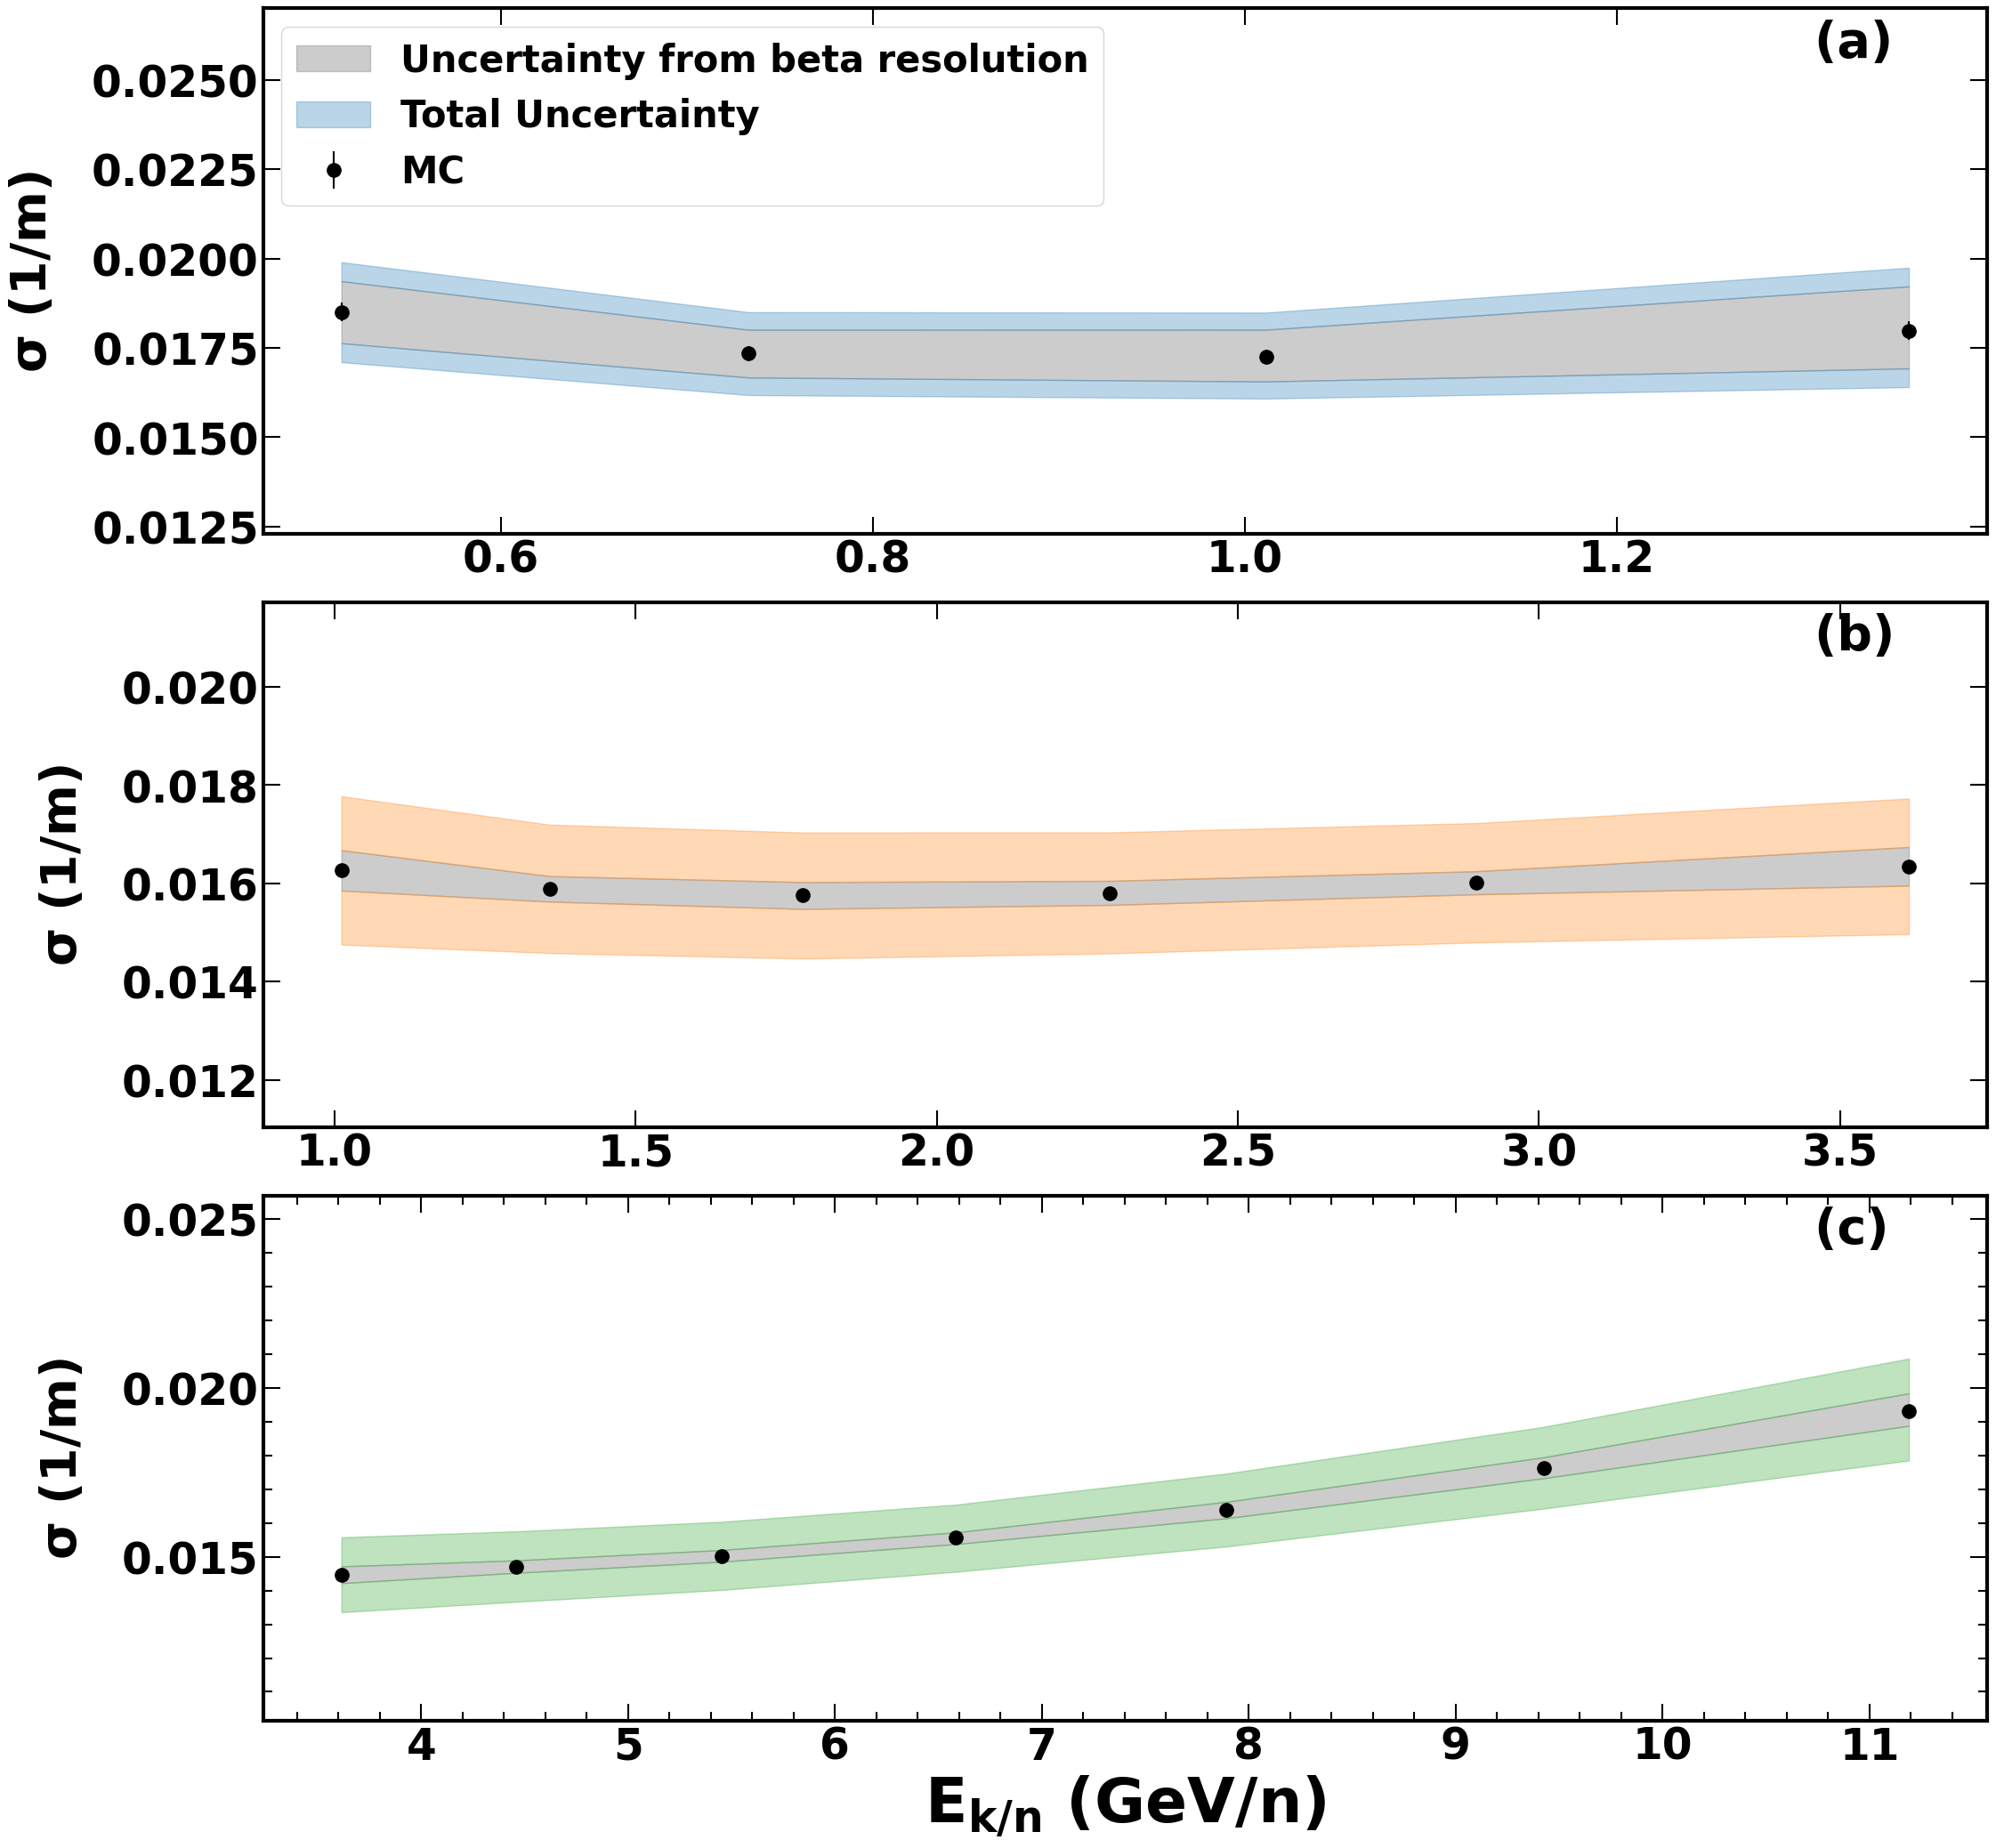

In [56]:

with open('/home/manbing/Documents/Data/data_BeP8/FitParsRange/splines_pars_uncertainty_rigSigma.pkl', 'rb') as file:
    loaddic_rigSigma = pickle.load(file)

import pickle
from scipy.interpolate import  UnivariateSpline

xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
df_graph_parslim = {}
df_graph_parslim_ext = {}

graph_fitlow = {dec:{} for dec in detectors}
graph_fitup = {dec:{} for dec in detectors}
graph_fitlowmax = {dec:{} for dec in detectors}
graph_fitupmax = {dec:{} for dec in detectors}

#print(graph_parsUntuned.items())

filepathTuneMax = {'Tof':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin',
                   'NaF':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedMin_Rebin',
                   'Agl':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedMin_Rebin'}

filepathTune = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin'
graph_MaxScale = {dec:{} for dec in detectors}
graph_MaxScaleLow = {dec:{} for dec in detectors}
graph_MaxScaleUp = {dec:{} for dec in detectors}

graph_TunedBeta0 = {dec:{} for dec in detectors}
graphfitted_TunedBeta0 = {dec:{} for dec in detectors}
ylim_range_be7 = {'mean':[0.145, 0.16], 'sigma':[0.013, 0.021], 'sigma_ratio':[1.6, 2.0], 'asy_factor': [0.8, 1.3], 'fraccore':[0.7, 1.0], "norm":[0, 40]} 
splinefit_uncertainty = {dec:{} for dec in detectors}
splinefit_uncertaintymax = {dec:{} for dec in detectors}
graph_MaxScaleErr = {dec:{} for dec in detectors}
df_graph_parslim_max = {}

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.33, 0.33, 0.33]}, figsize=(25, 25))
set_plot_style(ax1) 
set_plot_style(ax2)  
set_plot_style(ax3) 

ax = [ax1, ax2, ax3]
Num = ['a', 'b', 'c']
for i, dec in enumerate(detectors):
    for par in ['sigma']:    
        graph_fitlow[dec][par], graph_fitup[dec][par] = plot_errband_constraint(fig, ax1, df_graph_parslim, graph_parsUntuned[dec][par], graph_parsTuned[dec][par],  DETECTOR_COLOR[dec], par, polyfitp0[dec][par])
        splinefit_uncertainty[dec][par] = get_uncertainty_spline(graph_fitlow[dec][par], graph_fitup[dec][par])
        
        df_maxscale = np.load(os.path.join(filepathTuneMax[dec], f'df_{par}_{itername}.npz'))
        graph_MaxScale[dec][par] = MGraph.from_file(df_maxscale, f'graph_{par}_{dec}')
        
        df_parT0 = np.load(os.path.join(filepathTune, f'df_{par}_{itername}.npz'))
        graph_TunedBeta0[dec][par] = MGraph.from_file(df_parT0, f'graph_{par}_{dec}')   
        graphfitted_TunedBeta0[dec][par] = GetFitValue(graph_TunedBeta0[dec][par], polyfitp0[dec][par], withsigma=False)
        
        
        
        graph_MaxScaleLow[dec][par], graph_MaxScaleUp[dec][par] = plot_errband_constraint(fig, ax1, df_graph_parslim_ext, graph_MaxScale[dec][par], graph_parsUntuned[dec][par], 'grey', par, polyfitp0[dec][par], withsig=False)
        graph_MaxScaleErr[dec][par] = getgrapherr_fromLowUp(graph_MaxScaleLow[dec][par], graph_MaxScaleUp[dec][par])
        
        plot_graph(fig, ax[i], graphfitted_TunedBeta0[dec][par], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize+2, label='MC')
        #First Err
        ax[i].fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.2 * graph_MaxScaleErr[dec][par].yvalues , 2.2 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues, color='grey', alpha=0.4, label=r'Uncertainty from beta resolution')
        
        #Second Err
        #ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.65 * graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues -  graph_MaxScaleErr[dec][par].yvalues , color='grey', alpha=0.7, label=r'Beta Tuning uncertainty: energy dependence')
        #ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues , 2.65 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues,  color='grey', alpha=0.7)
        
        plt.subplots_adjust(hspace=.13)                                                                                                                                                                                                                                                                                                                                            
        
        ax[i].set_ylim([0.7 * min(graphfitted_TunedBeta0[dec][par].yvalues), 1.33 *max(graphfitted_TunedBeta0[dec][par].yvalues)] )
        
        
        graph_fitlowmax[dec][par] = MGraph(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.65 * graph_MaxScaleErr[dec][par].yvalues, np.zeros_like(graph_MaxScaleErr[dec][par].xvalues))
        graph_fitupmax[dec][par] = MGraph(graph_MaxScaleErr[dec][par].xvalues, graph_fitup[dec][par].yvalues + 2.65 * graph_MaxScaleErr[dec][par].yvalues, np.zeros_like(graph_MaxScaleErr[dec][par].xvalues))
        graph_fitlowmax[dec][par].add_to_file(df_graph_parslim_max, f'graph_{par}low_{dec}')
        graph_fitupmax[dec][par].add_to_file(df_graph_parslim_max, f'graph_{par}up_{dec}')
        splinefit_uncertaintymax[dec][par] = get_uncertainty_spline(graph_fitlowmax[dec][par], graph_fitupmax[dec][par])
        
        #######################################################
        #Draw the uncertainty from Rig if rig sigma core +/- 5%
        #######################################################
        rigSigErr = loaddic_rigSigma[dec][par](np.log(graph_MaxScaleErr[dec][par].xvalues))
        lowPile2 = graph_fitlow[dec][par].yvalues - 2.2 * graph_MaxScaleErr[dec][par].yvalues 
        upPile2 = 2.2 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues
        ax[i].fill_between(graph_MaxScaleErr[dec][par].xvalues,  lowPile2 - 2 * rigSigErr, lowPile2, color= 'tab:blue', alpha=0.3, label=r'Total Uncertainty' if dec == 'Tof' else None)
        ax[i].fill_between(graph_MaxScaleErr[dec][par].xvalues,  upPile2, upPile2 + 2 * rigSigErr, color= 'tab:blue', alpha=0.3)
        ax[i].text(0.9, 0.98, f"({Num[i]}) ", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", fontweight="bold")
        ax[i].set_ylabel(f'{par_names_axes[par]} (1/m)', fontsize=40, labelpad=28)
    #print(loaddic.items())

ax3.set_xlabel(r"$\mathrm{E_{k/n} \ (GeV/n)}$", fontsize =50)  
ax1.set_ylim([0.0123, 0.027])
ax1.legend(loc='upper left', fontsize=30)
print(plotfile)
savefig_tofile(fig, plotfile, f'fitrange_{par}_Errband', 1)
print(f'fitrange_{par}_Errband')
np.savez(os.path.join('/home/manbing/Documents/Data/data_BeP8', 'graph_parslim_TunedUncertainty.npz'), **df_graph_parslim_max)




dict_items([('Tof', {'mean': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbd13d4460>, 'sigma': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbd1345f60>, 'fraccore': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbd1346830>, 'sigma_ratio': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbd1346dd0>, 'asy_factor': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbd1346710>}), ('NaF', {'mean': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbd1347550>, 'sigma': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbd1347bb0>, 'fraccore': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbd1345ff0>, 'sigma_ratio': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbd1345c60>, 'asy_factor': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbd1345750>}), ('Agl', {'mean': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbd15459f0

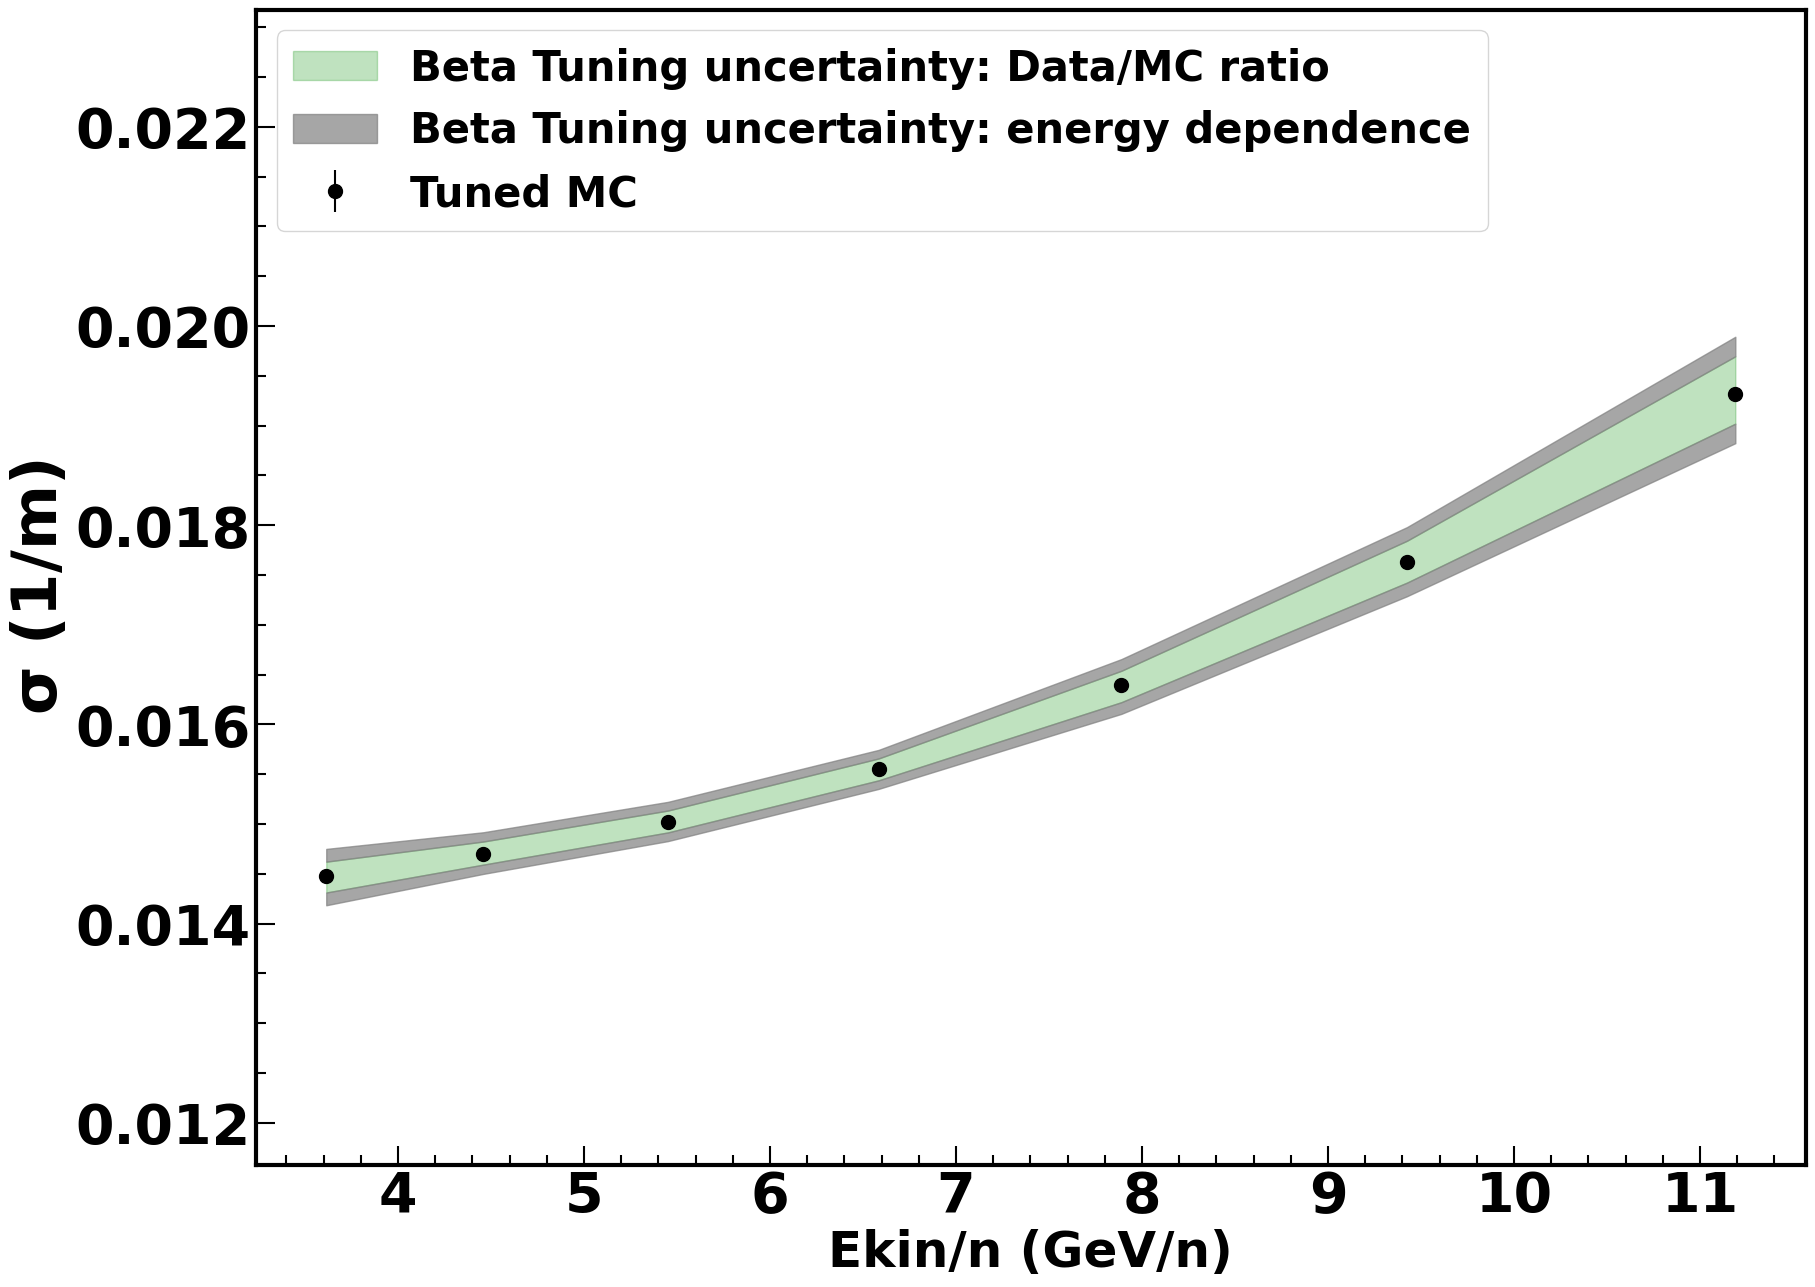

In [14]:

with open('/home/manbing/Documents/Data/data_BeP8/FitParsRange/splines_pars_uncertainty_rigSigma.pkl', 'rb') as file:
    loaddic_rigSigma = pickle.load(file)

import pickle
from scipy.interpolate import  UnivariateSpline

xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
df_graph_parslim = {}
df_graph_parslim_ext = {}

graph_fitlow = {dec:{} for dec in detectors}
graph_fitup = {dec:{} for dec in detectors}
graph_fitlowmax = {dec:{} for dec in detectors}
graph_fitupmax = {dec:{} for dec in detectors}

#print(graph_parsUntuned.items())

filepathTuneMax = {'Tof':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin',
                   'NaF':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedMin_Rebin',
                   'Agl':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedMin_Rebin'}

filepathTune = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin'
graph_MaxScale = {dec:{} for dec in detectors}
graph_MaxScaleLow = {dec:{} for dec in detectors}
graph_MaxScaleUp = {dec:{} for dec in detectors}

graph_TunedBeta0 = {dec:{} for dec in detectors}
graphfitted_TunedBeta0 = {dec:{} for dec in detectors}
ylim_range_be7 = {'mean':[0.145, 0.16], 'sigma':[0.013, 0.021], 'sigma_ratio':[1.6, 2.0], 'asy_factor': [0.8, 1.3], 'fraccore':[0.7, 1.0], "norm":[0, 40]} 
splinefit_uncertainty = {dec:{} for dec in detectors}
splinefit_uncertaintymax = {dec:{} for dec in detectors}
graph_MaxScaleErr = {dec:{} for dec in detectors}
df_graph_parslim_max = {}

for dec in ['Agl']:
    for par in ['sigma']:
        
        fig, ax1 = plt.subplots(1, 1, figsize= FIGSIZE2)
        set_plot_style(ax1) 
        graph_fitlow[dec][par], graph_fitup[dec][par] = plot_errband_constraint(fig, ax1, df_graph_parslim, graph_parsUntuned[dec][par], graph_parsTuned[dec][par],  DETECTOR_COLOR[dec], par, polyfitp0[dec][par])
        splinefit_uncertainty[dec][par] = get_uncertainty_spline(graph_fitlow[dec][par], graph_fitup[dec][par])
        
        
        df_maxscale = np.load(os.path.join(filepathTuneMax[dec], f'df_{par}_{itername}.npz'))
        graph_MaxScale[dec][par] = MGraph.from_file(df_maxscale, f'graph_{par}_{dec}')
        
        df_parT0 = np.load(os.path.join(filepathTune, f'df_{par}_{itername}.npz'))
        graph_TunedBeta0[dec][par] = MGraph.from_file(df_parT0, f'graph_{par}_{dec}')   
        graphfitted_TunedBeta0[dec][par] = GetFitValue(graph_TunedBeta0[dec][par], polyfitp0[dec][par], withsigma=False)
        
        plot_graph(fig, ax1, graphfitted_TunedBeta0[dec][par], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label='Tuned MC')
        graph_MaxScaleLow[dec][par], graph_MaxScaleUp[dec][par] = plot_errband_constraint(fig, ax1, df_graph_parslim_ext, graph_MaxScale[dec][par], graph_parsUntuned[dec][par], 'grey', par, polyfitp0[dec][par], withsig=False)
        graph_MaxScaleErr[dec][par] = getgrapherr_fromLowUp(graph_MaxScaleLow[dec][par], graph_MaxScaleUp[dec][par])
       
        #First Err
        ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 1.0 * graph_MaxScaleErr[dec][par].yvalues , 1.0 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues, color=DETECTOR_COLOR[dec], alpha=0.3, label=r'Beta Tuning uncertainty: Data/MC ratio')
        #Second Err
        ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.65 * graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues -  graph_MaxScaleErr[dec][par].yvalues , color='grey', alpha=0.7, label=r'Beta Tuning uncertainty: energy dependence')
        ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues , 2.65 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues,  color='grey', alpha=0.7)
        
        plt.subplots_adjust(hspace=.0)                                                                                                                                                                                                                                                                                                                                            
        ax1.set_xlabel("Ekin/n (GeV/n)")  
        ax1.set_ylim([0.8 * min(graphfitted_TunedBeta0[dec][par].yvalues), 1.2 *max(graphfitted_TunedBeta0[dec][par].yvalues)] )
        
        ax1.set_ylabel(f'{par_names_axes[par]} (1/m)', fontsize=fontsize1)
        
        graph_fitlowmax[dec][par] = MGraph(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.65 * graph_MaxScaleErr[dec][par].yvalues, np.zeros_like(graph_MaxScaleErr[dec][par].xvalues))
        graph_fitupmax[dec][par] = MGraph(graph_MaxScaleErr[dec][par].xvalues, graph_fitup[dec][par].yvalues + 2.65 * graph_MaxScaleErr[dec][par].yvalues, np.zeros_like(graph_MaxScaleErr[dec][par].xvalues))
        graph_fitlowmax[dec][par].add_to_file(df_graph_parslim_max, f'graph_{par}low_{dec}')
        graph_fitupmax[dec][par].add_to_file(df_graph_parslim_max, f'graph_{par}up_{dec}')
        splinefit_uncertaintymax[dec][par] = get_uncertainty_spline(graph_fitlowmax[dec][par], graph_fitupmax[dec][par])
        
        #######################################################
        #Draw the uncertainty from Rig if rig sigma core +/- 5%
        #######################################################
        print(loaddic_rigSigma.items())
        rigSigErr = loaddic_rigSigma[dec][par](np.log(graph_MaxScaleErr[dec][par].xvalues))
        lowPile2 = graph_fitlow[dec][par].yvalues - 2.65 * graph_MaxScaleErr[dec][par].yvalues 
        upPile2 = 2.65 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues
        graphfitted_TunedBeta0
        
        ax1.legend(loc='upper left', fontsize=30)
        set_plot_style(ax1)
        
        savefig_tofile(fig, plotfile, f'fitrange_{dec}_{par}_Err2', 1)
    
np.savez(os.path.join('/home/manbing/Documents/Data/data_BeP8', 'graph_parslim_TunedUncertainty.npz'), **df_graph_parslim_max)




In [8]:
import pickle
from scipy.interpolate import  UnivariateSpline

xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
df_graph_parslim = {}
df_graph_parslim_ext = {}

graph_fitlow = {dec:{} for dec in detectors}
graph_fitup = {dec:{} for dec in detectors}
graph_fitlowmax = {dec:{} for dec in detectors}
graph_fitupmax = {dec:{} for dec in detectors}

#print(graph_parsUntuned.items())

filepathTuneMax = {'Tof':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin',
                   'NaF':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedMin_Rebin',
                   'Agl':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedMin_Rebin'}

filepathTune = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin'
graph_MaxScale = {dec:{} for dec in detectors}
graph_MaxScaleLow = {dec:{} for dec in detectors}
graph_MaxScaleUp = {dec:{} for dec in detectors}

graph_TunedBeta0 = {dec:{} for dec in detectors}
graphfitted_TunedBeta0 = {dec:{} for dec in detectors}
ylim_range_be7 = {'mean':[0.145, 0.16], 'sigma':[0.013, 0.021], 'sigma_ratio':[1.6, 2.0], 'asy_factor': [0.8, 1.3], 'fraccore':[0.7, 1.0], "norm":[0, 40]} 
splinefit_uncertainty = {dec:{} for dec in detectors}
splinefit_uncertaintymax = {dec:{} for dec in detectors}
graph_MaxScaleErr = {dec:{} for dec in detectors}
df_graph_parslim_max = {}


######################################################
#read the rig uncertainty
######################################################
with open('/home/manbing/Documents/Data/data_BeP8/FitParsRange/splines_pars_uncertainty_rigTail.pkl', 'rb') as file:
    loaddic_rigTail_uncertainty = pickle.load(file)
    print(loaddic_rigTail_uncertainty.items())

with open('/home/manbing/Documents/Data/data_BeP8/FitParsRange/splines_pars_uncertainty_rigSigma.pkl', 'rb') as file:
    loaddic_rigSigma = pickle.load(file)

for dec in ['Tof', 'NaF', 'Agl']:
    for par in parnames:
     
   
        graph_fitlow[dec][par], graph_fitup[dec][par] = plot_errband_constraint(fig, ax1, df_graph_parslim, graph_parsUntuned[dec][par], graph_parsTuned[dec][par],  DETECTOR_COLOR[dec], par, polyfitp0[dec][par])
        #print(dec, par)
        #print(((graph_fitup[dec][par].yvalues - graph_fitlow[dec][par].yvalues)* 0.5)/((graph_fitlow[dec][par].yvalues + graph_fitup[dec][par].yvalues) *0.5))
        splinefit_uncertainty[dec][par] = get_uncertainty_spline(graph_fitlow[dec][par], graph_fitup[dec][par])
        
        
        df_maxscale = np.load(os.path.join(filepathTuneMax[dec], f'df_{par}_{itername}.npz'))
        graph_MaxScale[dec][par] = MGraph.from_file(df_maxscale, f'graph_{par}_{dec}')
        
        df_parT0 = np.load(os.path.join(filepathTune, f'df_{par}_{itername}.npz'))
        graph_TunedBeta0[dec][par] = MGraph.from_file(df_parT0, f'graph_{par}_{dec}')   
        graphfitted_TunedBeta0[dec][par] = GetFitValue(graph_TunedBeta0[dec][par], polyfitp0[dec][par], withsigma=False)
       
        #graph_MaxScaleLow[dec][par], graph_MaxScaleUp[dec][par] = getgraph_errband(graph_MaxScale[dec][par], par, polyfitp0[dec][par])
        graph_MaxScaleLow[dec][par], graph_MaxScaleUp[dec][par] = plot_errband_constraint(fig, ax1, df_graph_parslim_ext, graph_MaxScale[dec][par], graph_parsUntuned[dec][par], 'grey', par, polyfitp0[dec][par], withsig=False)
        
        #graph_MaxScaleErr[dec][par] = getgrapherr(graph_MaxScale[dec][par],  par, polyfitp0[dec][par], withsig=False)
        graph_MaxScaleErr[dec][par] = getgrapherr_fromLowUp(graph_MaxScaleLow[dec][par], graph_MaxScaleUp[dec][par])
       
        

for dec in detectors:
    for par in parnames:
        if par == 'sigma':
            rigErr = loaddic_rigSigma[dec][par](np.log(graph_MaxScaleErr[dec][par].xvalues))
        else:
            rigErr = loaddic_rigTail_uncertainty[dec][par](np.log(graph_MaxScaleErr[dec][par].xvalues))
        graph_fitlowmax[dec][par] = MGraph(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.65 * graph_MaxScaleErr[dec][par].yvalues -rigErr, np.zeros_like(graph_MaxScaleErr[dec][par].xvalues))
        graph_fitupmax[dec][par] = MGraph(graph_MaxScaleErr[dec][par].xvalues, graph_fitup[dec][par].yvalues + 2.65 * graph_MaxScaleErr[dec][par].yvalues + rigErr, np.zeros_like(graph_MaxScaleErr[dec][par].xvalues))
        graph_fitlowmax[dec][par].add_to_file(df_graph_parslim_max, f'graph_{par}low_{dec}')
        graph_fitupmax[dec][par].add_to_file(df_graph_parslim_max, f'graph_{par}up_{dec}')
        splinefit_uncertaintymax[dec][par] = get_uncertainty_spline(graph_fitlowmax[dec][par], graph_fitupmax[dec][par])
        
        fig, ax1 = plt.subplots(1, 1, figsize=(24, 18)) 
        plot_graph(fig, ax1, graphfitted_TunedBeta0[dec][par], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label='Tuned MC')
        ax1.fill_between(graph_fitlow[dec][par].xvalues, graph_fitlow[dec][par].yvalues, graph_fitup[dec][par].yvalues , color=DETECTOR_COLOR[dec], alpha=0.3, label=r'Tuning uncertainty of Data/MC ratio')
        #ax1.fill_between(graph_MaxScaleLow[dec][par].xvalues, graph_MaxScaleLow[dec][par].yvalues, graph_MaxScaleUp[dec][par].yvalues , color="grey", alpha=0.3, label=r'uncertainty from MC $\mathrm{\sigma_{\beta}}$ at R>200GV')
        ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 1.0 * graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues , color='grey', alpha=0.7, label=r'Tuning uncertainty of Data/MC ratio')
        ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitup[dec][par].yvalues, 1.0 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues , color='grey', alpha=0.7)
        ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2 * graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues -  graph_MaxScaleErr[dec][par].yvalues , color='grey', alpha=0.3, label=r'Tuning uncertainty due to energy dependence')
        ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues , 2 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues,  color='grey', alpha=0.3)
        
        ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlowmax[dec][par].yvalues, graph_fitlow[dec][par].yvalues -  2 *graph_MaxScaleErr[dec][par].yvalues , color='tab:blue', alpha=0.3, label=r'Rig Uncertainty')
        ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, 2 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues , graph_fitupmax[dec][par].yvalues,  color='tab:blue', alpha=0.3)
        plt.subplots_adjust(hspace=.0)                                                                                                                                                                                                                                                                                                                                            
        ax1.set_xlabel("Ekin/n (GeV/n)")  
        ax1.set_ylim([0.8 * min(graphfitted_TunedBeta0[dec][par].yvalues), 1.2 *max(graphfitted_TunedBeta0[dec][par].yvalues)] )
        #ax1.set_ylim(ylim_range_be7[par])
        ax1.set_xscale('log')
        ax1.legend(loc='upper left', fontsize=33)
        ax1.set_ylabel(f'{par_names_axes[par]}', fontsize=fontsize1)
        savefig_tofile(fig, plotfile, f'fitrange_{dec}_{par}', 1)

with open('/home/manbing/Documents/Data/data_BeP8/splines_pars_uncertainty.pkl', 'wb') as file:
    pickle.dump(splinefit_uncertainty, file)
    
with open('/home/manbing/Documents/Data/data_BeP8/splines_pars_uncertaintymax_BetaRig.pkl', 'wb') as file:
    pickle.dump(splinefit_uncertaintymax, file)
    
#print(splinefit_uncertaintymax.items())
with open('/home/manbing/Documents/Data/data_BeP8/splines_pars_uncertaintymax_BetaRig.pkl', 'rb') as file:
    loaddic = pickle.load(file)
    print(loaddic['Agl']['sigma'](np.log(graph_MaxScaleErr['Agl']['sigma'].xvalues)))
    
np.savez(os.path.join('/home/manbing/Documents/Data/data_BeP8', 'graph_parslim_TunedUncertainty.npz'), **df_graph_parslim_max)




dict_items([('Tof', {'mean': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7814c8cb3790>, 'sigma': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7814c8cb31c0>, 'fraccore': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7813b7235db0>, 'sigma_ratio': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7813b72359f0>, 'asy_factor': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7813b7235630>}), ('NaF', {'mean': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7813b7235270>, 'sigma': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7813b7234eb0>, 'fraccore': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7813b7234b20>, 'sigma_ratio': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7813b7234730>, 'asy_factor': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7813b7234370>}), ('Agl', {'mean': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7813b7244370

NameError: name 'plot_errband_constraint' is not defined

dict_items([('Tof', {'mean': <tools.graphs.MGraph object at 0x7efbdbd6b310>, 'sigma': <tools.graphs.MGraph object at 0x7efbdbcd1630>, 'fraccore': <tools.graphs.MGraph object at 0x7efbdb702950>, 'sigma_ratio': <tools.graphs.MGraph object at 0x7efbce907910>, 'asy_factor': <tools.graphs.MGraph object at 0x7efbce913e80>}), ('NaF', {'mean': <tools.graphs.MGraph object at 0x7efbdbd6b0d0>, 'sigma': <tools.graphs.MGraph object at 0x7efbdbcebfd0>, 'fraccore': <tools.graphs.MGraph object at 0x7efbce907100>, 'sigma_ratio': <tools.graphs.MGraph object at 0x7efbce8feb60>, 'asy_factor': <tools.graphs.MGraph object at 0x7efbce8ff4c0>}), ('Agl', {'mean': <tools.graphs.MGraph object at 0x7efbdbce81c0>, 'sigma': <tools.graphs.MGraph object at 0x7efbdb703fa0>, 'fraccore': <tools.graphs.MGraph object at 0x7efbd0263ac0>, 'sigma_ratio': <tools.graphs.MGraph object at 0x7efbce913460>, 'asy_factor': <tools.graphs.MGraph object at 0x7efbce913df0>})])

xvalues			yvalues			yerrs
3.61425			0.1527830810842475			0.

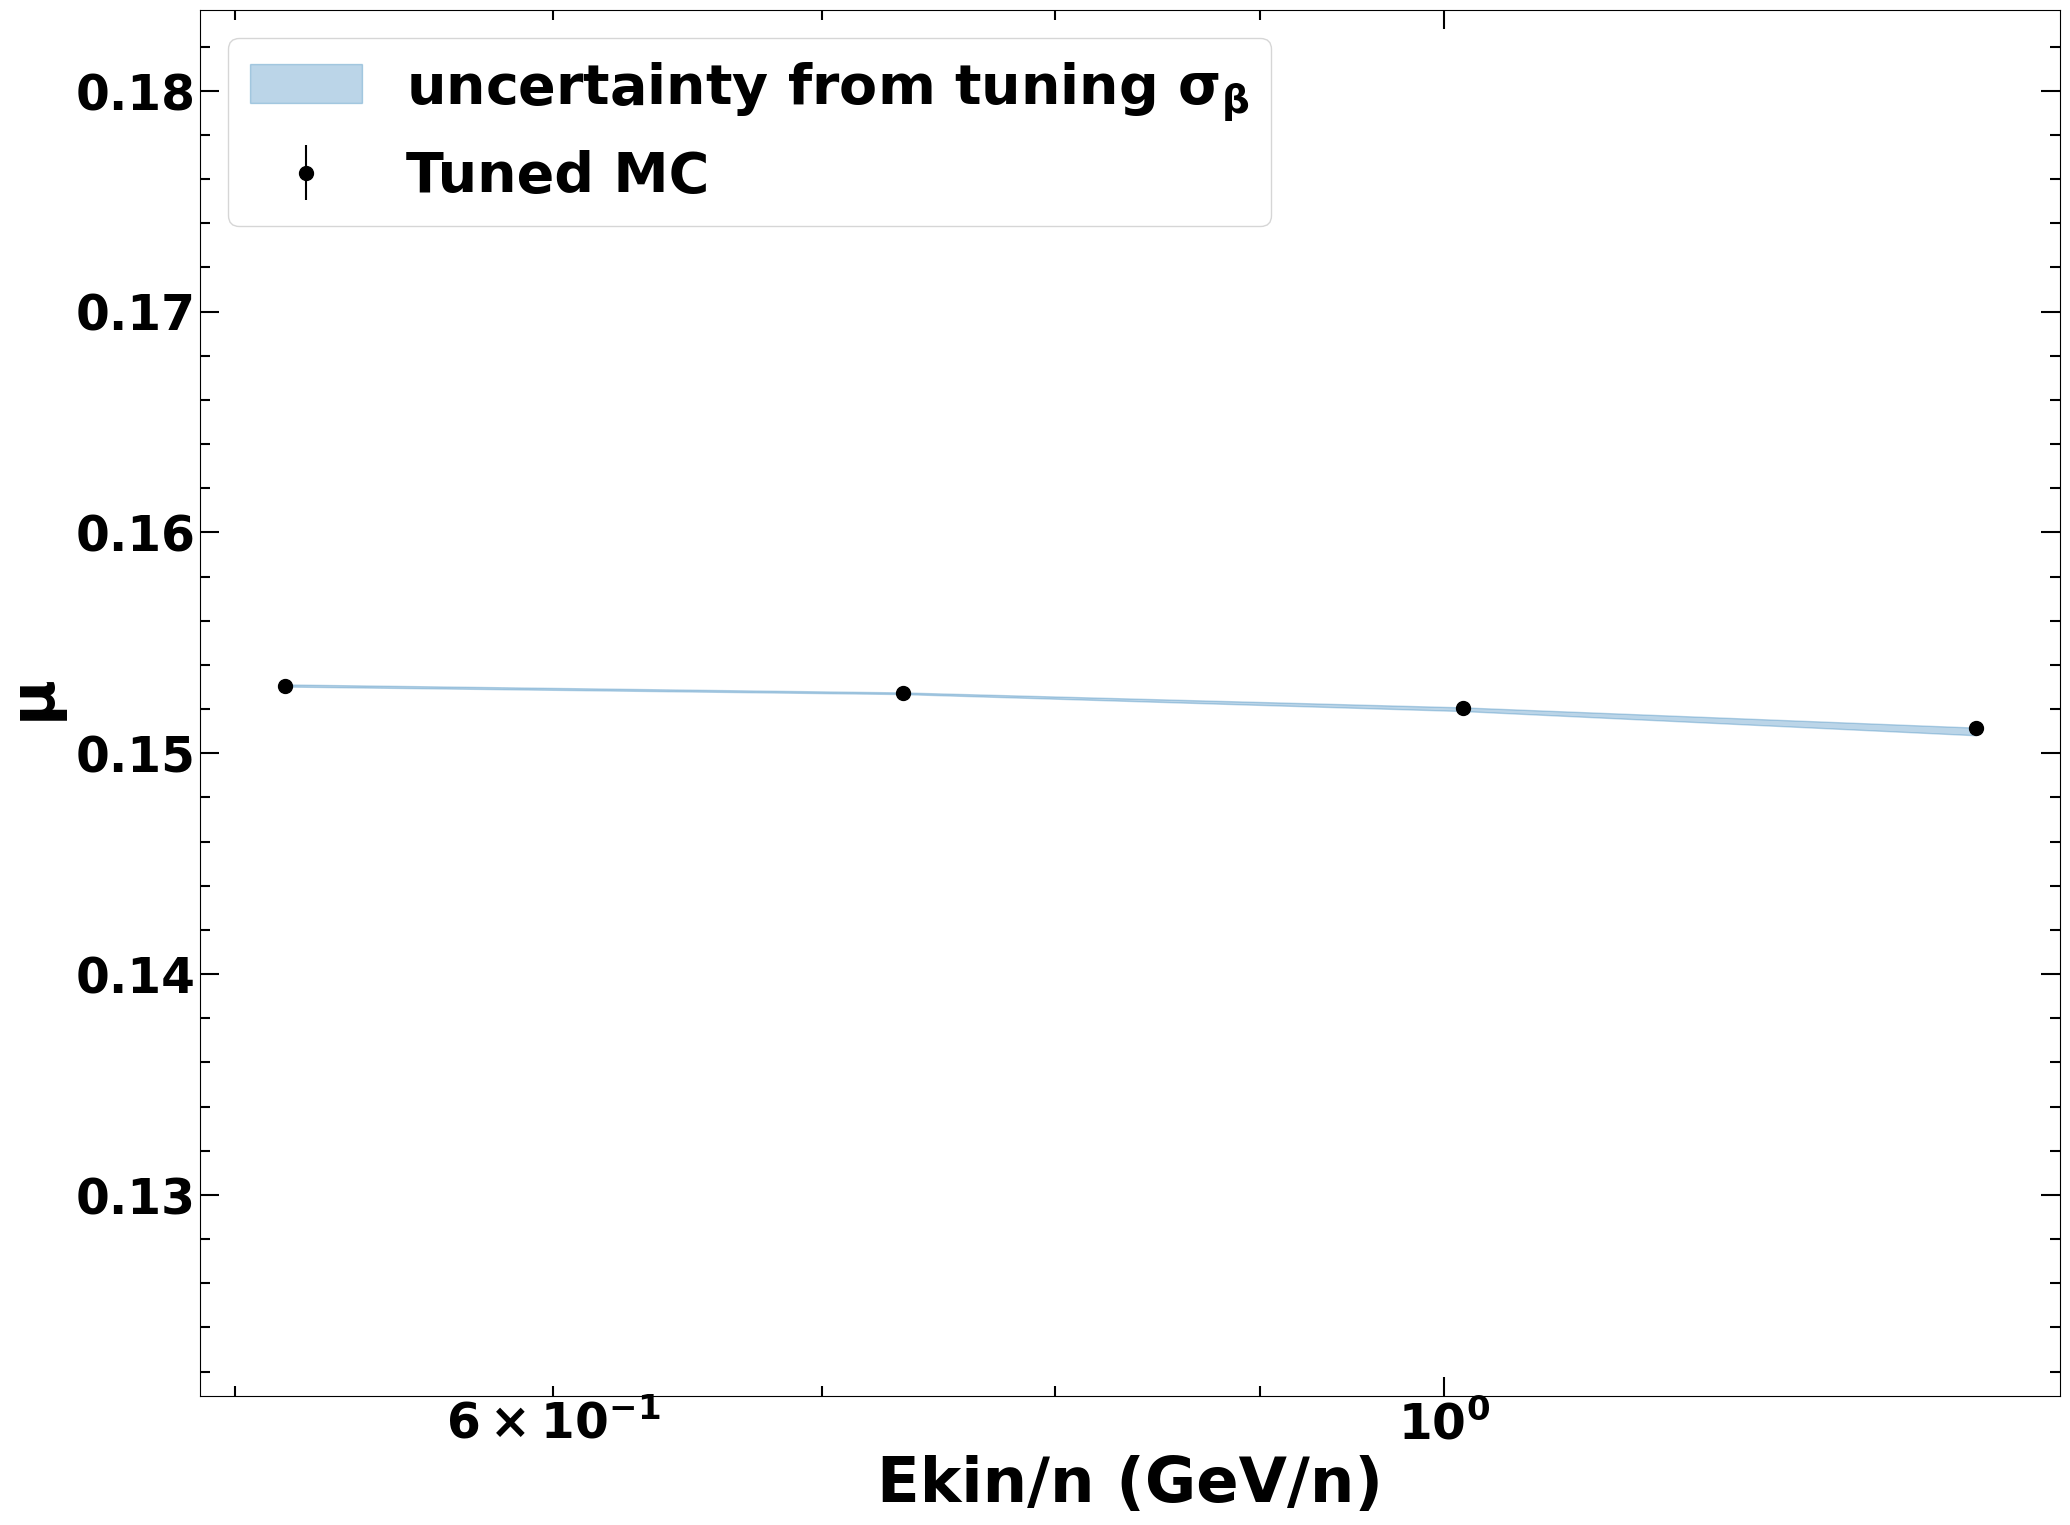

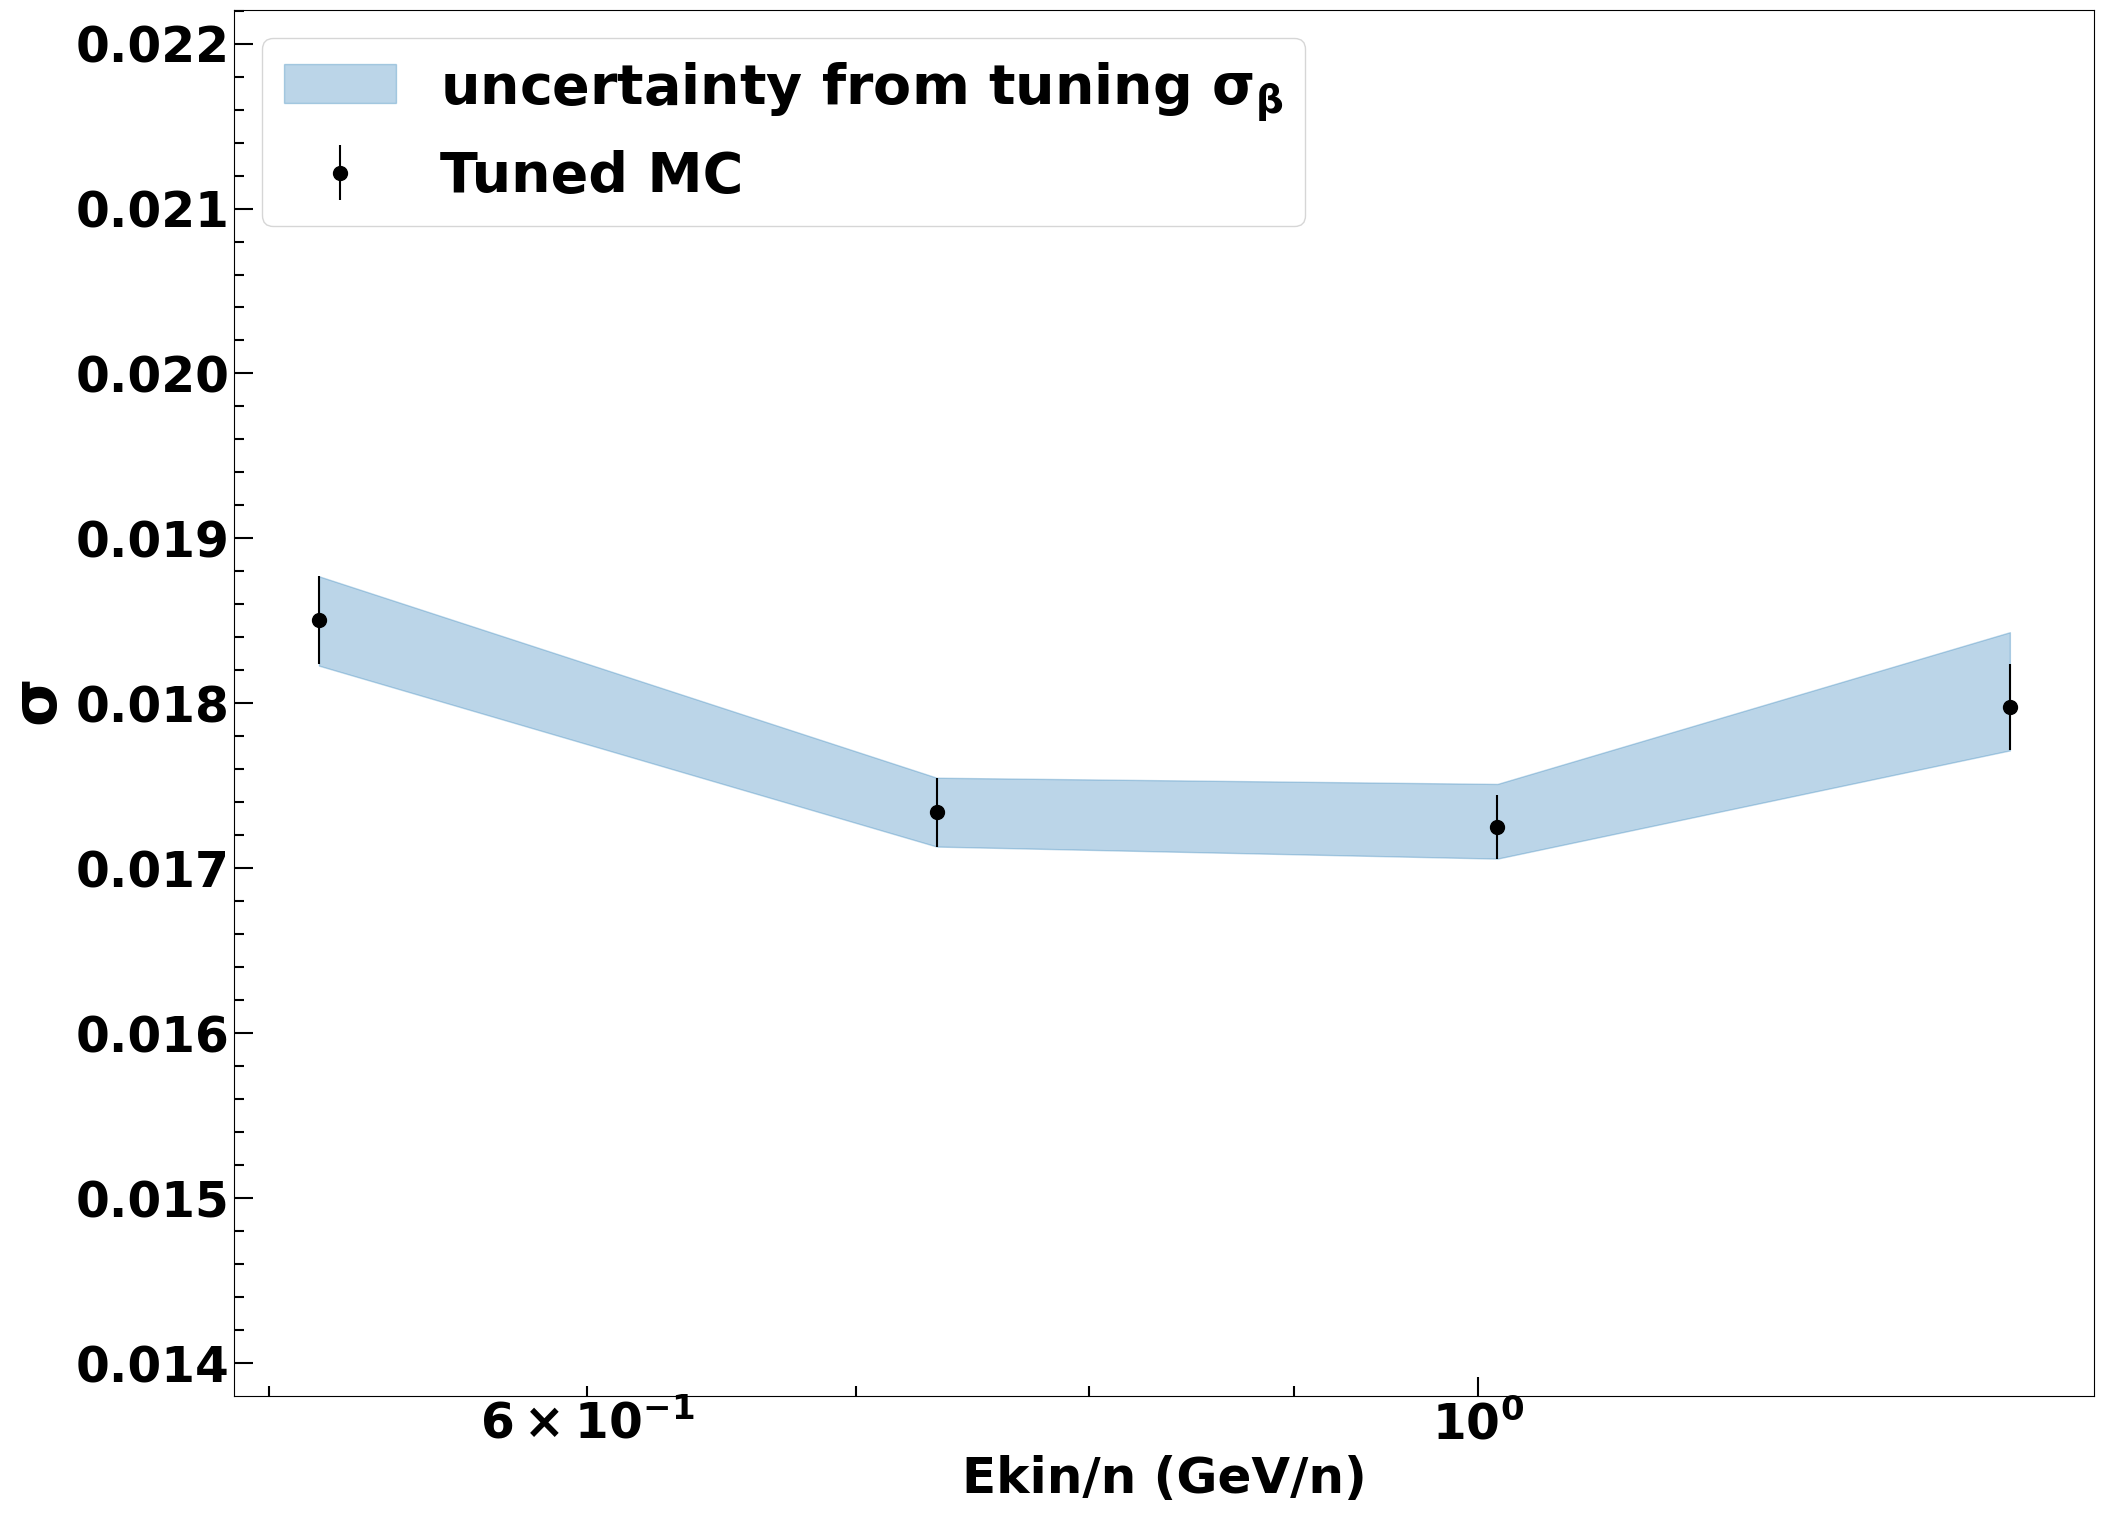

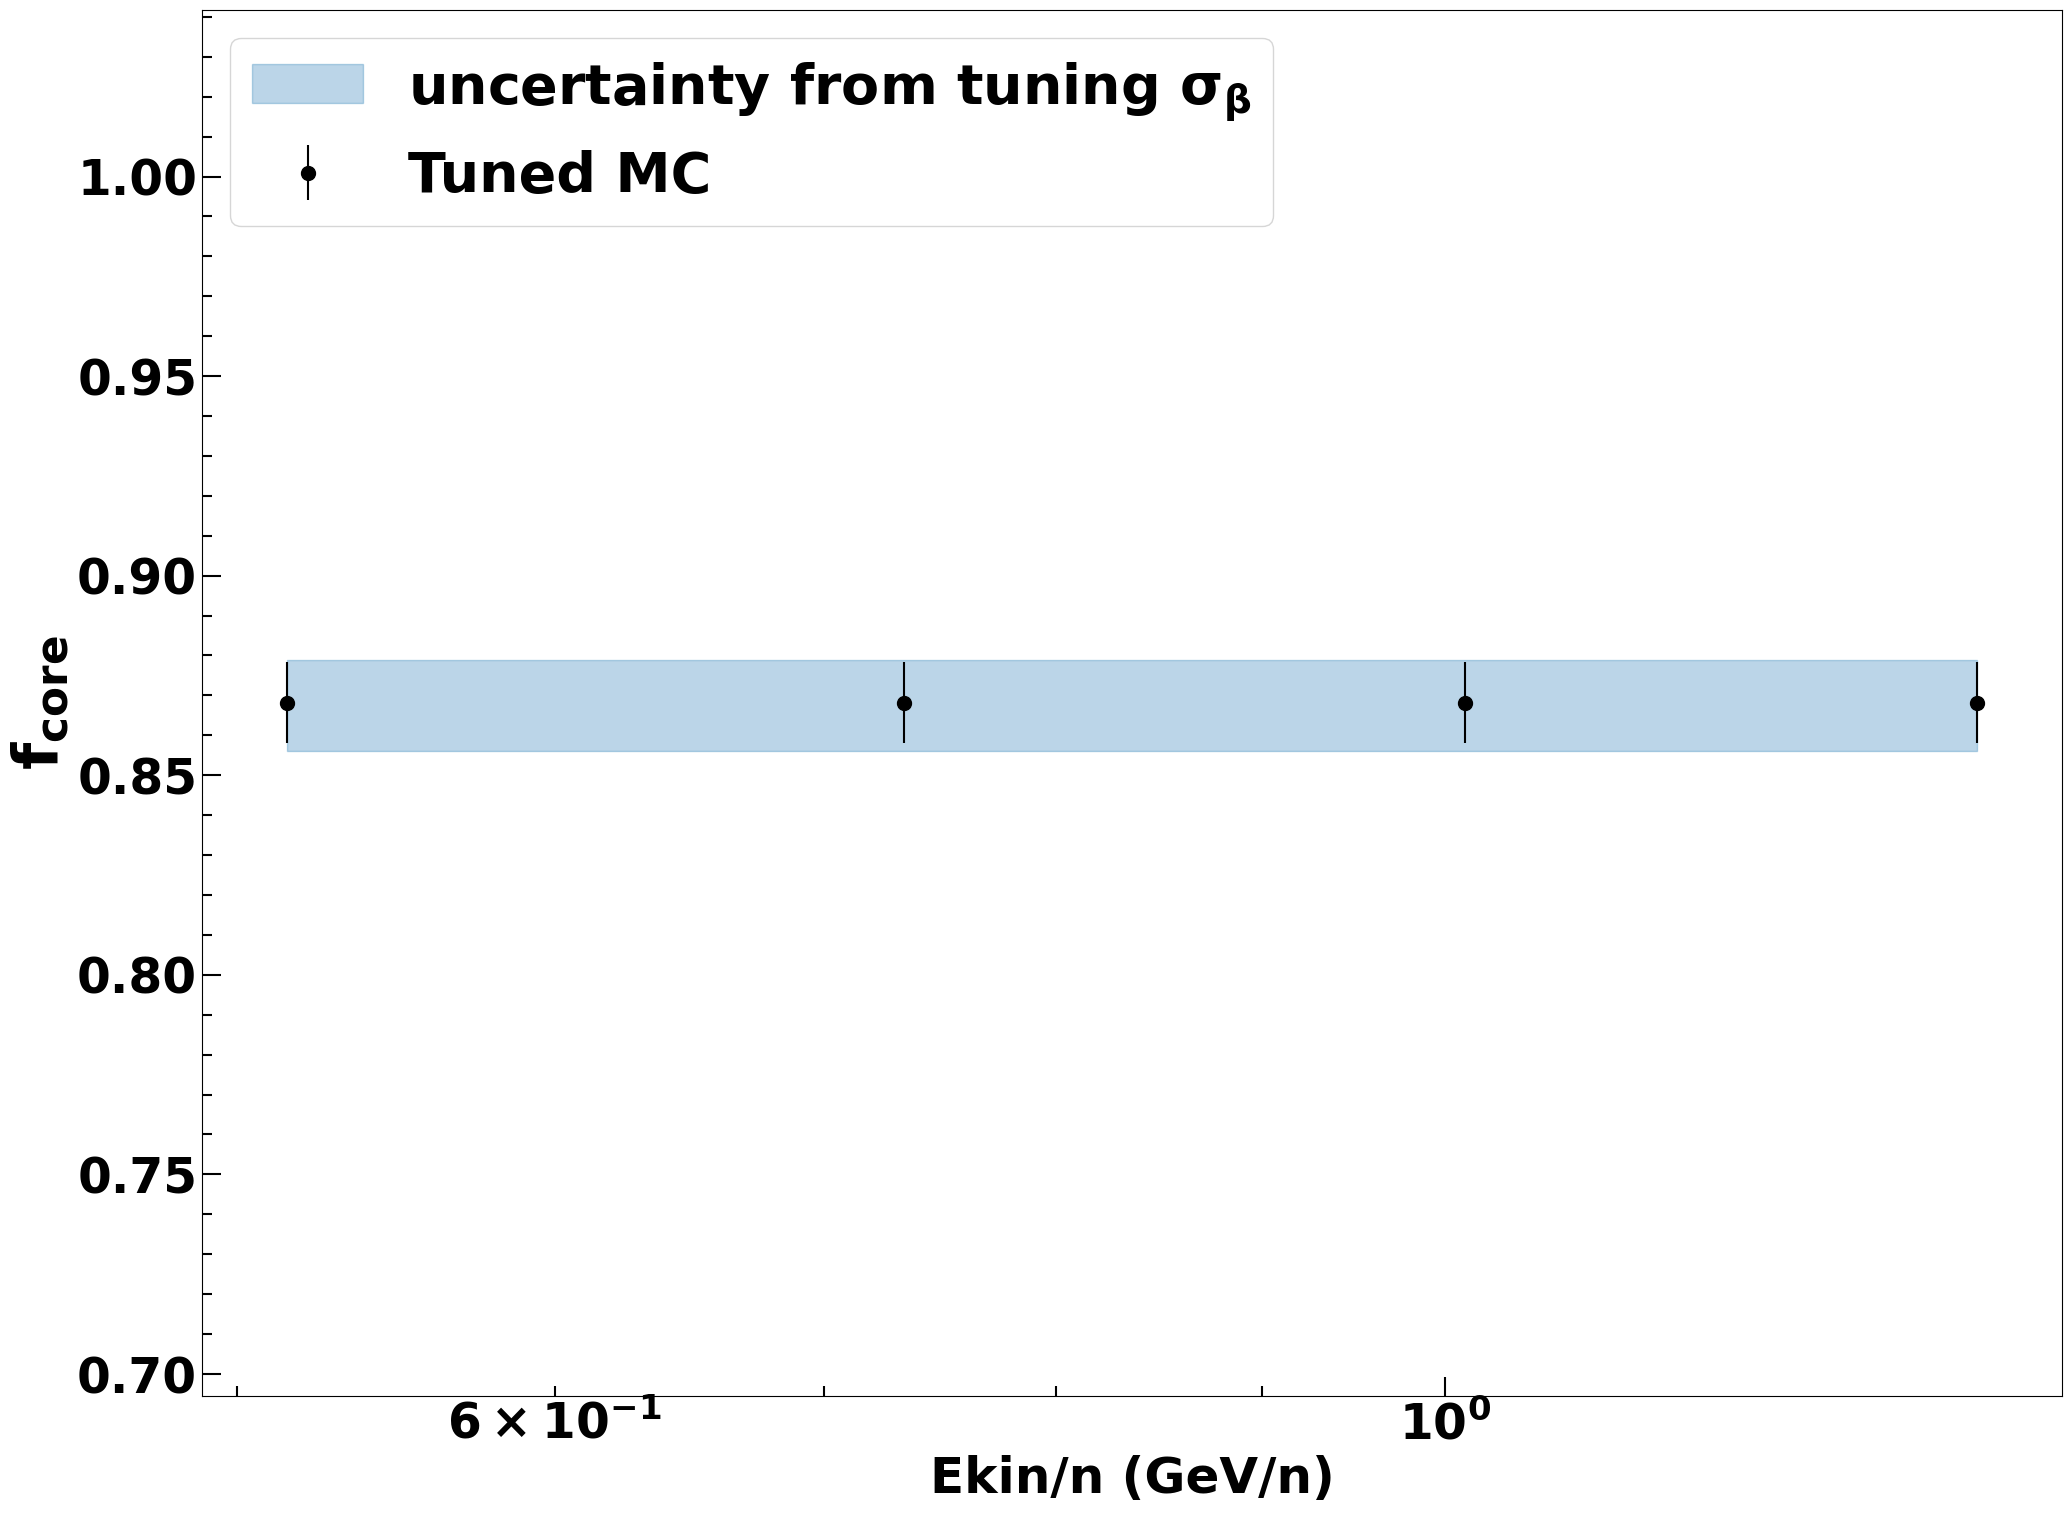

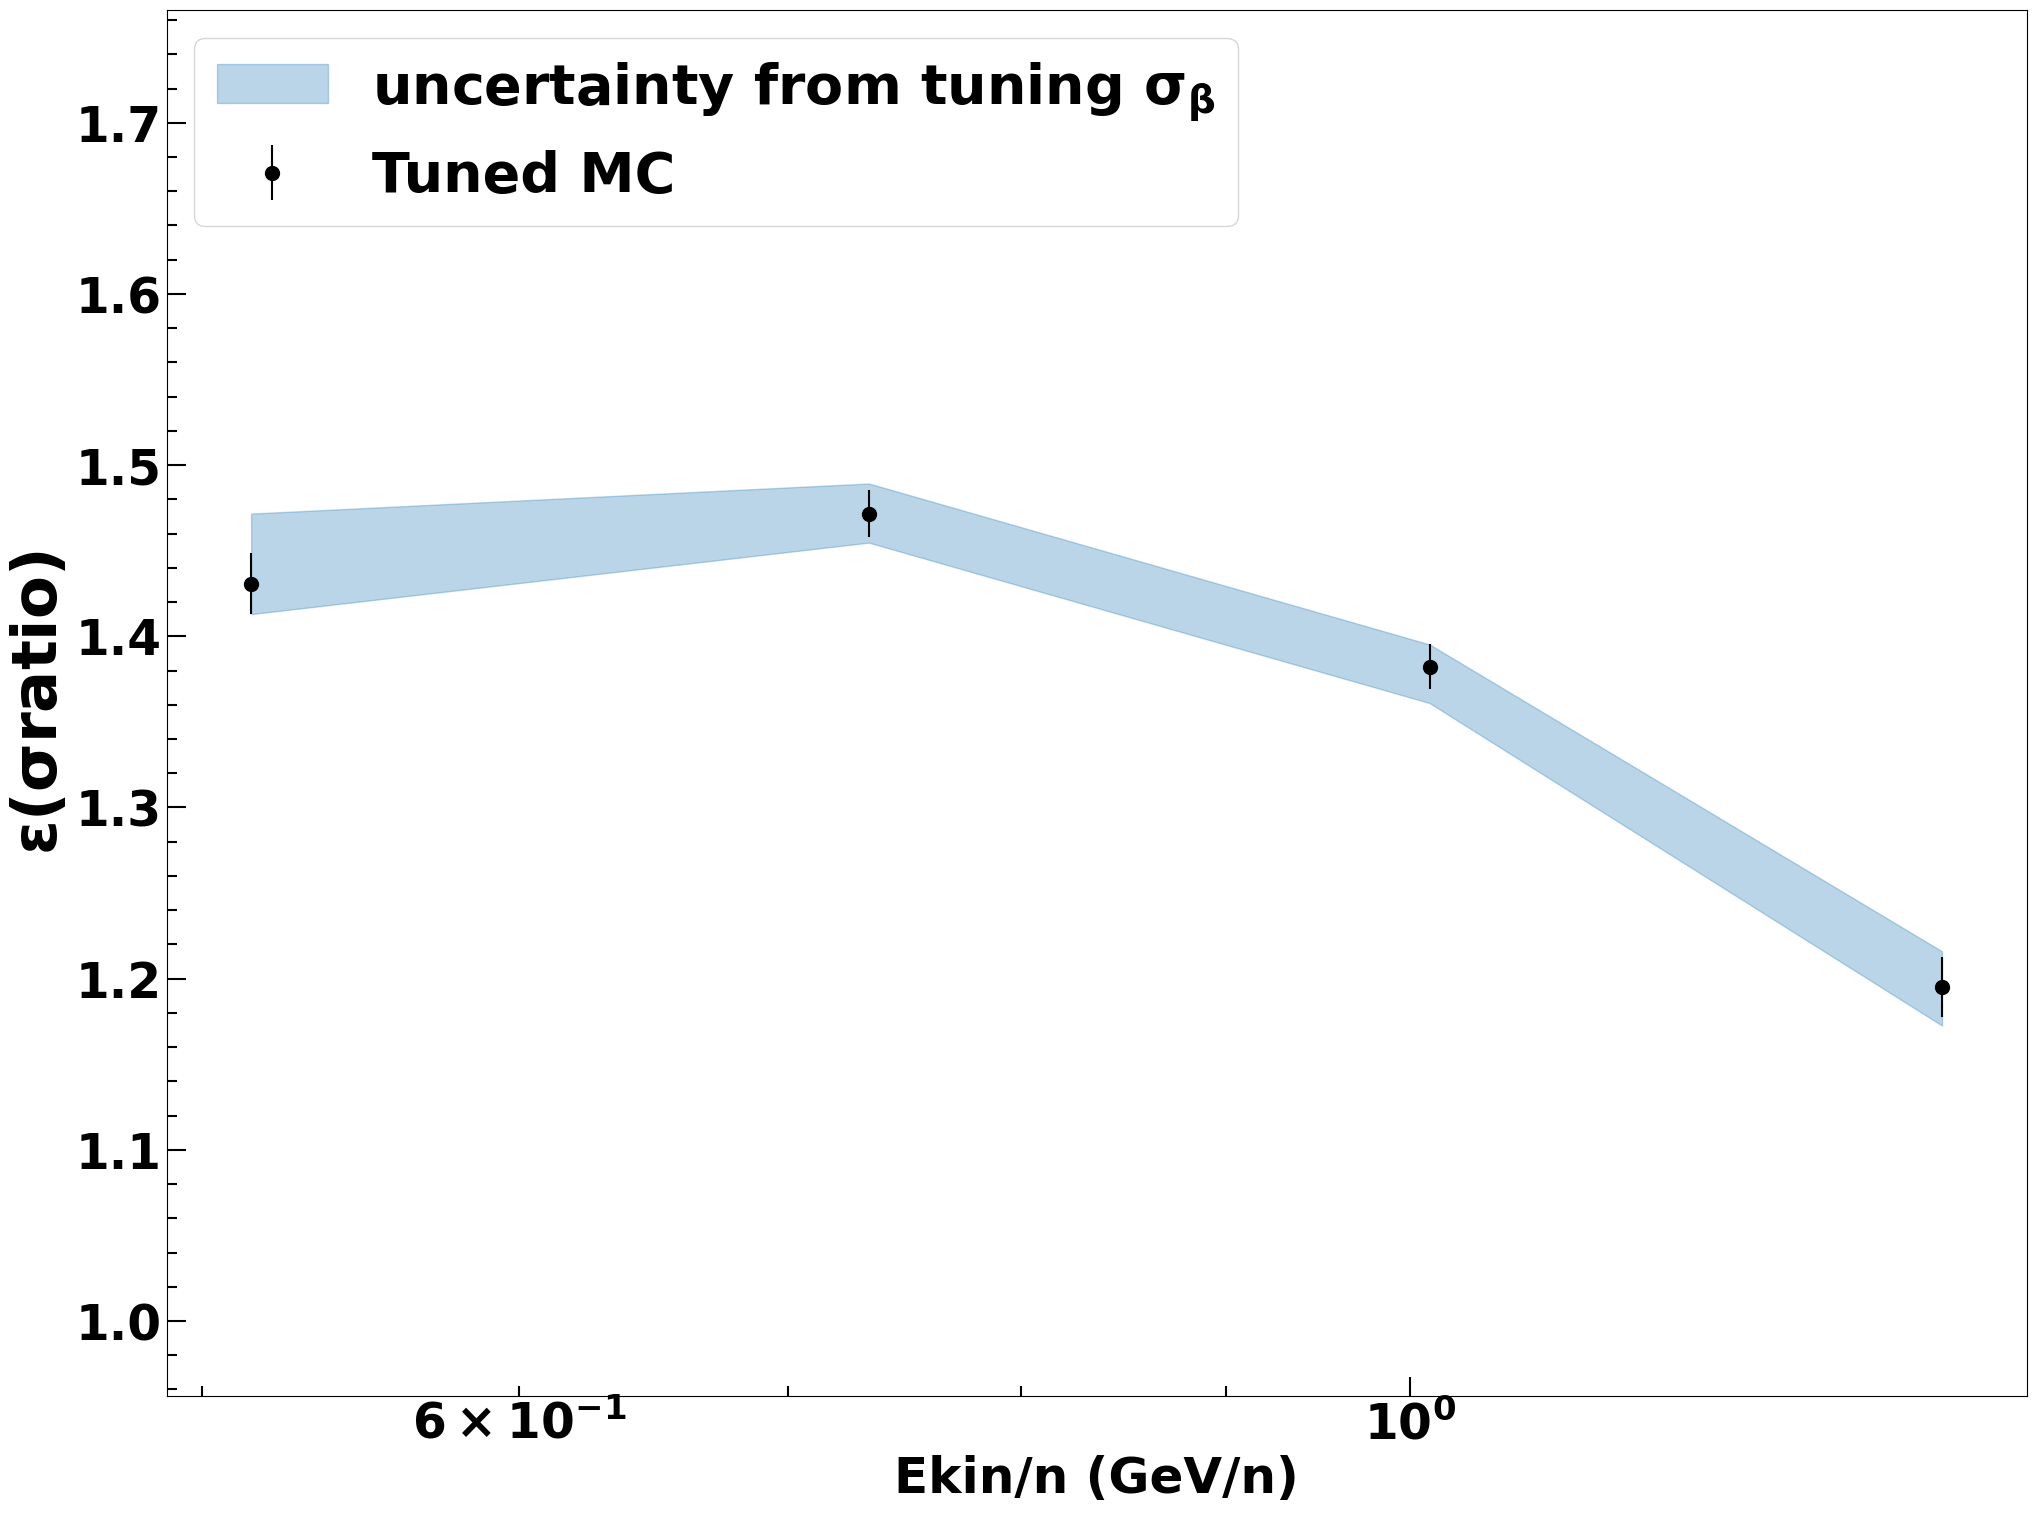

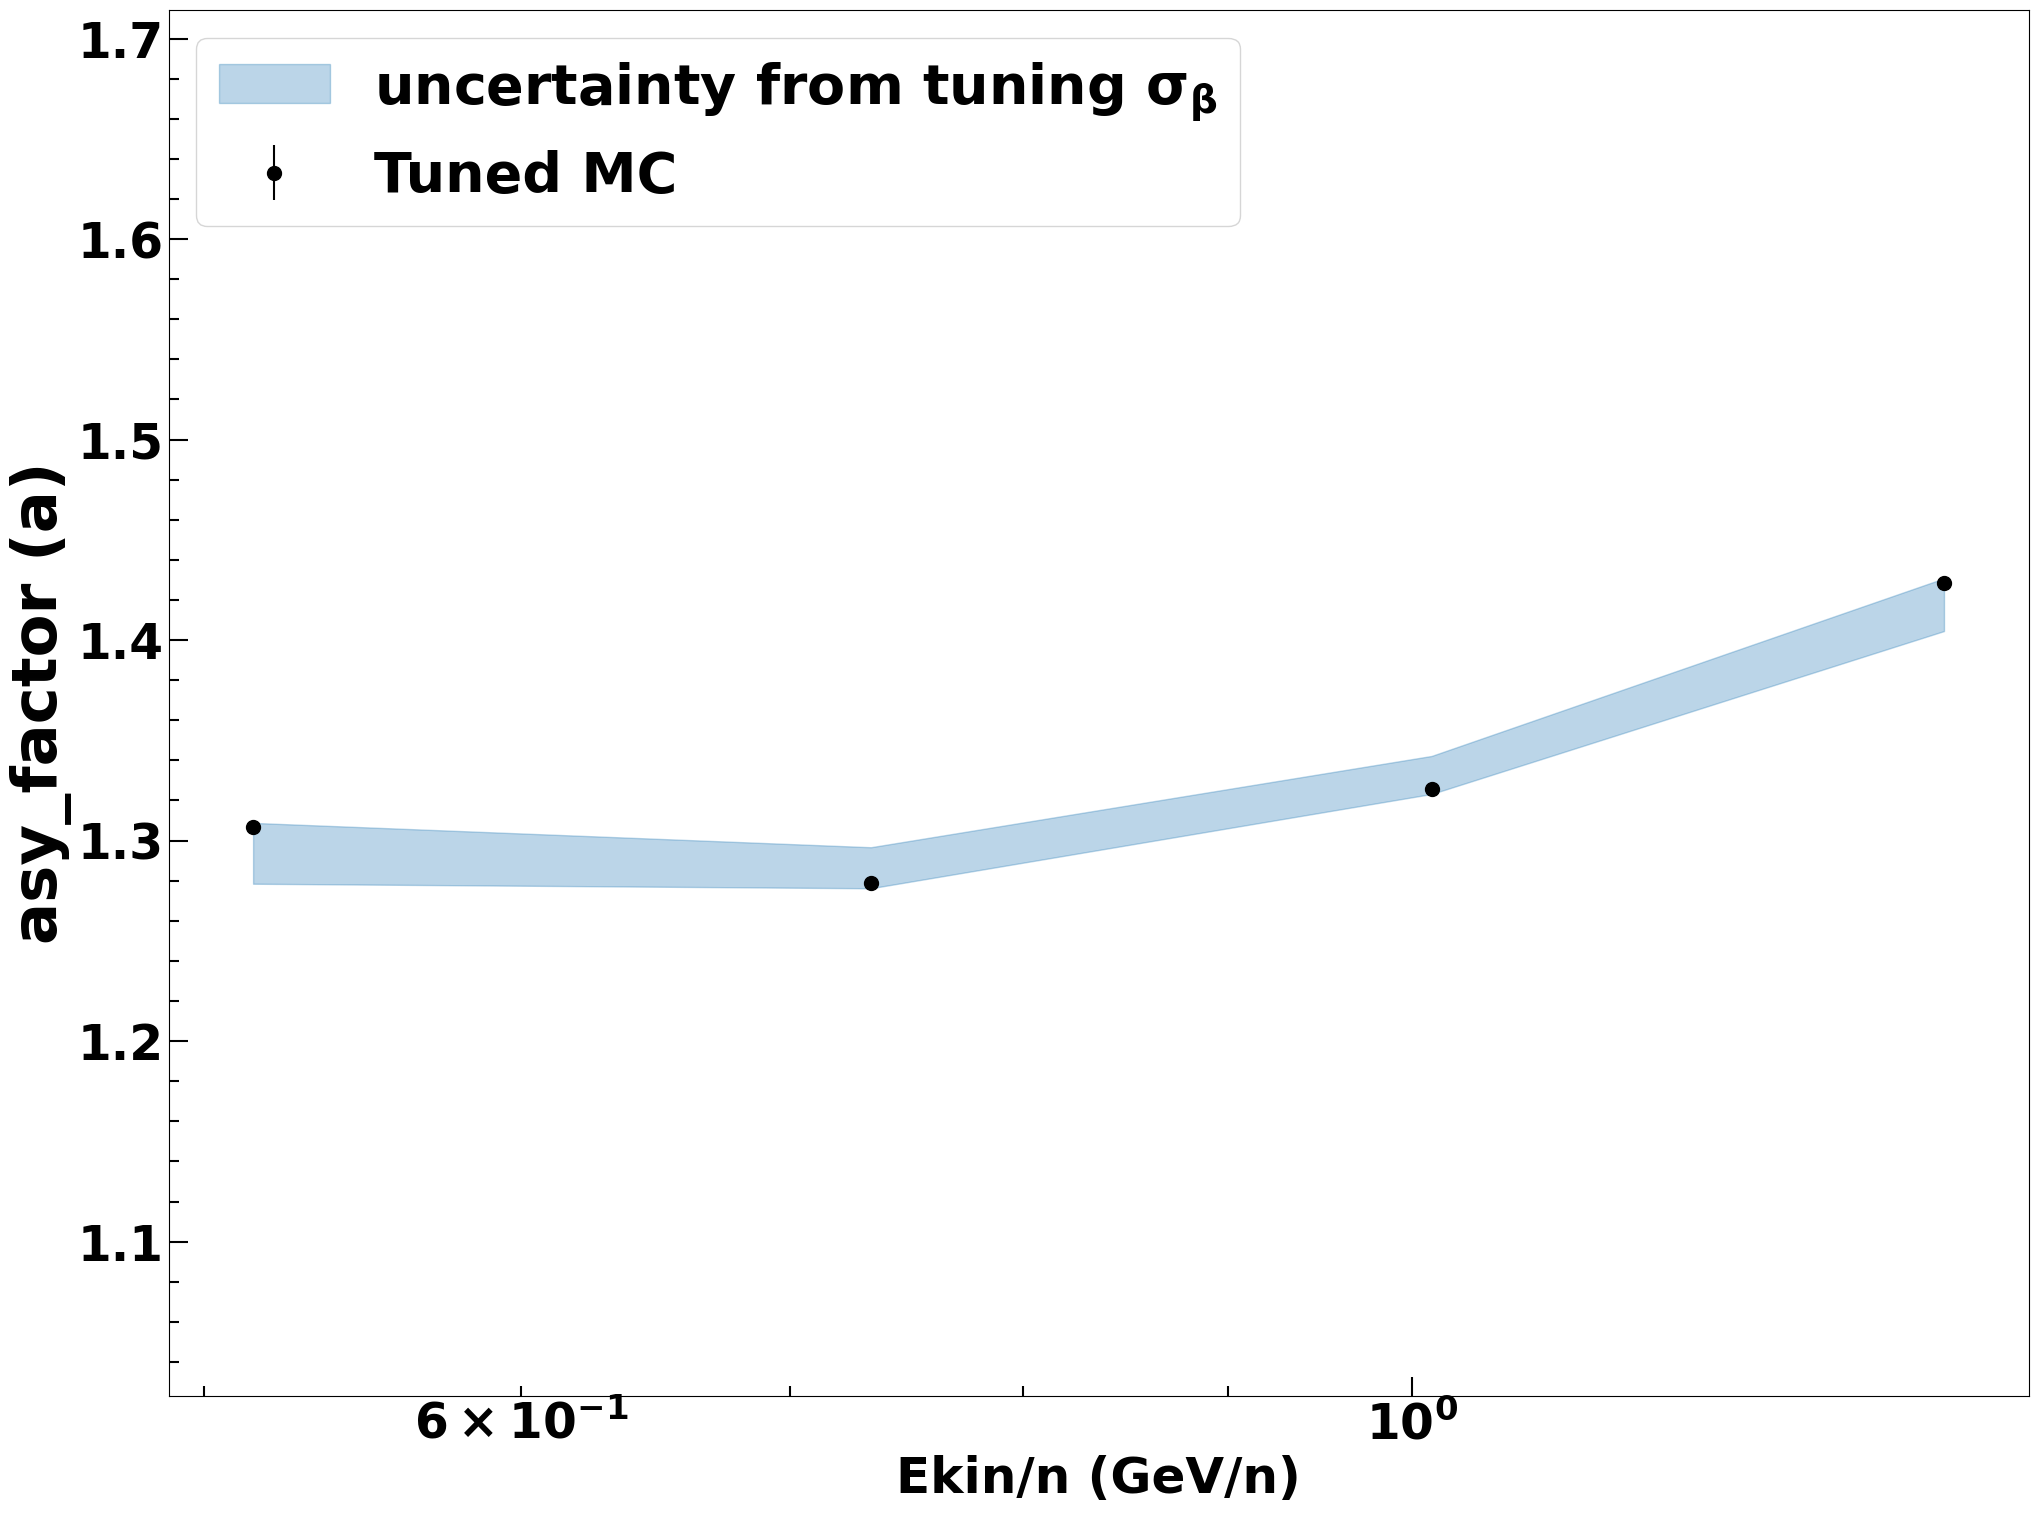

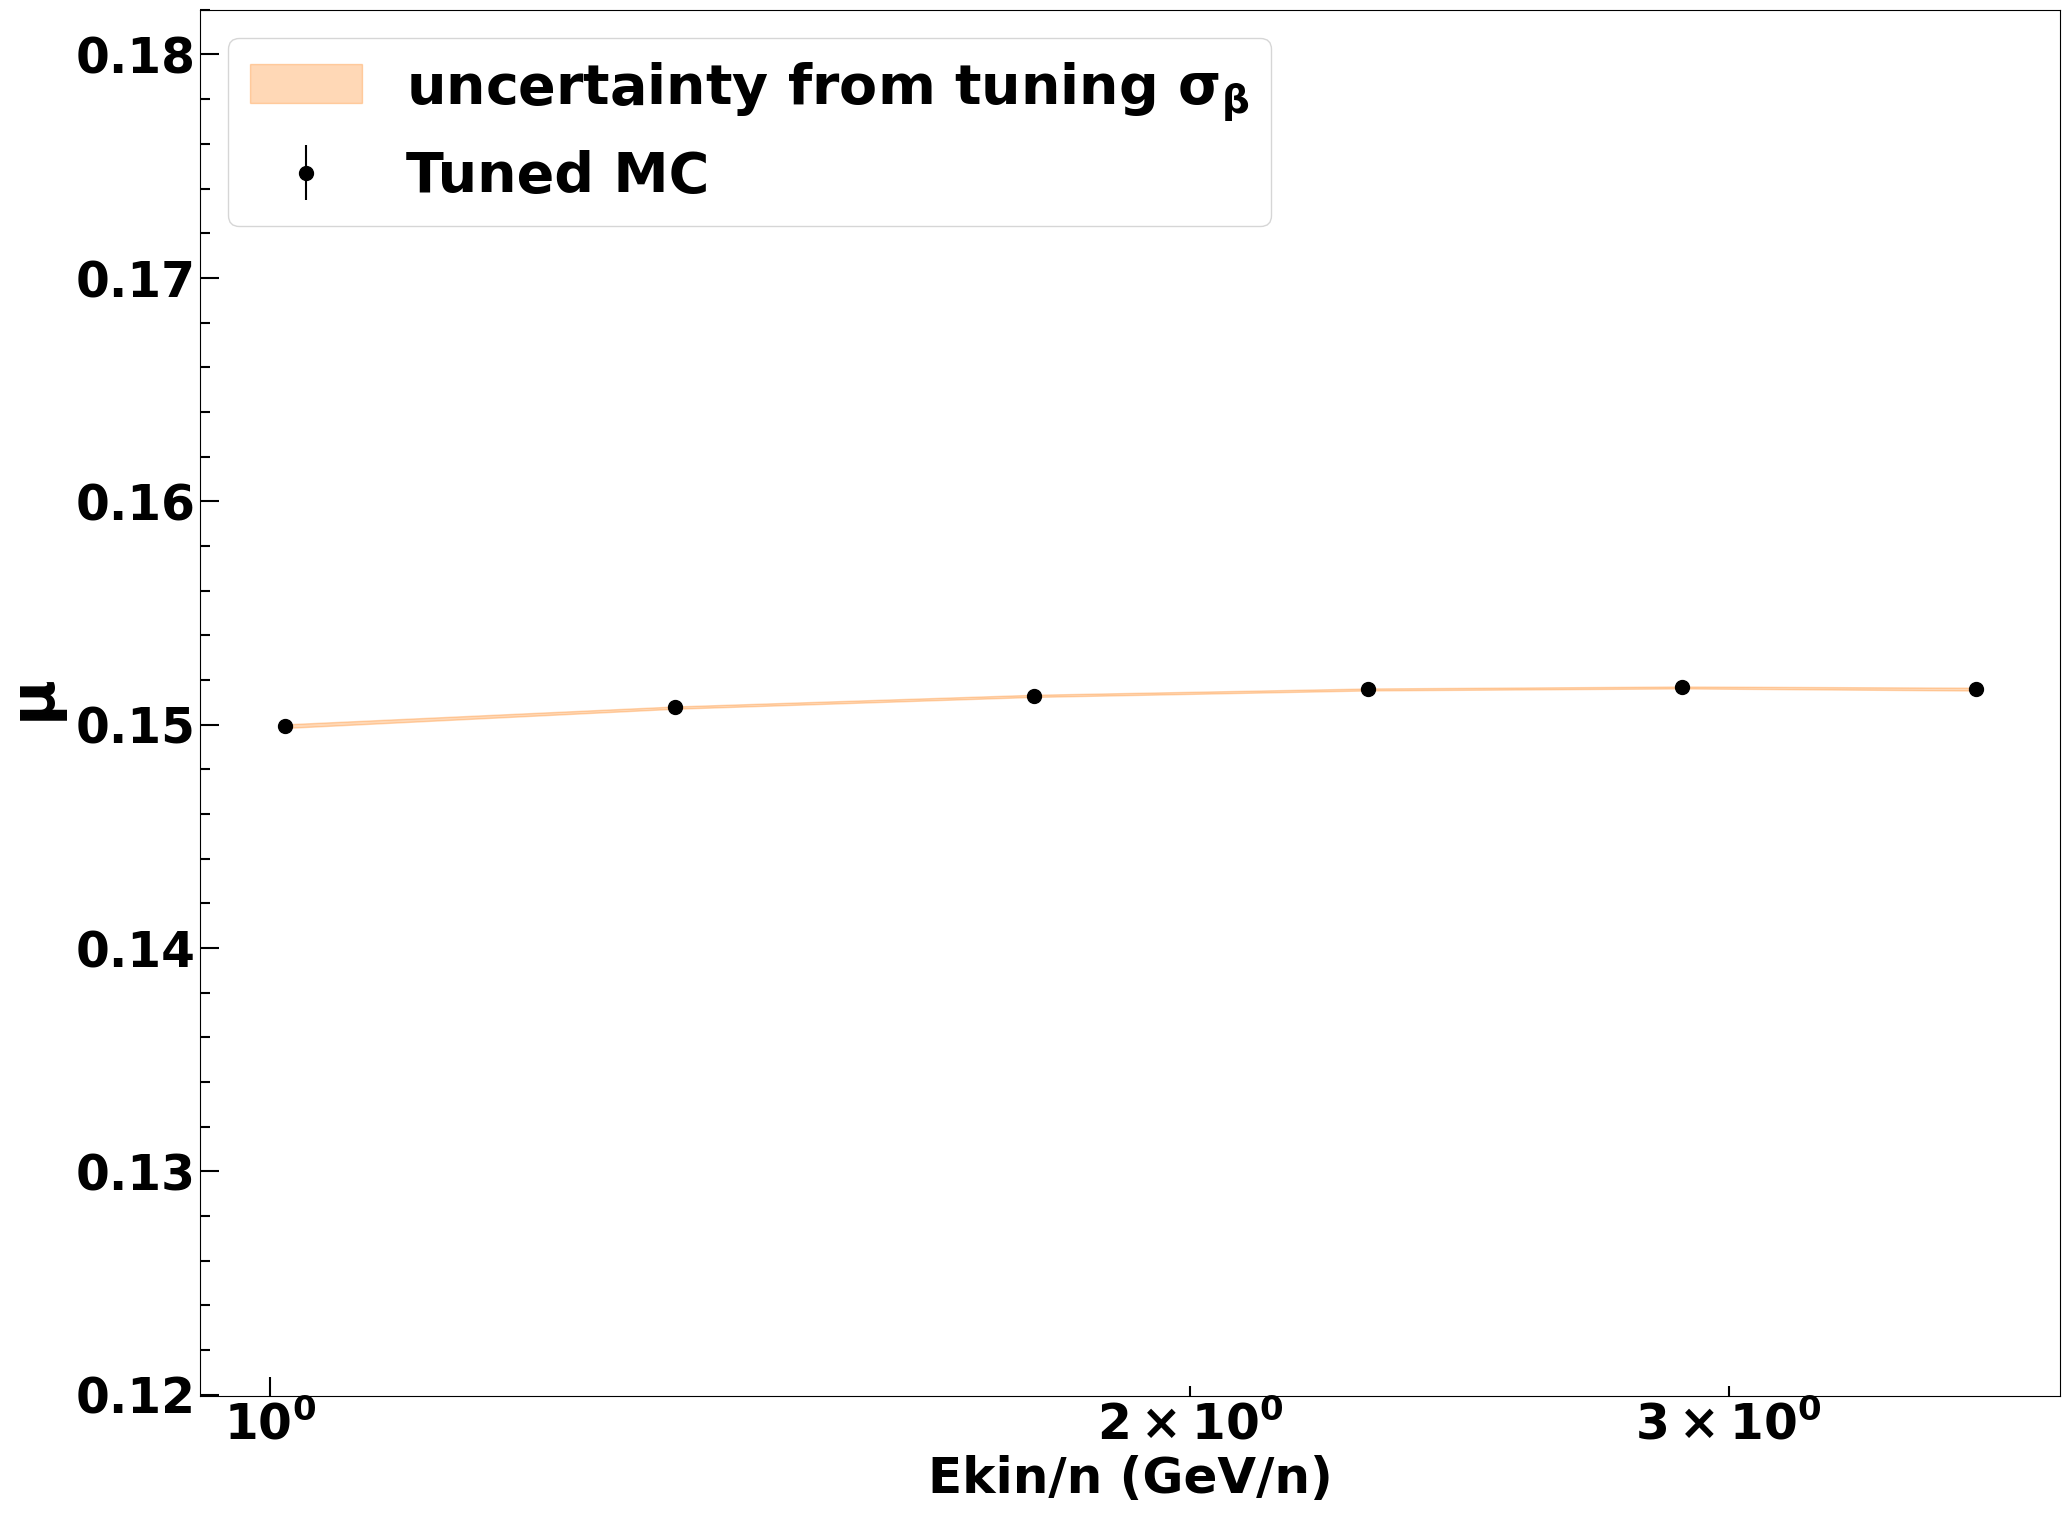

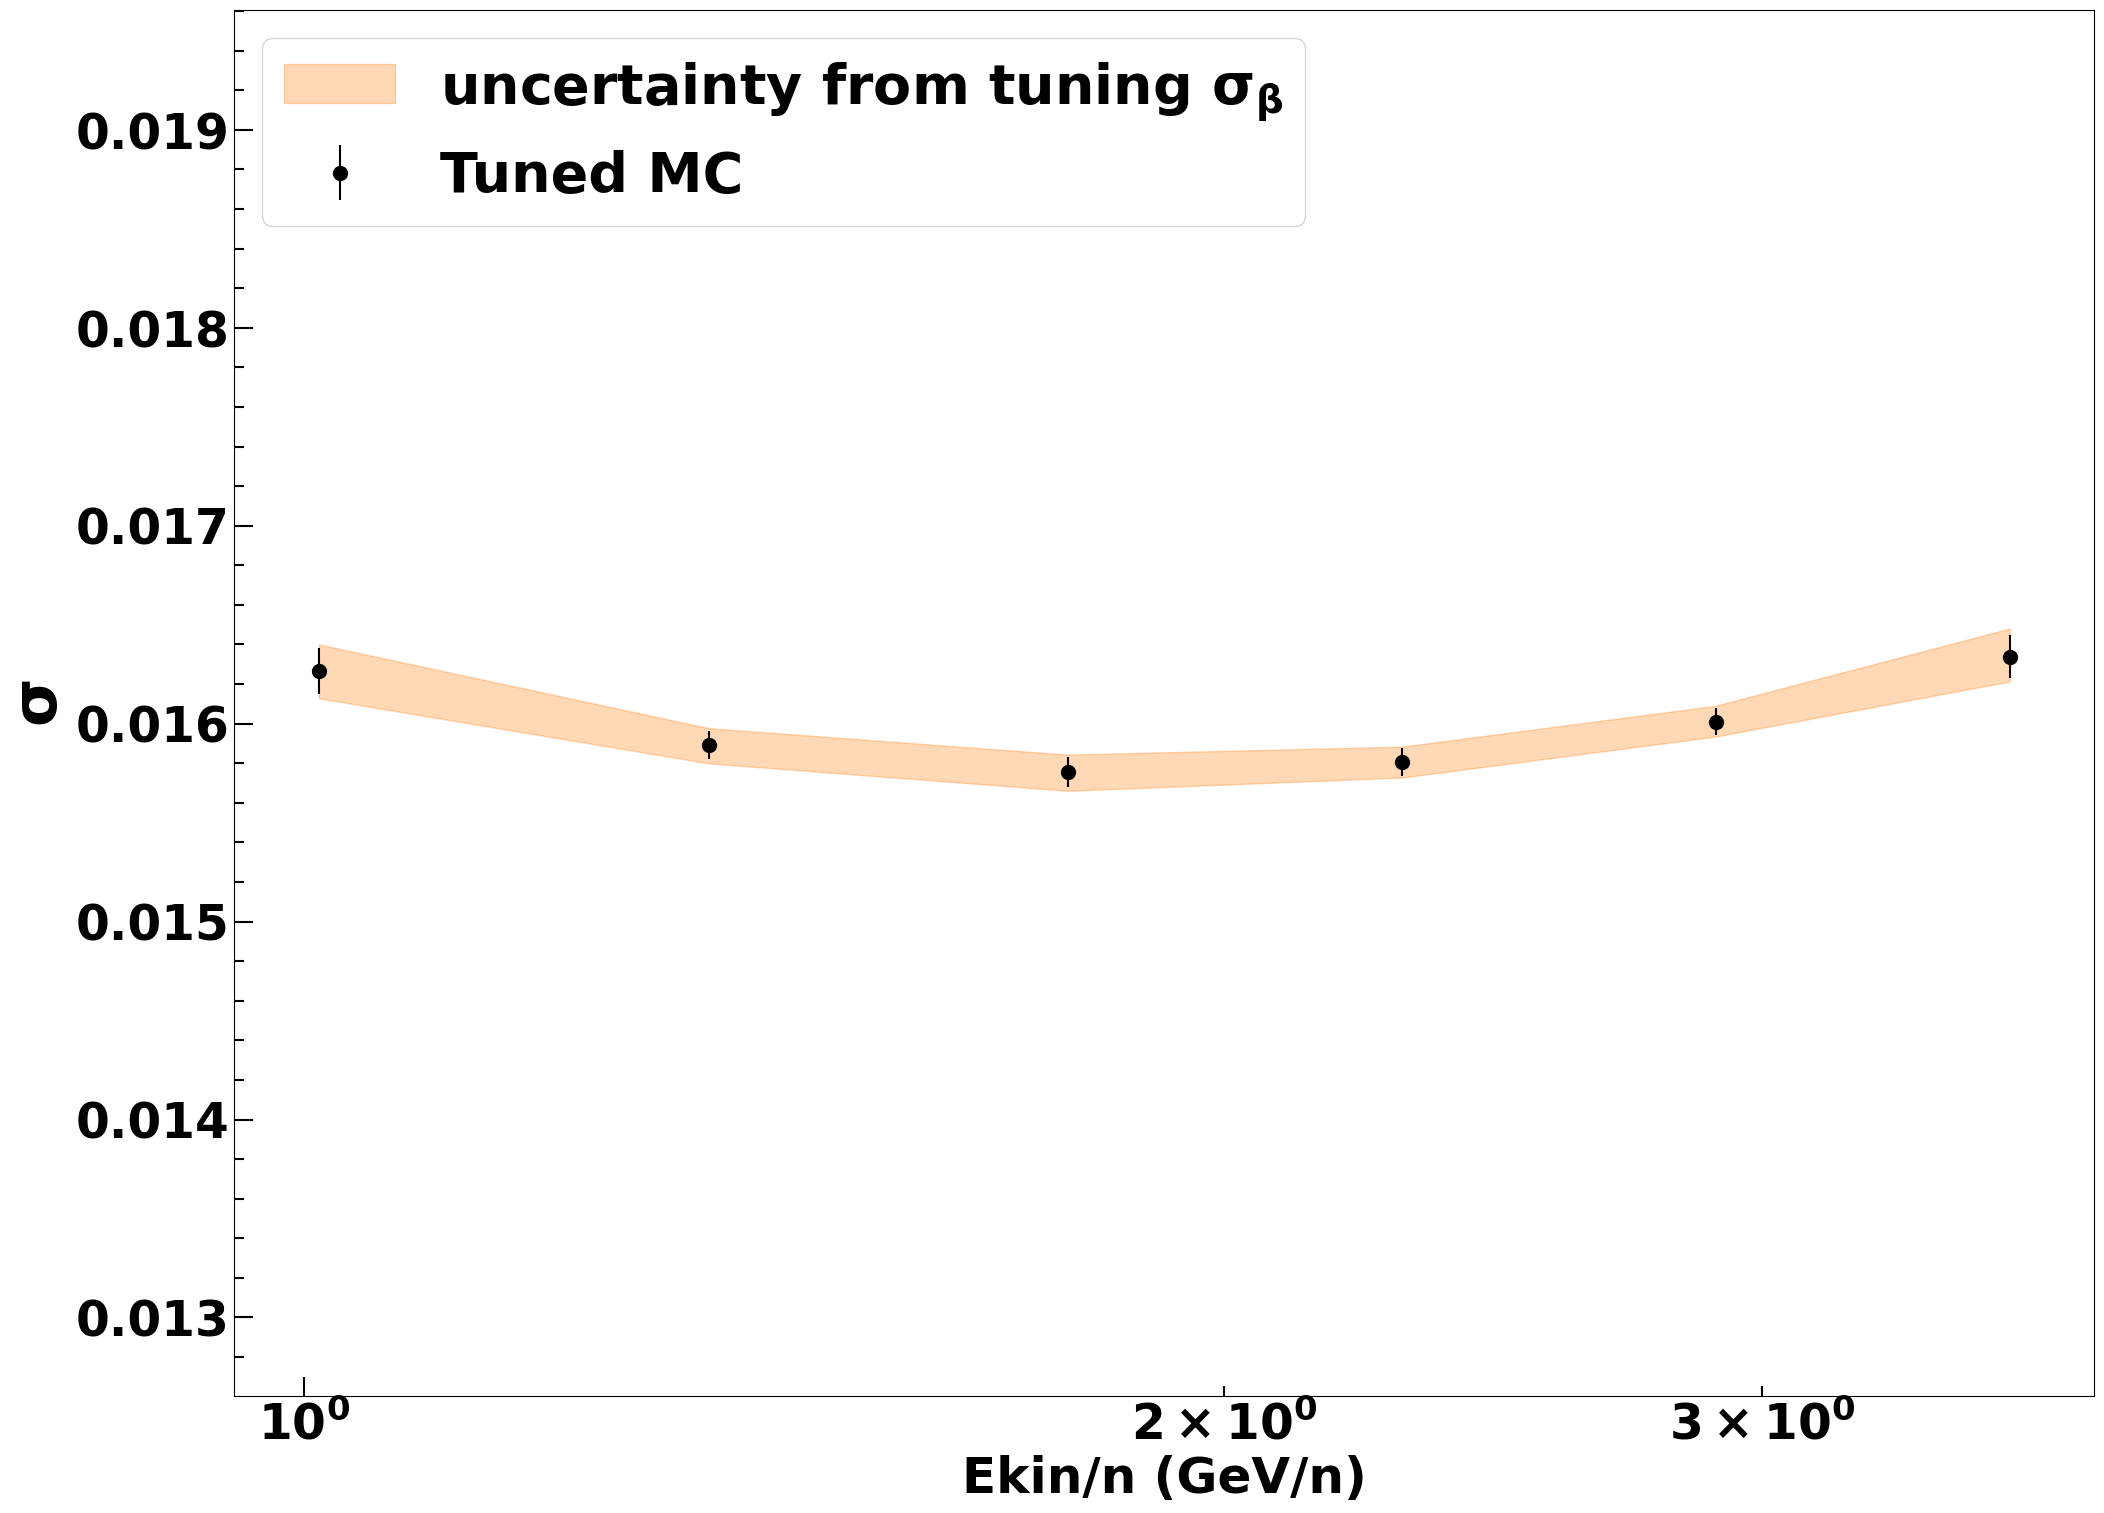

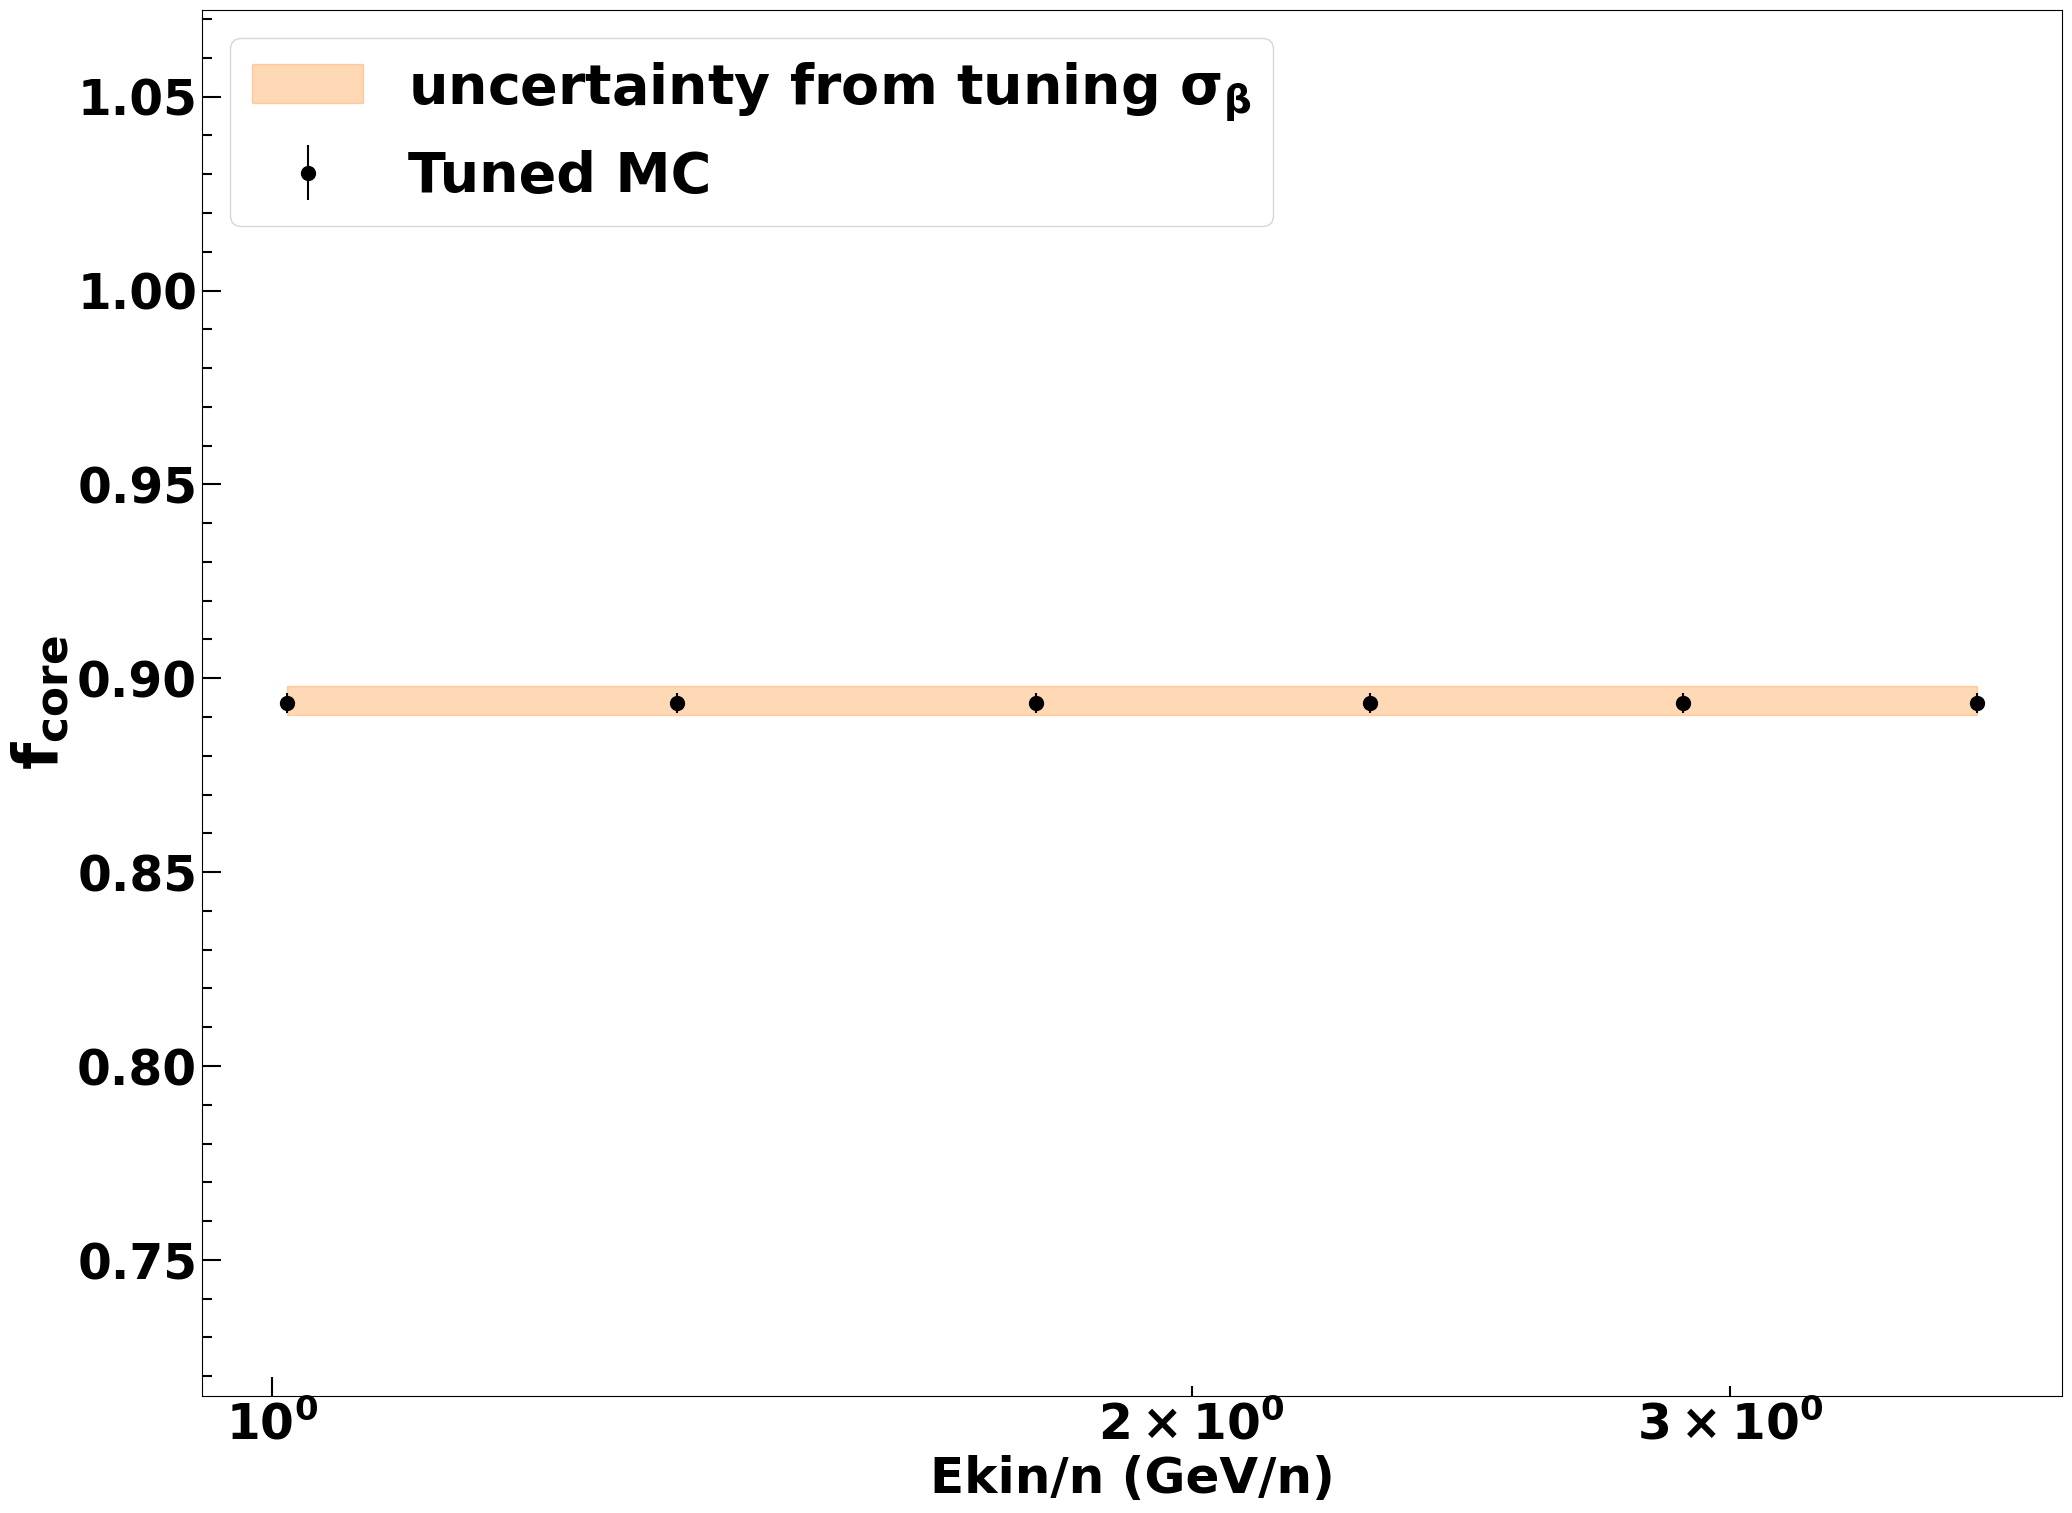

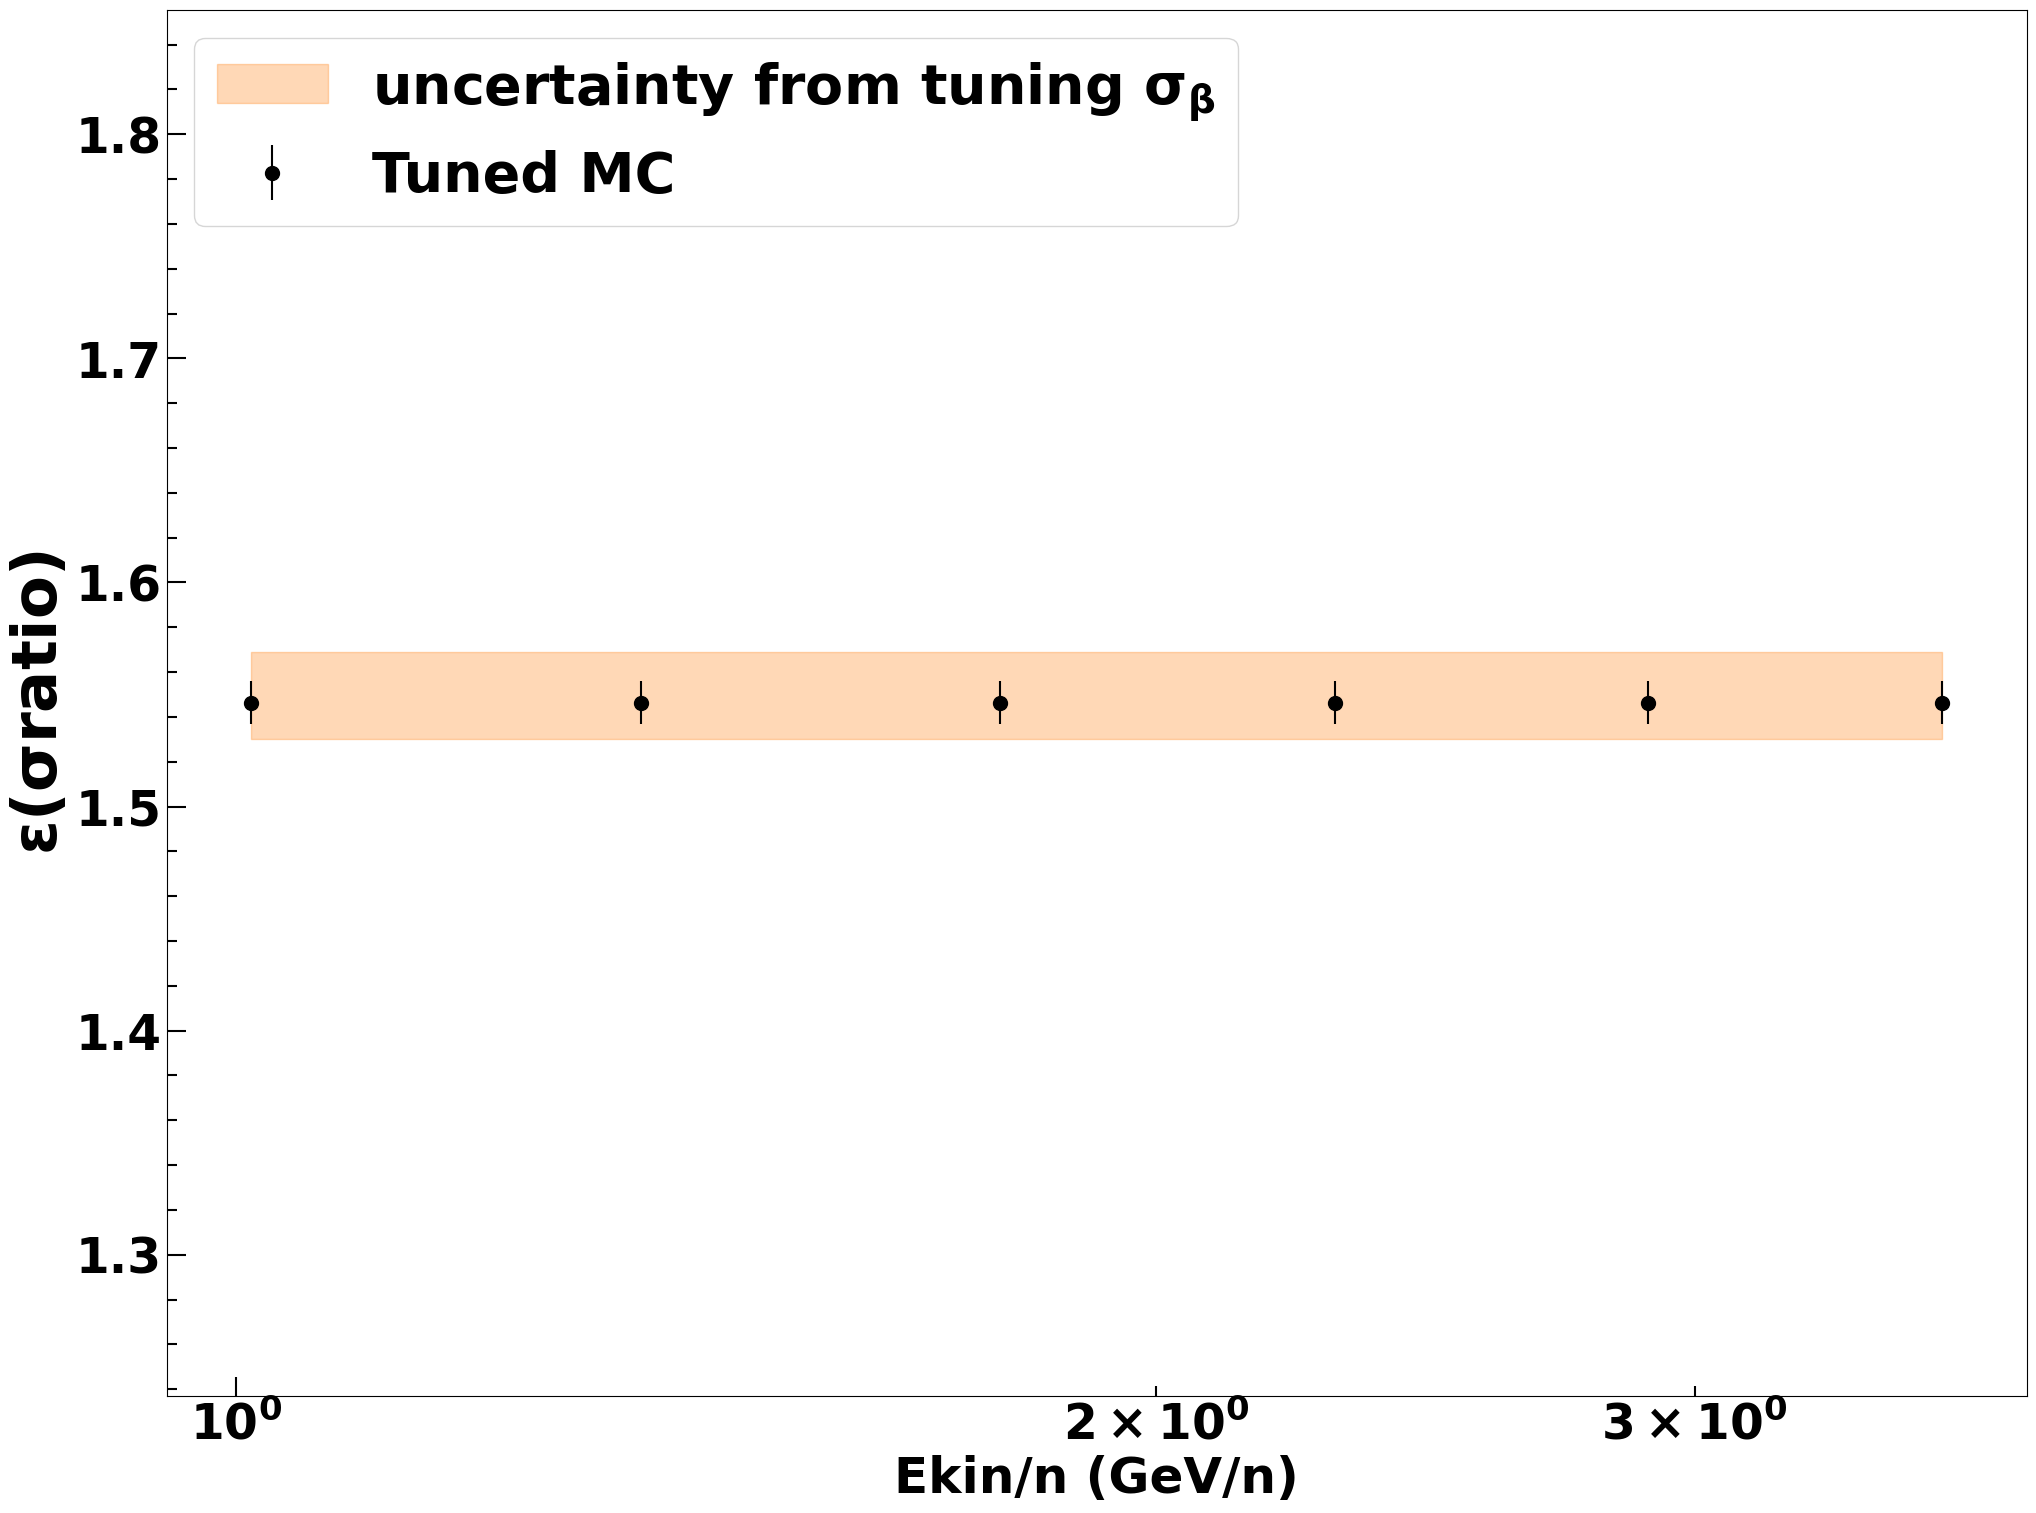

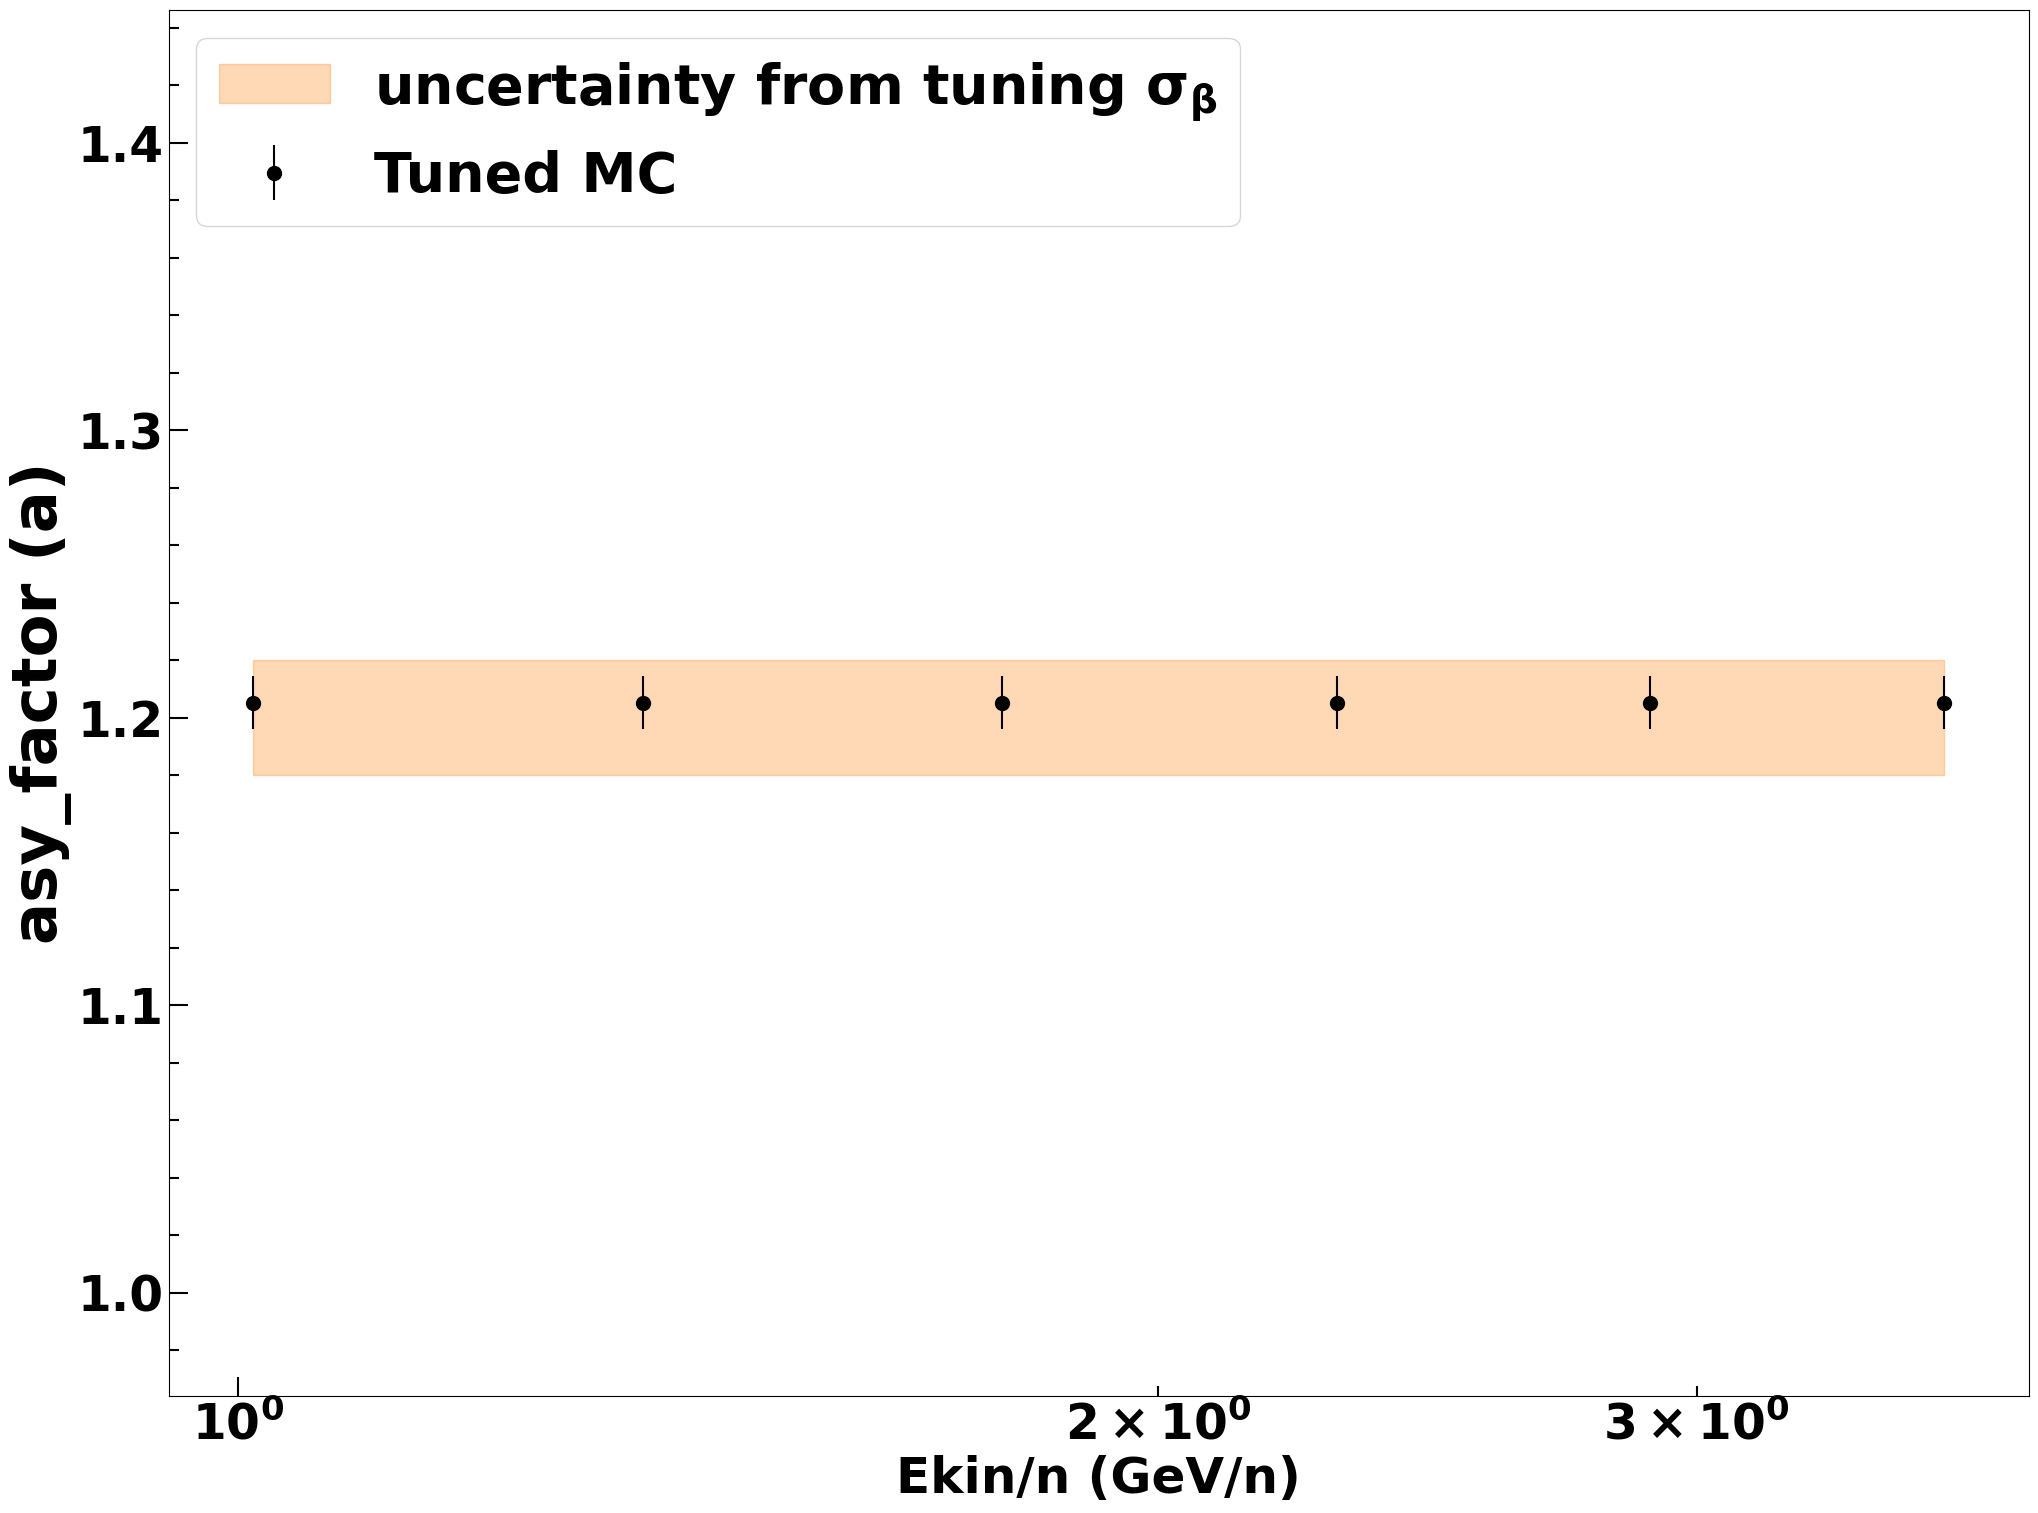

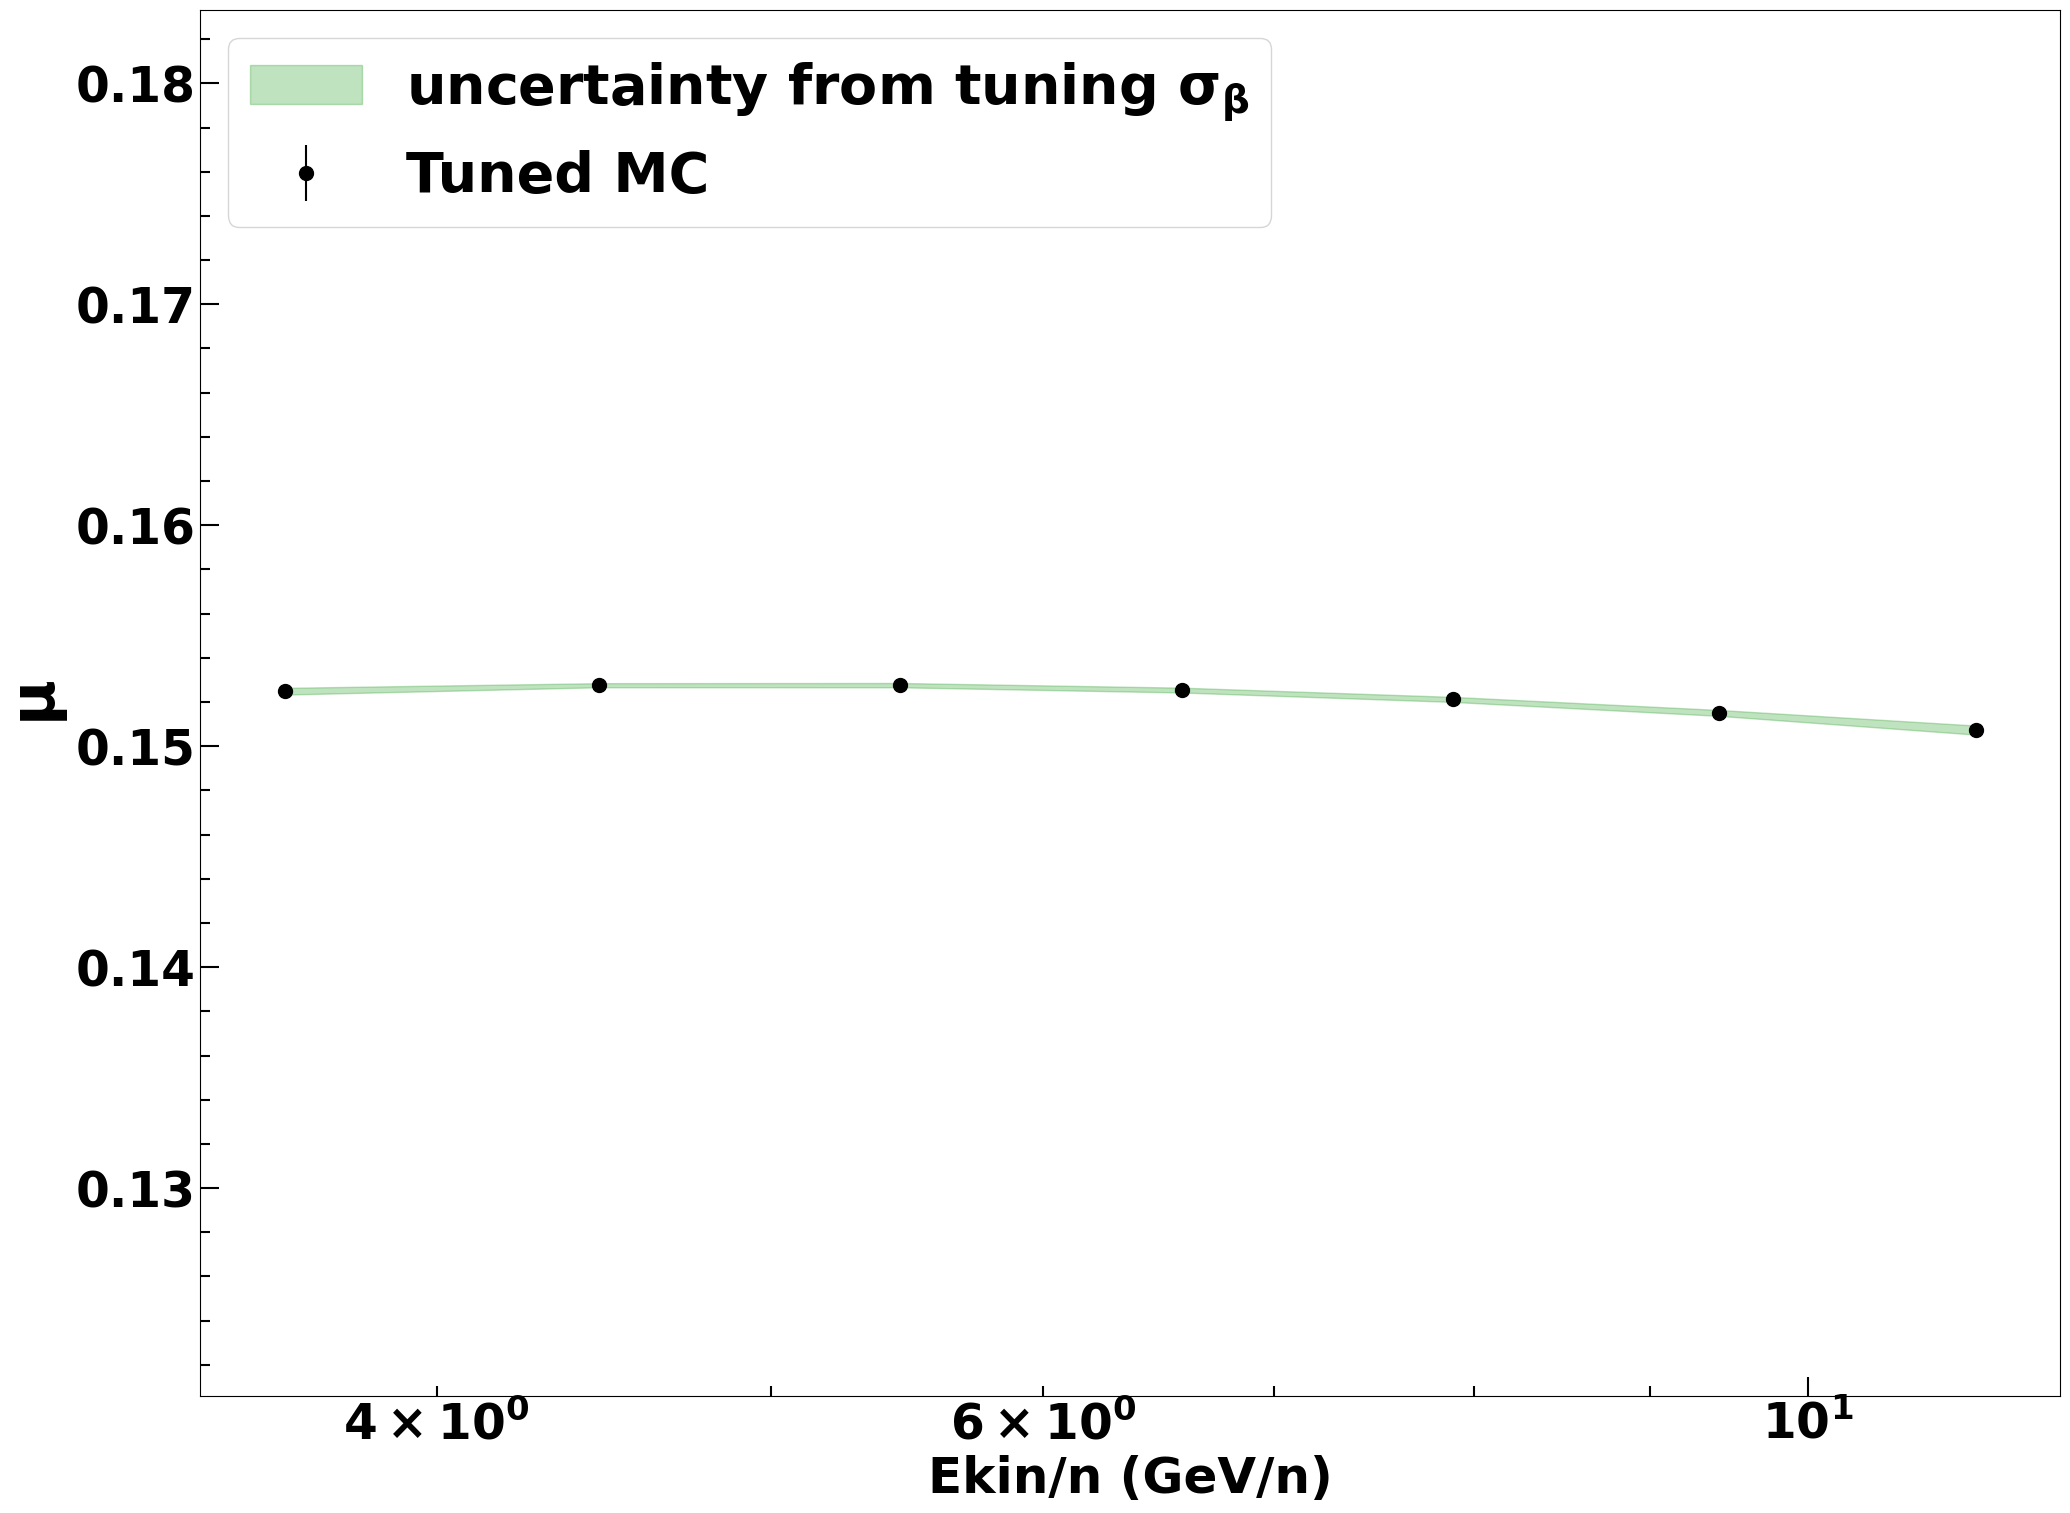

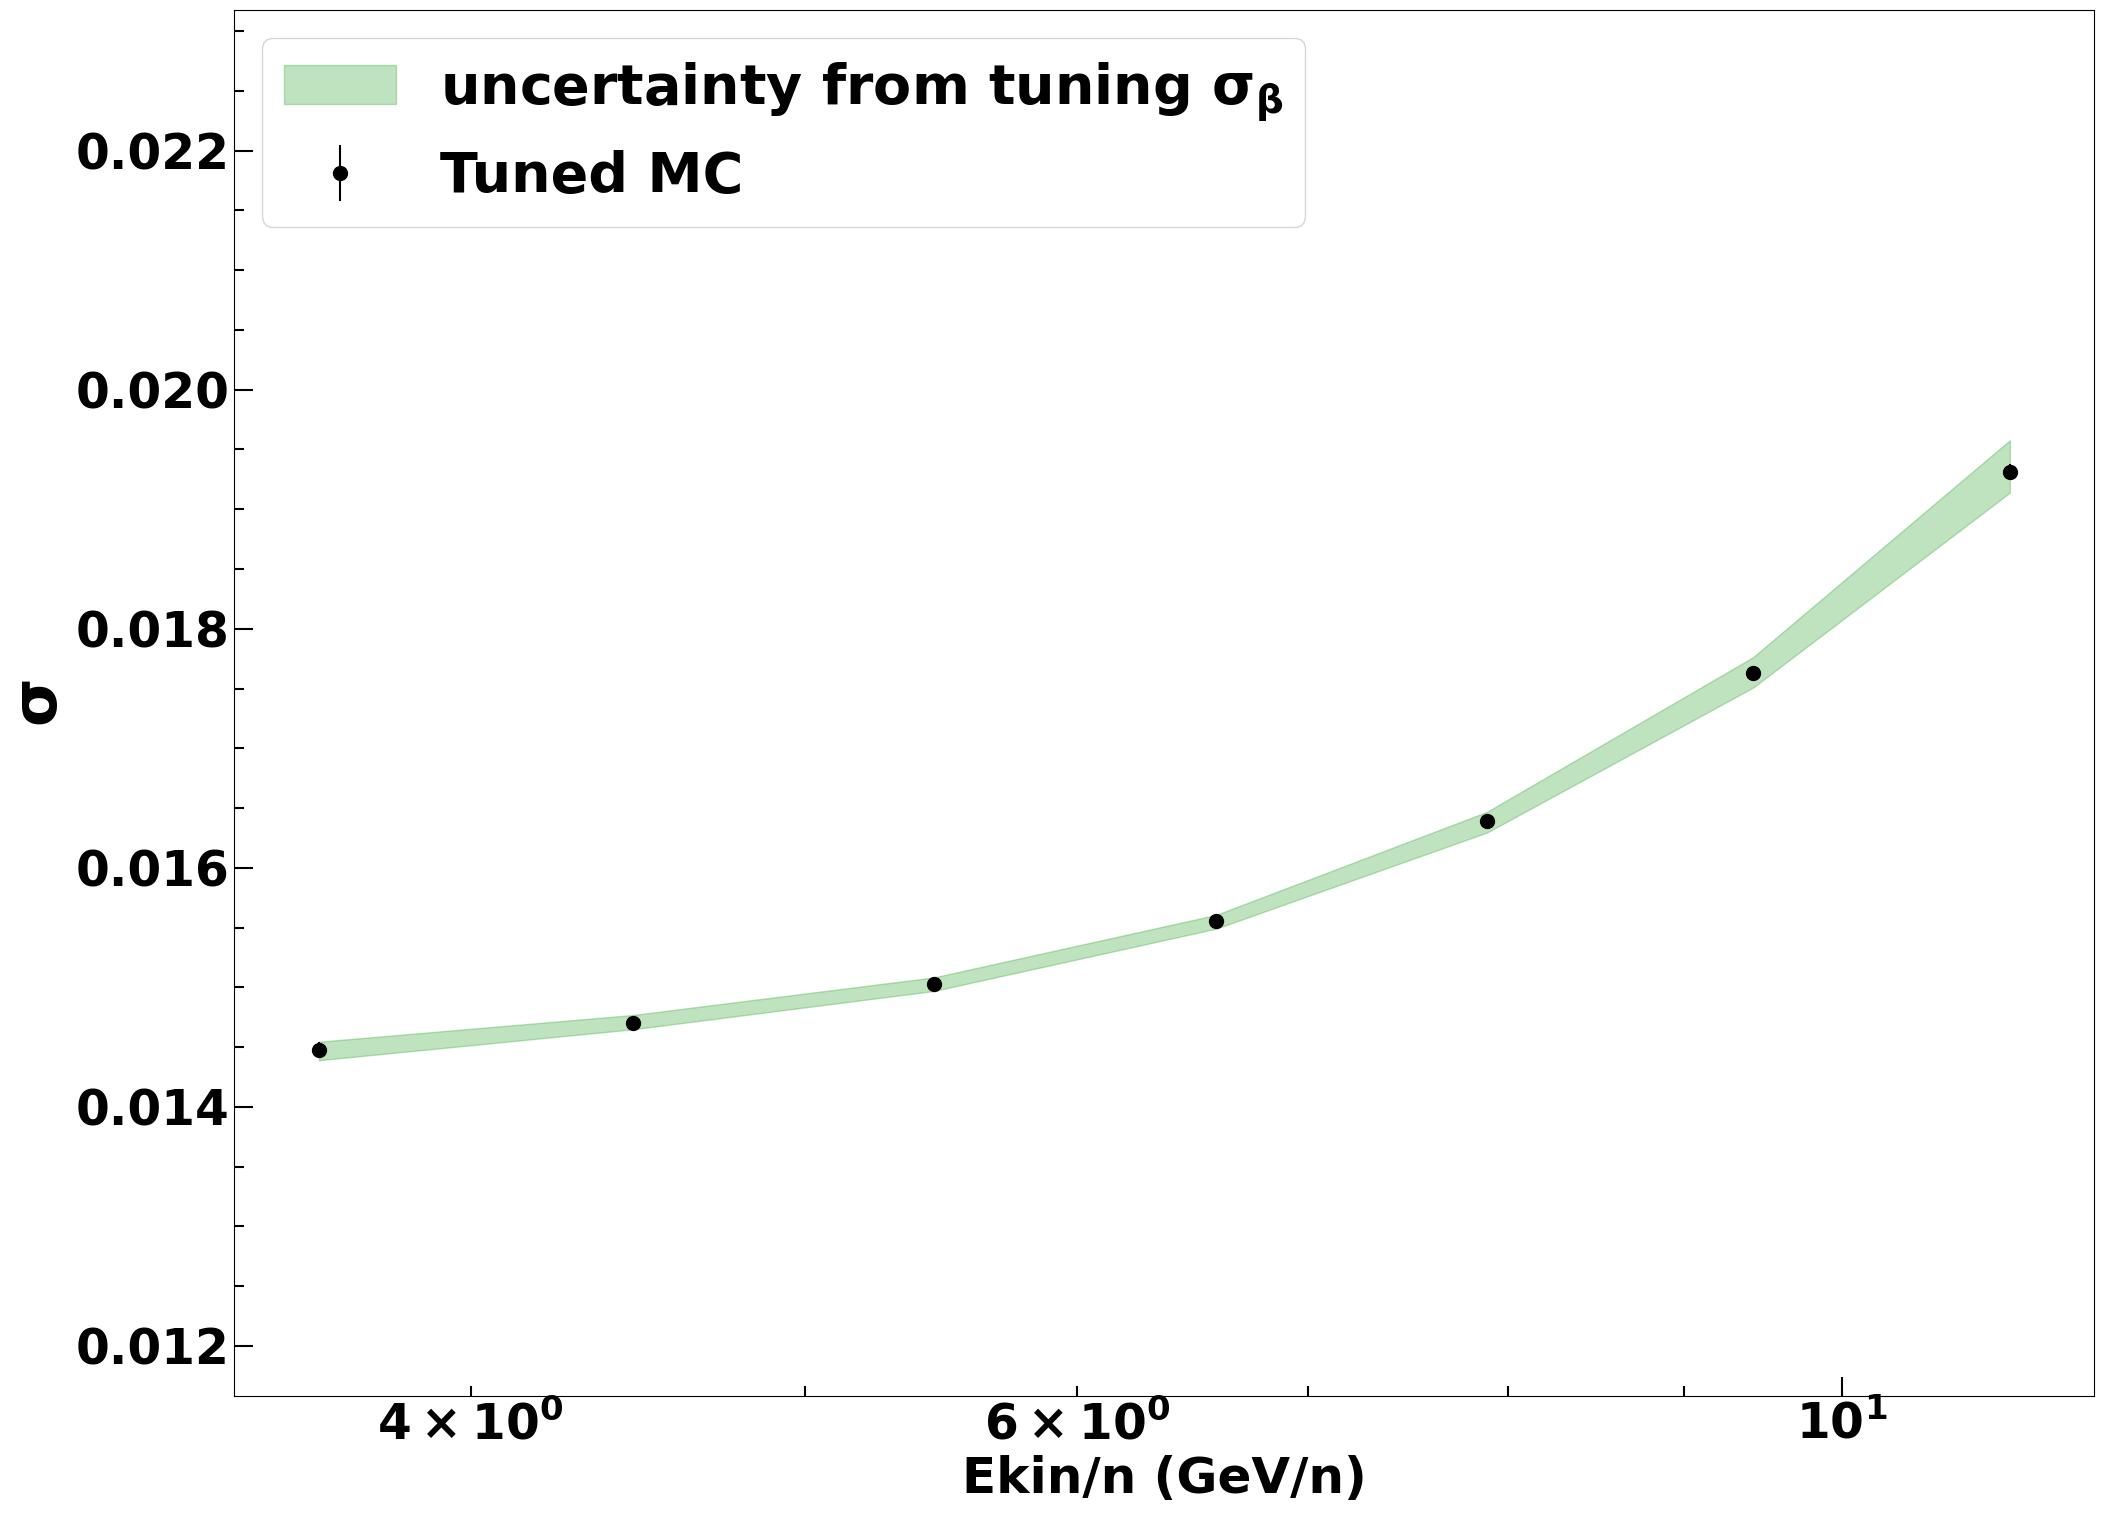

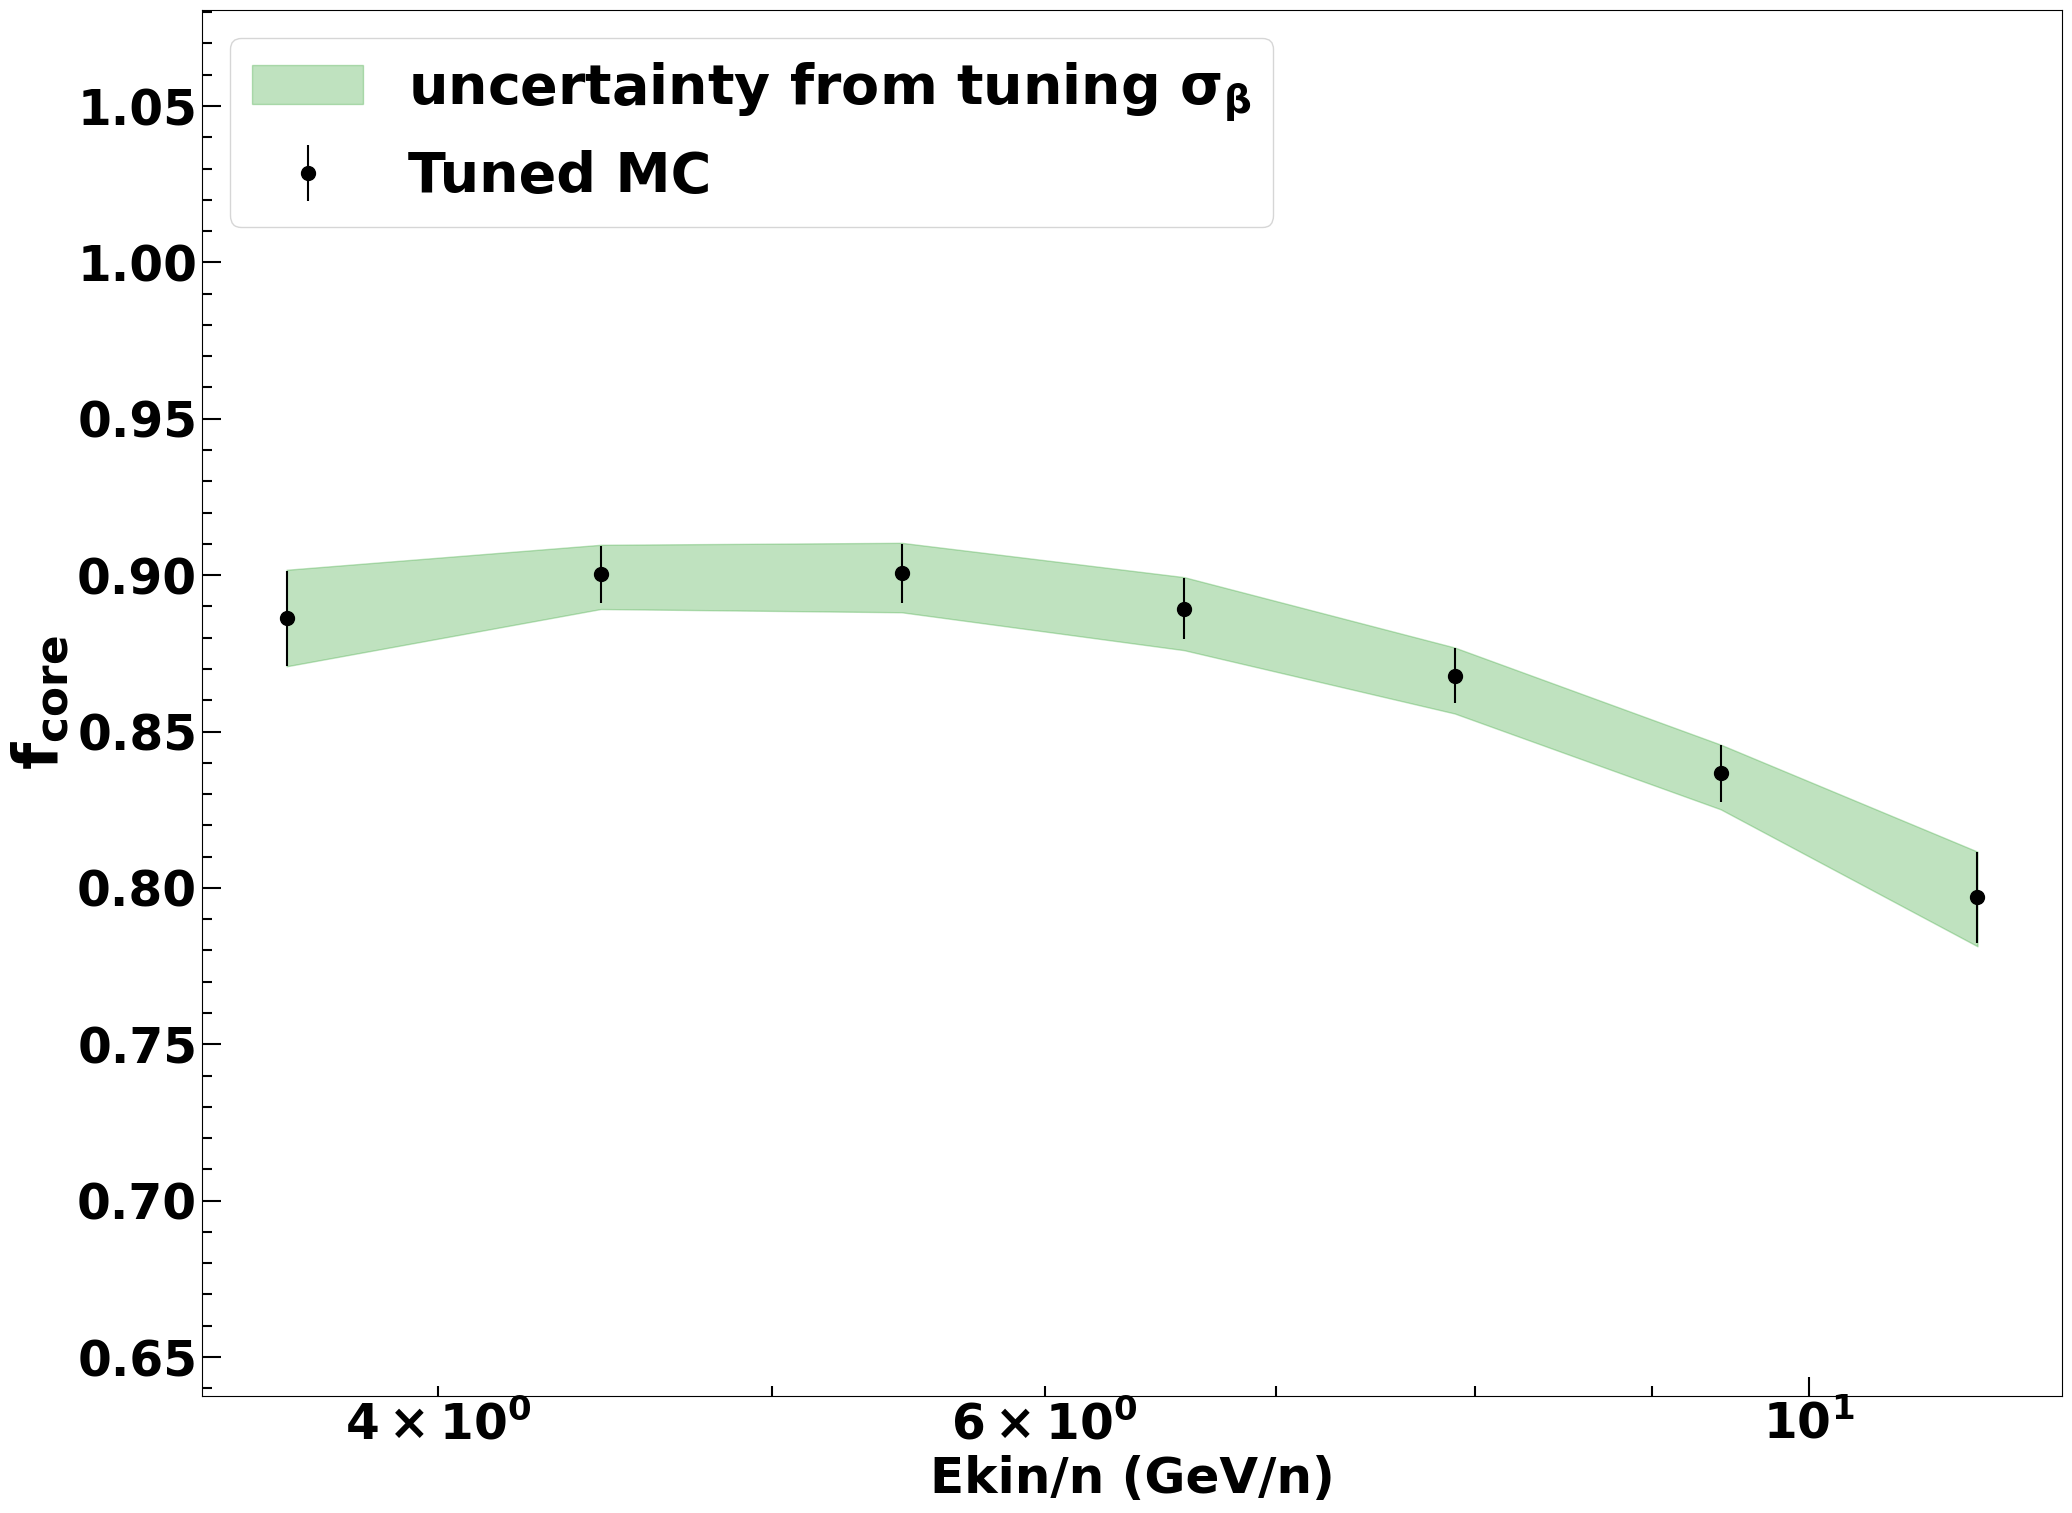

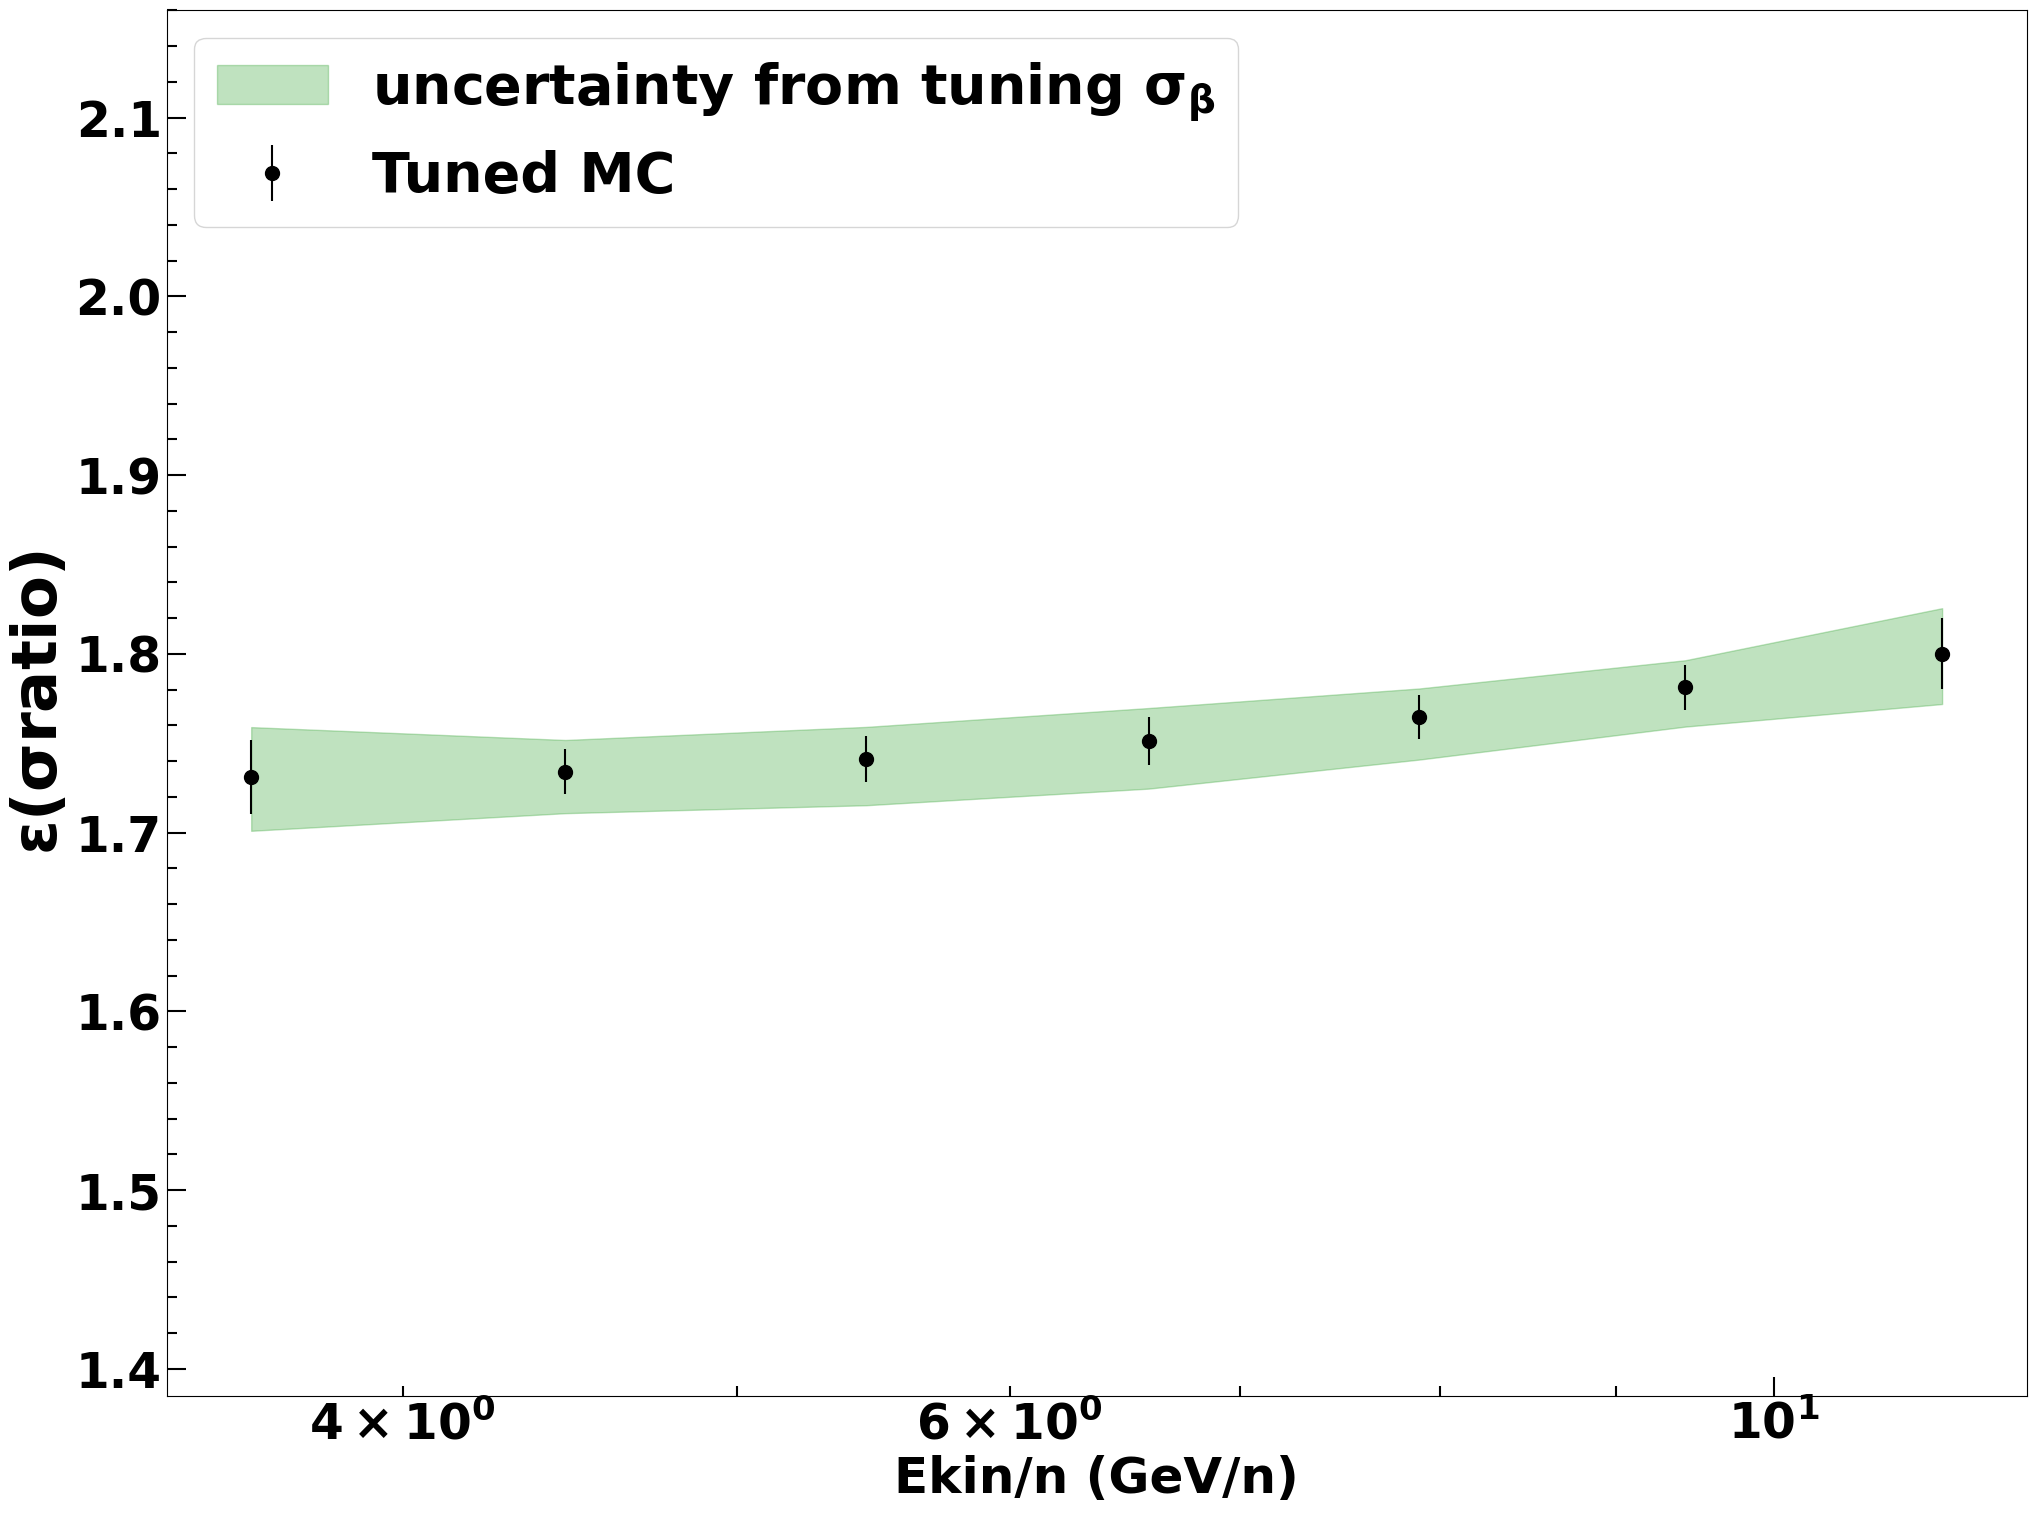

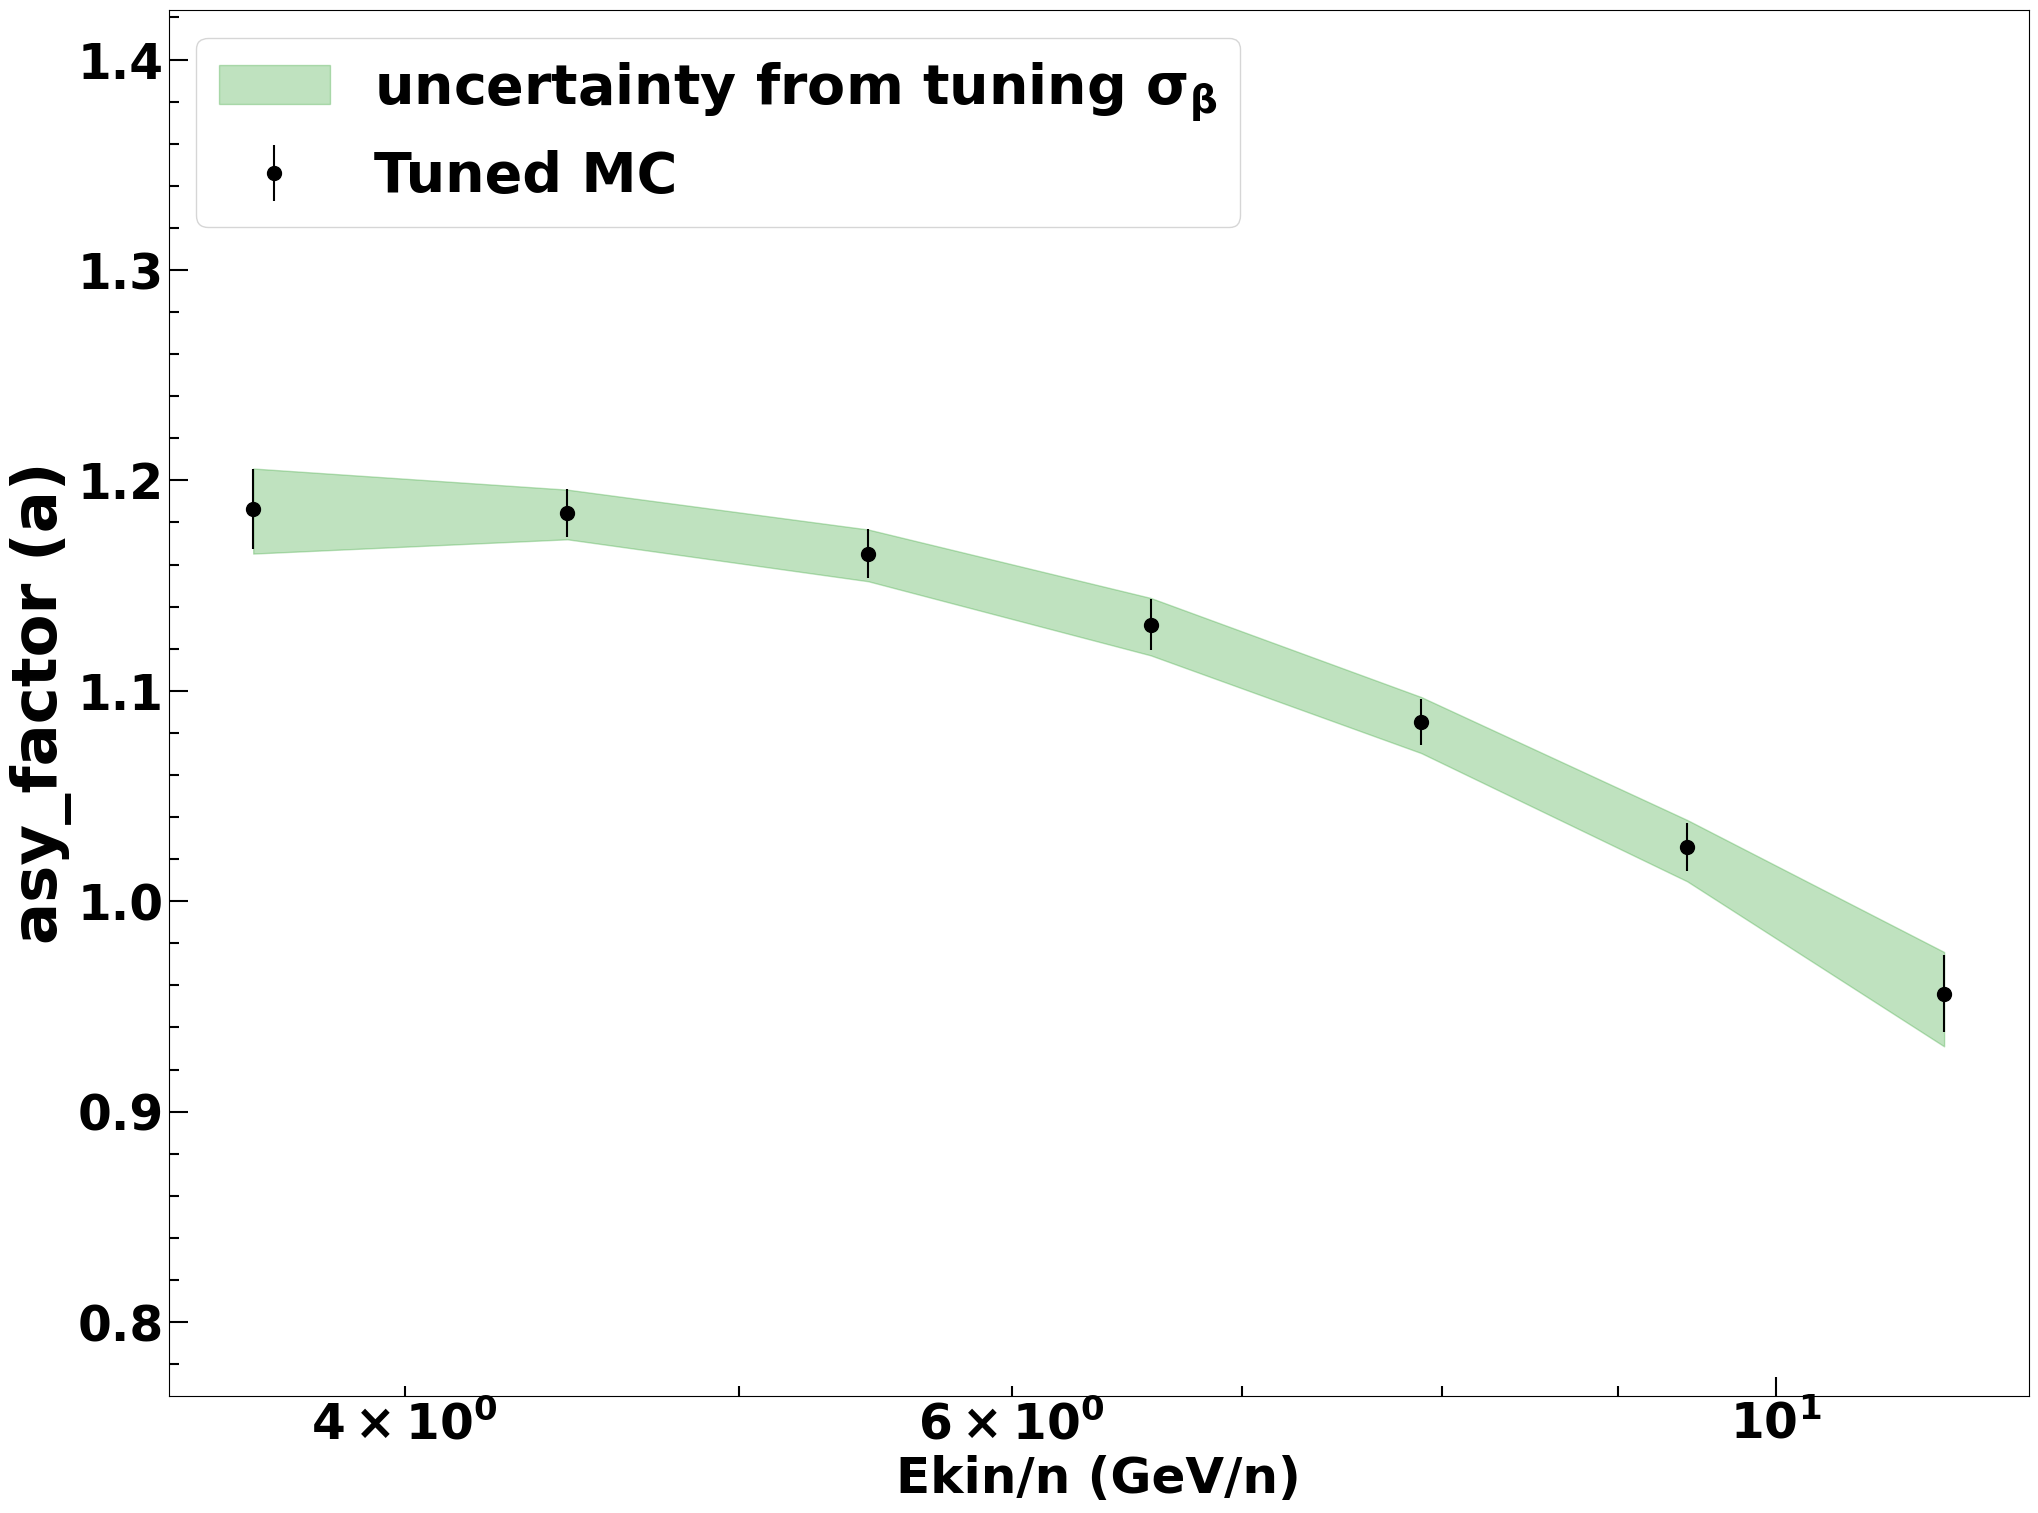

In [59]:
import pickle
from scipy.interpolate import  UnivariateSpline

xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
df_graph_parslim = {}
df_graph_parslim_ext = {}

graph_fitlow = {dec:{} for dec in detectors}
graph_fitup = {dec:{} for dec in detectors}
graph_fitlowmax = {dec:{} for dec in detectors}
graph_fitupmax = {dec:{} for dec in detectors}

print(graph_parsUntuned.items())

filepathTuneMax = {'Tof':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin',
                   'NaF':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedMin_Rebin',
                   'Agl':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedMin_Rebin'}

filepathTune = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin'
graph_MaxScale = {dec:{} for dec in detectors}
graph_MaxScaleLow = {dec:{} for dec in detectors}
graph_MaxScaleUp = {dec:{} for dec in detectors}

graph_TunedBeta0 = {dec:{} for dec in detectors}
graphfitted_TunedBeta0 = {dec:{} for dec in detectors}
ylim_range_be7 = {'mean':[0.145, 0.16], 'sigma':[0.013, 0.021], 'sigma_ratio':[1.6, 2.0], 'asy_factor': [0.8, 1.3], 'fraccore':[0.7, 1.0], "norm":[0, 40]} 
splinefit_uncertainty = {dec:{} for dec in detectors}
graph_MaxScaleErr = {dec:{} for dec in detectors}
df_graph_parslim_max = {}

for dec in ['Tof', 'NaF', 'Agl']:
    for par in parnames:
        
        fig, ax1 = plt.subplots(1, 1, figsize=(24, 18))  
        
        graph_fitlow[dec][par], graph_fitup[dec][par] = plot_errband_constraint(fig, ax1, df_graph_parslim, graph_parsUntuned[dec][par], graph_parsTuned[dec][par],  DETECTOR_COLOR[dec], par, polyfitp0[dec][par])
        #print(dec, par)
        #print(((graph_fitup[dec][par].yvalues - graph_fitlow[dec][par].yvalues)* 0.5)/((graph_fitlow[dec][par].yvalues + graph_fitup[dec][par].yvalues) *0.5))
        
        splinefit_uncertainty[dec][par] = get_uncertainty_spline(graph_fitlow[dec][par], graph_fitup[dec][par])
        
        df_maxscale = np.load(os.path.join(filepathTuneMax[dec], f'df_{par}_{itername}.npz'))
        graph_MaxScale[dec][par] = MGraph.from_file(df_maxscale, f'graph_{par}_{dec}')
        
        df_parT0 = np.load(os.path.join(filepathTune, f'df_{par}_{itername}.npz'))
        graph_TunedBeta0[dec][par] = MGraph.from_file(df_parT0, f'graph_{par}_{dec}')   
        graphfitted_TunedBeta0[dec][par] = GetFitValue(graph_TunedBeta0[dec][par], polyfitp0[dec][par], withsigma=False)
        #plot_graph(fig, ax1, graph_TunedBeta0[dec][par], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label='Tuned MC')
        plot_graph(fig, ax1, graphfitted_TunedBeta0[dec][par], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label='Tuned MC')
        
        graph_MaxScaleLow[dec][par], graph_MaxScaleUp[dec][par] = plot_errband_constraint(fig, ax1, df_graph_parslim_ext, graph_MaxScale[dec][par], graphfitted_TunedBeta0[dec][par], 'grey', par, polyfitp0[dec][par], withsig=False)
        graph_MaxScaleErr[dec][par] = getgrapherr_fromLowUp(graph_MaxScaleLow[dec][par], graph_MaxScaleUp[dec][par])
        #if par == 'fraccore':
        #    graph_fitup[dec][par].yvalues = graph_fitup[dec][par].yvalues * 1.002
        ax1.fill_between(graph_fitlow[dec][par].xvalues, graph_fitlow[dec][par].yvalues, graph_fitup[dec][par].yvalues , color=DETECTOR_COLOR[dec], alpha=0.3, label=r'uncertainty from tuning $\mathrm{\sigma_{\beta}}$')
        #ax1.fill_between(graph_MaxScaleLow[dec][par].xvalues, graph_MaxScaleLow[dec][par].yvalues, graph_MaxScaleUp[dec][par].yvalues , color="grey", alpha=0.3, label=r'uncertainty from MC $\mathrm{\sigma_{\beta}}$ at R>200GV')
        #ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 1.2 * graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues , color='grey', alpha=0.7, label=r'uncertainty from tuning as function of Z')
        #ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitup[dec][par].yvalues, 1.2 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues , color='grey', alpha=0.7)
        
        #ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.65 * graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues -  graph_MaxScaleErr[dec][par].yvalues , color='grey', alpha=0.3, label=r'$\mathrm{uncertainty \ from \ energy \ dependence \ of \ \sigma_{\beta}}$')
        #ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues , 2.65 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues,  color='grey', alpha=0.3)
        
        plt.subplots_adjust(hspace=.0)                                                                                                                                                                                                                                                                                                                                            
        ax1.set_xlabel("Ekin/n (GeV/n)")  
        ax1.set_ylim([0.8 * min(graphfitted_TunedBeta0[dec][par].yvalues), 1.2 *max(graphfitted_TunedBeta0[dec][par].yvalues)] )
        #ax1.set_ylim(ylim_range_be7[par])
        ax1.set_xscale('log')
        ax1.legend(loc='upper left', fontsize=fontsize1-5)
        ax1.set_ylabel(f'{par_names_axes[par]}', fontsize=fontsize1)
        #print(dec, par)
        #ax1.legend()
        savefig_tofile(fig, plotfile, f'fitrange_{dec}_{par}', 1)
        graph_fitlowmax[dec][par] = MGraph(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - graph_MaxScaleErr[dec][par].yvalues, np.zeros_like(graph_MaxScaleErr[dec][par].xvalues))
        graph_fitupmax[dec][par] = MGraph(graph_MaxScaleErr[dec][par].xvalues, graph_fitup[dec][par].yvalues + graph_MaxScaleErr[dec][par].yvalues, np.zeros_like(graph_MaxScaleErr[dec][par].xvalues))
        graph_fitlowmax[dec][par].add_to_file(df_graph_parslim_max, f'graph_{par}low_{dec}')
        graph_fitupmax[dec][par].add_to_file(df_graph_parslim_max, f'graph_{par}up_{dec}')
        if dec == 'Agl':
            print(graph_fitupmax[dec][par])
        
with open('/home/manbing/Documents/Data/data_BeP8/splines_pars_uncertainty.pkl', 'wb') as file:
    pickle.dump(splinefit_uncertainty, file)
    
with open('/home/manbing/Documents/Data/data_BeP8/splines_pars_uncertainty.pkl', 'rb') as file:
    loaddic = pickle.load(file)

#print(loaddic.items())

#spline1 = loaddic['NaF']['sigma']
#print(spline1(np.log(graph_fitlow['NaF']['sigma'].xvalues)))

#np.savez(os.path.join('/home/manbing/Documents/Data/data_BeP8', 'graph_parslim_TunedUncertainty.npz'), **df_graph_parslim_max)




dict_items([('Tof', {'mean': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbce5e1ea0>, 'sigma': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbce306770>, 'fraccore': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbce305c00>, 'sigma_ratio': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbce307640>, 'asy_factor': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbce306440>}), ('NaF', {'mean': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbce307430>, 'sigma': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbce306500>, 'fraccore': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbce306fe0>, 'sigma_ratio': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbce307040>, 'asy_factor': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbce307d90>}), ('Agl', {'mean': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbce306560

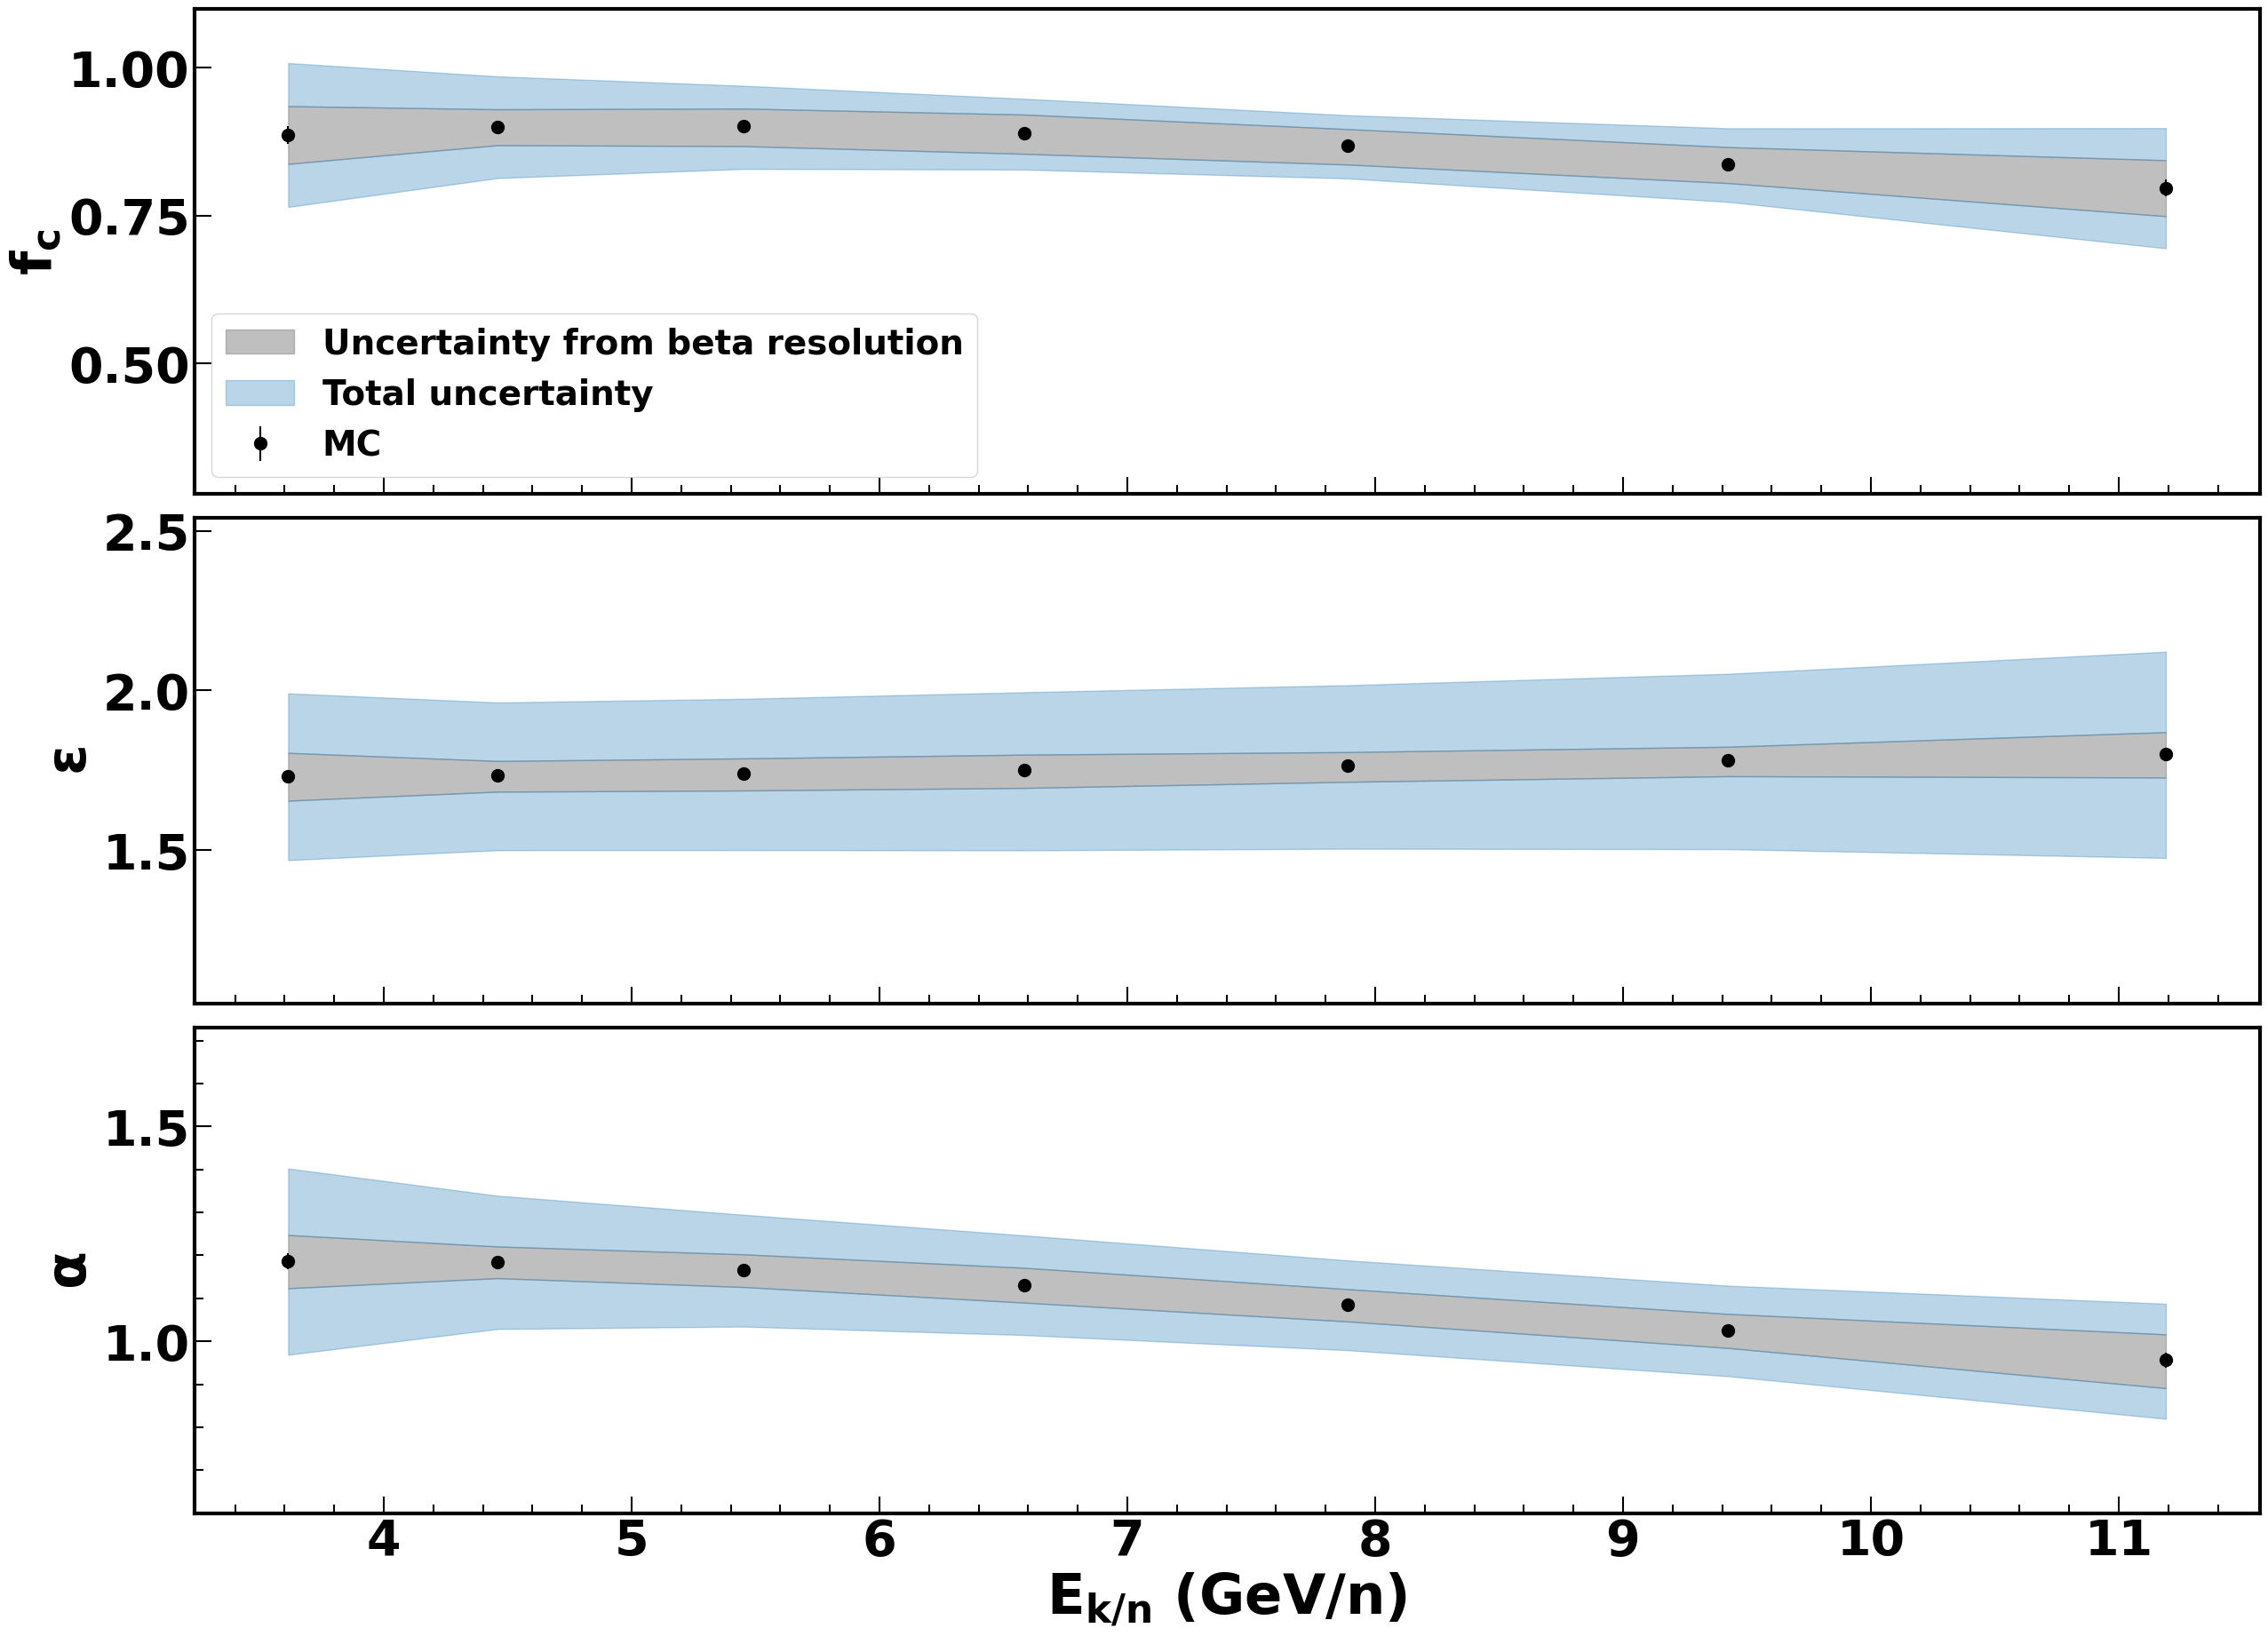

In [60]:
dec = 'Agl'
FIGSIZE_Y123 = (30, 22)   
with open('/home/manbing/Documents/Data/data_BeP8/FitParsRange/splines_pars_uncertainty_rigTail.pkl', 'rb') as file:
    loaddic_rigTail_uncertainty = pickle.load(file)
    print(loaddic_rigTail_uncertainty.items())

def plotparsonthis(axn, par, dec):
    plot_graph(fig, axn, graphfitted_TunedBeta0[dec][par], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label='MC')
    
    #axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 1.0 *graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues , color='grey', alpha=0.6)
    #axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitup[dec][par].yvalues, 1.0 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues , color='grey', alpha=0.6)   
    #axn.fill_between(graph_fitlow[dec][par].xvalues, graph_fitlow[dec][par].yvalues, graph_fitup[dec][par].yvalues , color='grey', alpha=0.6, label=r'Beta Tuning: Data/MC ratio')
    
    #axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.2 * graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues -  1.1 *graph_MaxScaleErr[dec][par].yvalues , color='grey', alpha=0.6)
    
    axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.2 * graph_MaxScaleErr[dec][par].yvalues  , 2.2 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues,  color='grey', alpha=0.5, label=r'Uncertainty from beta resolution')
    
    
    axn.set_ylim([0.85 * min(graphfitted_TunedBeta0[dec][par].yvalues), 1.15 *max(graphfitted_TunedBeta0[dec][par].yvalues)] )
    
    rigTailErr = 2 * loaddic_rigTail_uncertainty[dec][par](np.log(graph_MaxScaleErr[dec][par].xvalues))
    lowPile2 = graph_fitlow[dec][par].yvalues - 2.2 * graph_MaxScaleErr[dec][par].yvalues
    upPile2 = 2.2 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues
    
    axn.fill_between(graph_MaxScaleErr[dec][par].xvalues,  lowPile2 - rigTailErr, lowPile2, color='tab:blue', alpha=0.3, label=r'Total uncertainty')
    axn.fill_between(graph_MaxScaleErr[dec][par].xvalues,  upPile2, upPile2 + rigTailErr, color='tab:blue', alpha=0.3)
    #axn.fill_between(graph_MaxScaleLow[dec][par].xvalues, graph_MaxScaleLow[dec][par].yvalues, graph_MaxScaleUp[dec][par].yvalues , color='blue', alpha=0.3, label=r'uncertainty from MC $\mathrm{\sigma_{\beta}}$ at R>200GV')
    
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.33, 0.33, 0.33]}, figsize=(30, 22))   


#plot_graph(fig, ax1, graphfitted_TunedBeta0[dec][par1], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize-5)

#ax1.fill_between(graph_MaxScaleLow[dec][par1].xvalues, graph_MaxScaleLow[dec][par1].yvalues, graph_MaxScaleUp[dec][par1].yvalues, color='blue', alpha=0.3, label='tunning uncertainty 1')
#ax1.fill_between(graph_fitlow[dec][par1].xvalues, graph_fitlow[dec][par1].yvalues, graph_fitup[dec][par1].yvalues*1.003 , color='green', alpha=0.3, label='tunning uncertainty 2')


plotparsonthis(ax1, 'fraccore', dec)
plotparsonthis(ax2, 'sigma_ratio', dec)
plotparsonthis(ax3, 'asy_factor', dec)

#ax1.set_xscale('log')
ax1.legend(loc='lower left', fontsize=28)
#ax2.legend(loc='lower right', fontsize=fontsize1-5)
#ax2.set_xscale('log')
#ax3.set_xscale('log')

ax1.set_ylabel(r'$\mathrm{f_{c}}$', fontsize=fontsize1)
ax2.set_ylabel(r'$\mathrm{\epsilon}$', fontsize=fontsize1)
ax3.set_ylabel(r'$\mathrm{\alpha}$', fontsize=fontsize1)
ax1.set_ylim([0.28, 1.1])
ax2.set_ylim([1.02, 2.54])
ax3.set_ylim([0.6, 1.73])
ax1.sharex(ax3)   
ax2.sharex(ax3)
    
set_plot_style(ax1)                                                                                                                                                                                 
set_plot_style(ax2)  
set_plot_style(ax3) 
plt.subplots_adjust(hspace=.05)
for label in ax1.get_xticklabels():
    label.set_visible(False)
# Repeat the process for ax2
for label in ax2.get_xticklabels():
    label.set_visible(False)

ax3.set_xlabel(r'$\mathrm{E_{k/n} \ (GeV/n)}$', fontsize=fontsize1)
print(plotfile)
savefig_tofile(fig, plotfile, f'Pars_tailpars_iter0_{dec}', 1)


dict_items([('Tof', {'mean': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbcd4a3850>, 'sigma': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbcde340a0>, 'fraccore': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbcde37670>, 'sigma_ratio': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbcde35810>, 'asy_factor': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbcde365f0>}), ('NaF', {'mean': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbd02c1f00>, 'sigma': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbd02c12a0>, 'fraccore': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbd02c37c0>, 'sigma_ratio': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbd02c1ed0>, 'asy_factor': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbd02c09a0>}), ('Agl', {'mean': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbd02c3940

KeyError: 'fraccore'

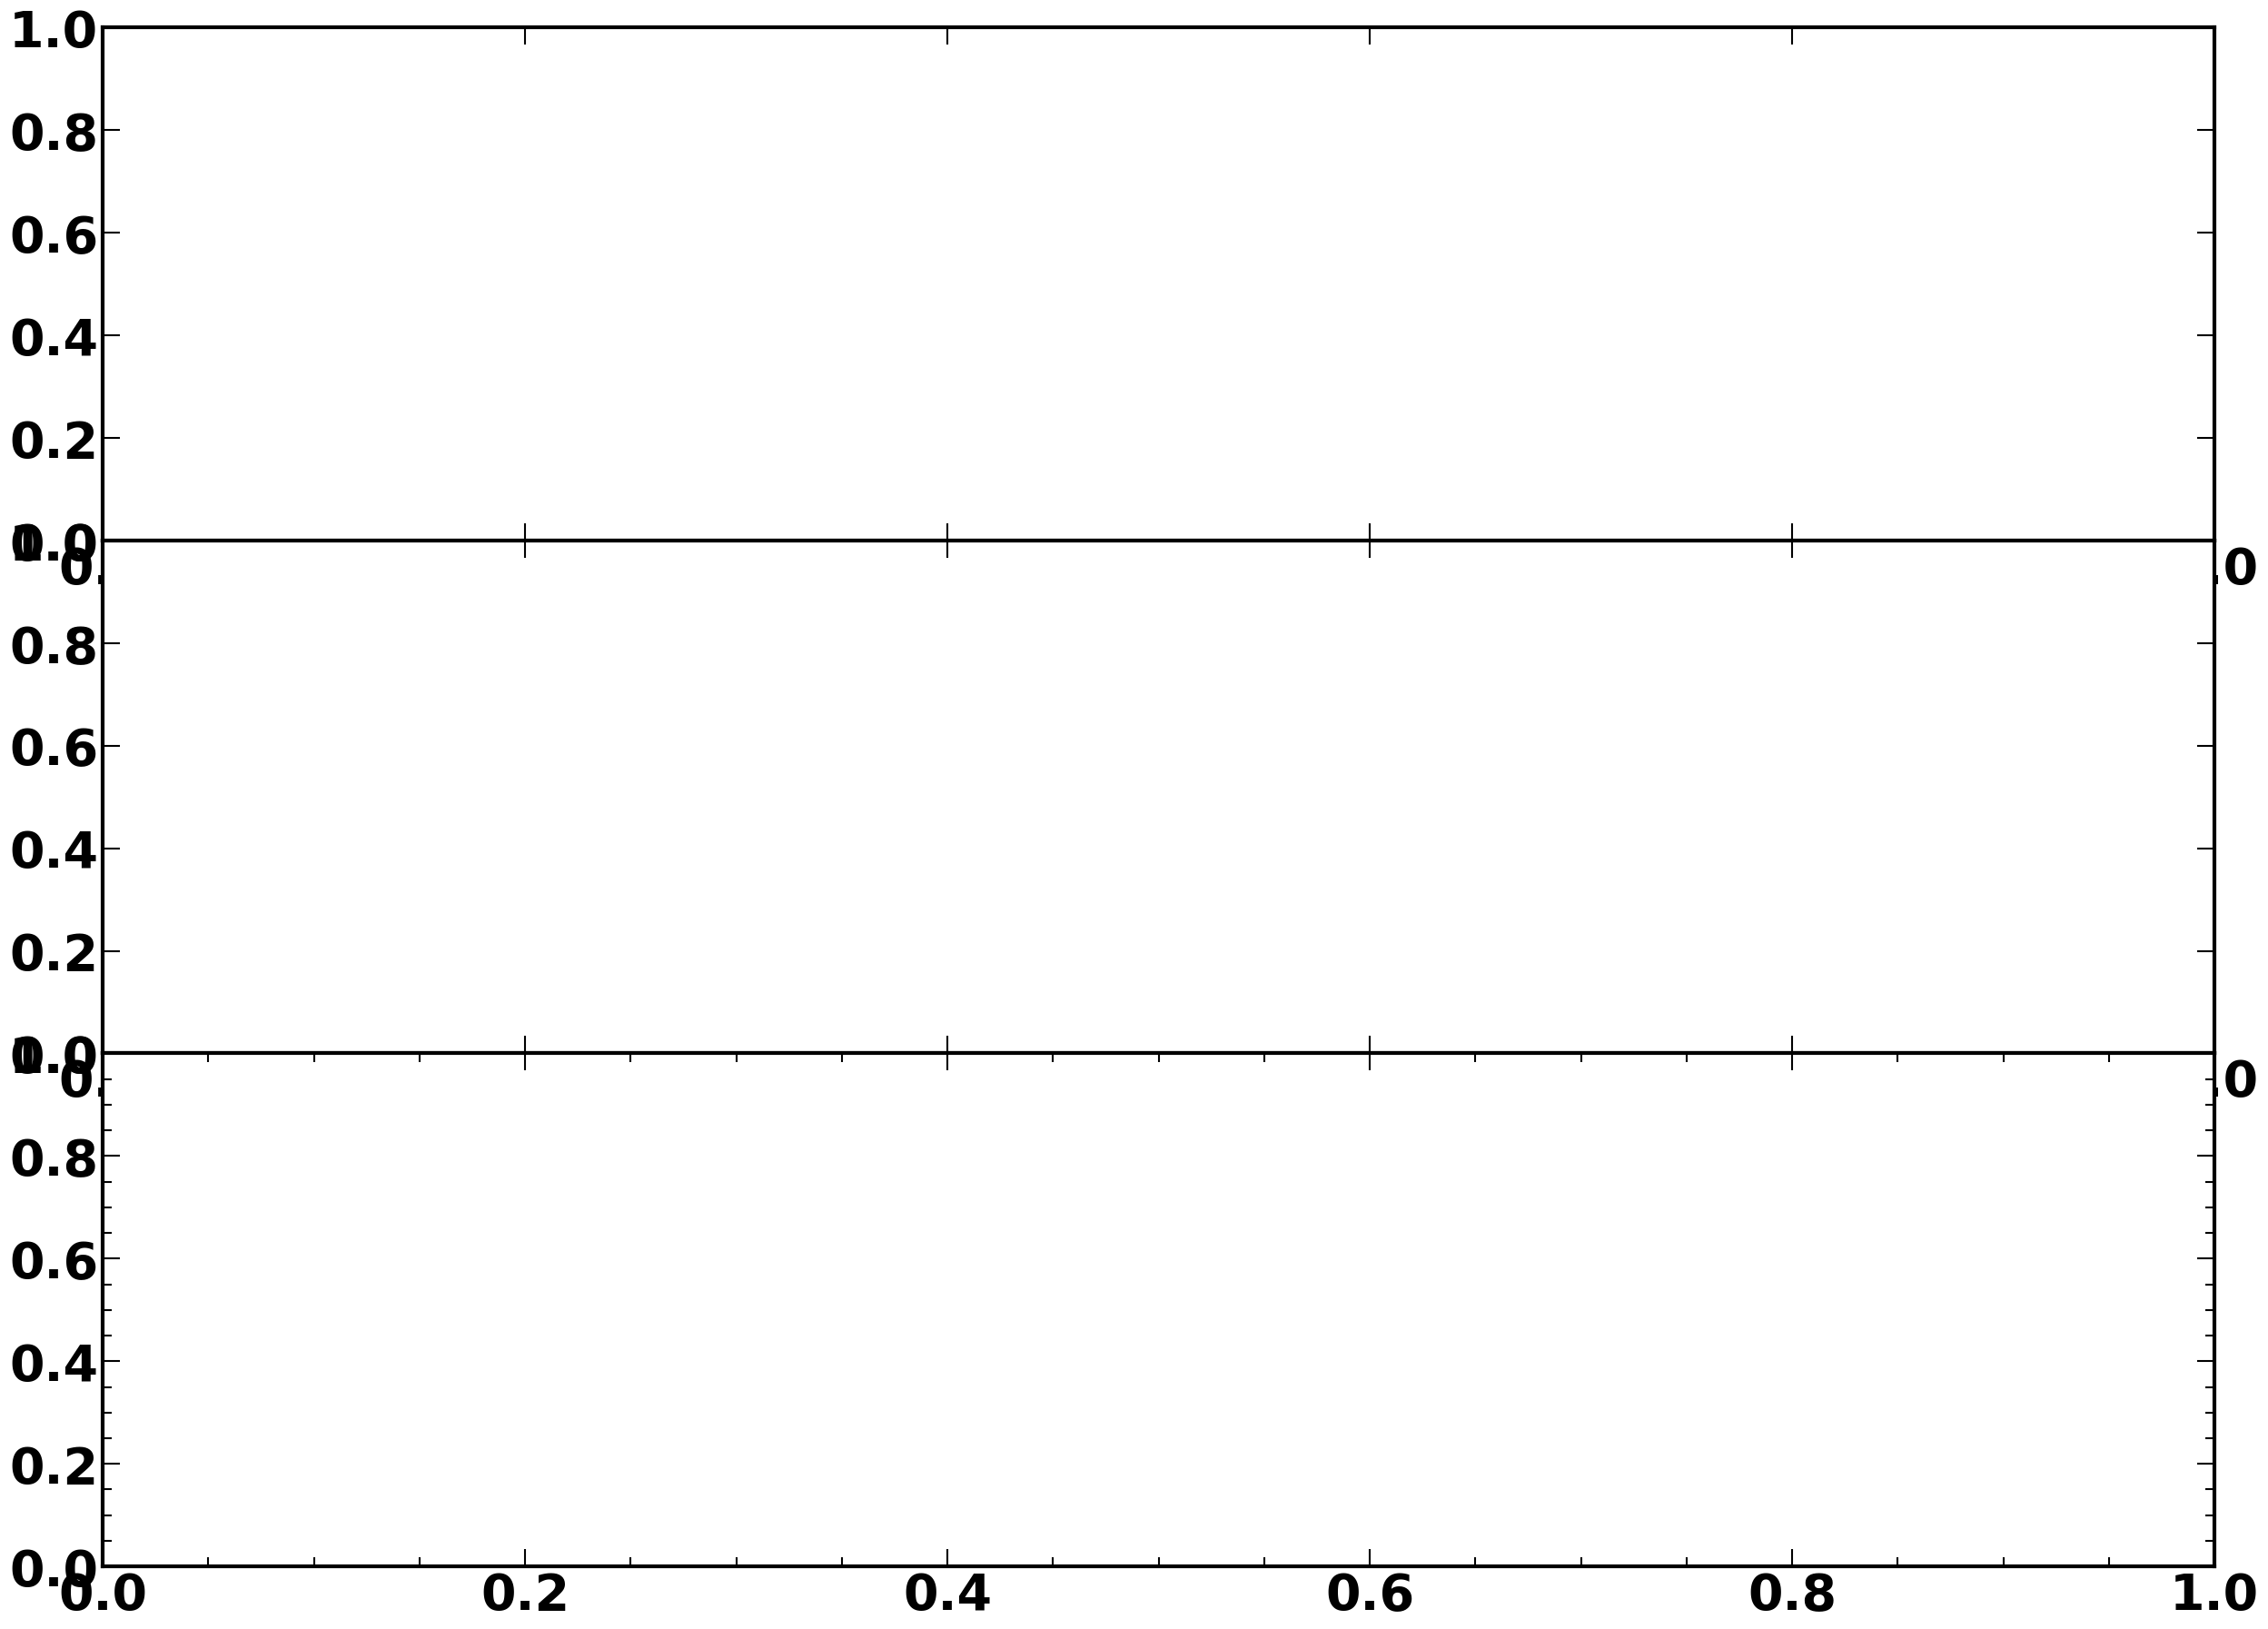

In [58]:
with open('/home/manbing/Documents/Data/data_BeP8/FitParsRange/splines_pars_uncertainty_rigTail.pkl', 'rb') as file:
    loaddic_rigTail_uncertainty = pickle.load(file)
    print(loaddic_rigTail_uncertainty.items())

def plotparsonthis(axn, par, dec):
    plot_graph(fig, axn, graphfitted_TunedBeta0[dec][par], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label='MC')
    #axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 1.0 *graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues , color='grey', alpha=0.6)
    #axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitup[dec][par].yvalues, 1.0 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues , color='grey', alpha=0.6)   
    #axn.fill_between(graph_fitlow[dec][par].xvalues, graph_fitlow[dec][par].yvalues, graph_fitup[dec][par].yvalues , color='grey', alpha=0.6, label=r'Beta Tuning: Data/MC ratio')
    
    #axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.2 * graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues -  1.1 *graph_MaxScaleErr[dec][par].yvalues , color='grey', alpha=0.6)
    
    axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.2 * graph_MaxScaleErr[dec][par].yvalues  , 2.2 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues,  color='grey', alpha=0.5, label=r'Uncertainty from beta')
    
    
    axn.set_ylim([0.85 * min(graphfitted_TunedBeta0[dec][par].yvalues), 1.15 *max(graphfitted_TunedBeta0[dec][par].yvalues)] )
    
    rigTailErr = 2 * loaddic_rigTail_uncertainty[dec][par](np.log(graph_MaxScaleErr[dec][par].xvalues))
    lowPile2 = graph_fitlow[dec][par].yvalues - 2.2 * graph_MaxScaleErr[dec][par].yvalues
    upPile2 = 2.2 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues
    
    axn.fill_between(graph_MaxScaleErr[dec][par].xvalues,  lowPile2 - rigTailErr, lowPile2, color='tab:blue', alpha=0.3, label=r'Total uncertainty')
    axn.fill_between(graph_MaxScaleErr[dec][par].xvalues,  upPile2, upPile2 + rigTailErr, color='tab:blue', alpha=0.3)
    #axn.fill_between(graph_MaxScaleLow[dec][par].xvalues, graph_MaxScaleLow[dec][par].yvalues, graph_MaxScaleUp[dec][par].yvalues , color='blue', alpha=0.3, label=r'uncertainty from MC $\mathrm{\sigma_{\beta}}$ at R>200GV')
    
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.33, 0.33, 0.33]}, figsize=FIGSIZE_Y123)   
set_plot_style(ax1) 
set_plot_style(ax2)  
set_plot_style(ax3)
plt.subplots_adjust(hspace=.0)     

par1 = 'fraccore'
dec = 'NaF'
#plot_graph(fig, ax1, graphfitted_TunedBeta0[dec][par1], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize-5)

#ax1.fill_between(graph_MaxScaleLow[dec][par1].xvalues, graph_MaxScaleLow[dec][par1].yvalues, graph_MaxScaleUp[dec][par1].yvalues, color='blue', alpha=0.3, label='tunning uncertainty 1')
#ax1.fill_between(graph_fitlow[dec][par1].xvalues, graph_fitlow[dec][par1].yvalues, graph_fitup[dec][par1].yvalues*1.003 , color='green', alpha=0.3, label='tunning uncertainty 2')


plotparsonthis(ax1, 'fraccore', dec)
plotparsonthis(ax2, 'sigma_ratio', dec)
plotparsonthis(ax3, 'asy_factor', dec)

#ax1.set_xscale('log')
ax1.legend(loc='lower left', fontsize=28)
#ax2.legend(loc='lower right', fontsize=fontsize1-5)
#ax2.set_xscale('log')
#ax3.set_xscale('log')

ax1.set_ylabel(r'$\mathrm{f_{c}}$', fontsize=fontsize1)
ax2.set_ylabel(r'$\mathrm{\epsilon}$', fontsize=fontsize1)
ax3.set_ylabel(r'$\mathrm{\alpha}$', fontsize=fontsize1)
ax1.set_ylim([0.7, 1.0])
ax2.set_ylim([0.9, 2.32])
ax3.set_ylim([0.6, 1.73])

ax1.sharex(ax3)   
ax2.sharex(ax3)
    
set_plot_style(ax1)                                                                                                                                                                                 
set_plot_style(ax2)  
set_plot_style(ax3) 
plt.subplots_adjust(hspace=.05)
for label in ax1.get_xticklabels():
    label.set_visible(False)
# Repeat the process for ax2
for label in ax2.get_xticklabels():
    label.set_visible(False)

ax3.set_xlabel(r'$\mathrm{E_{k/n} \ (GeV/n)}$', fontsize=fontsize1)
ax1.text(0.05, 0.98, f"{dec}", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                                                                                                                                                                                           
savefig_tofile(fig, plotfile, f'Pars_tailpars_iter0_{dec}', 1)


dict_items([('Tof', {'mean': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbd965d540>, 'sigma': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbcd4a2260>, 'fraccore': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbcd4a35b0>, 'sigma_ratio': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbcd4a1150>, 'asy_factor': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbcd4a3430>}), ('NaF', {'mean': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbcd4a3cd0>, 'sigma': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbcd4a1930>, 'fraccore': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbcd4a3be0>, 'sigma_ratio': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbcd4a21a0>, 'asy_factor': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbcd4a1510>}), ('Agl', {'mean': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7efbcd4a3f70

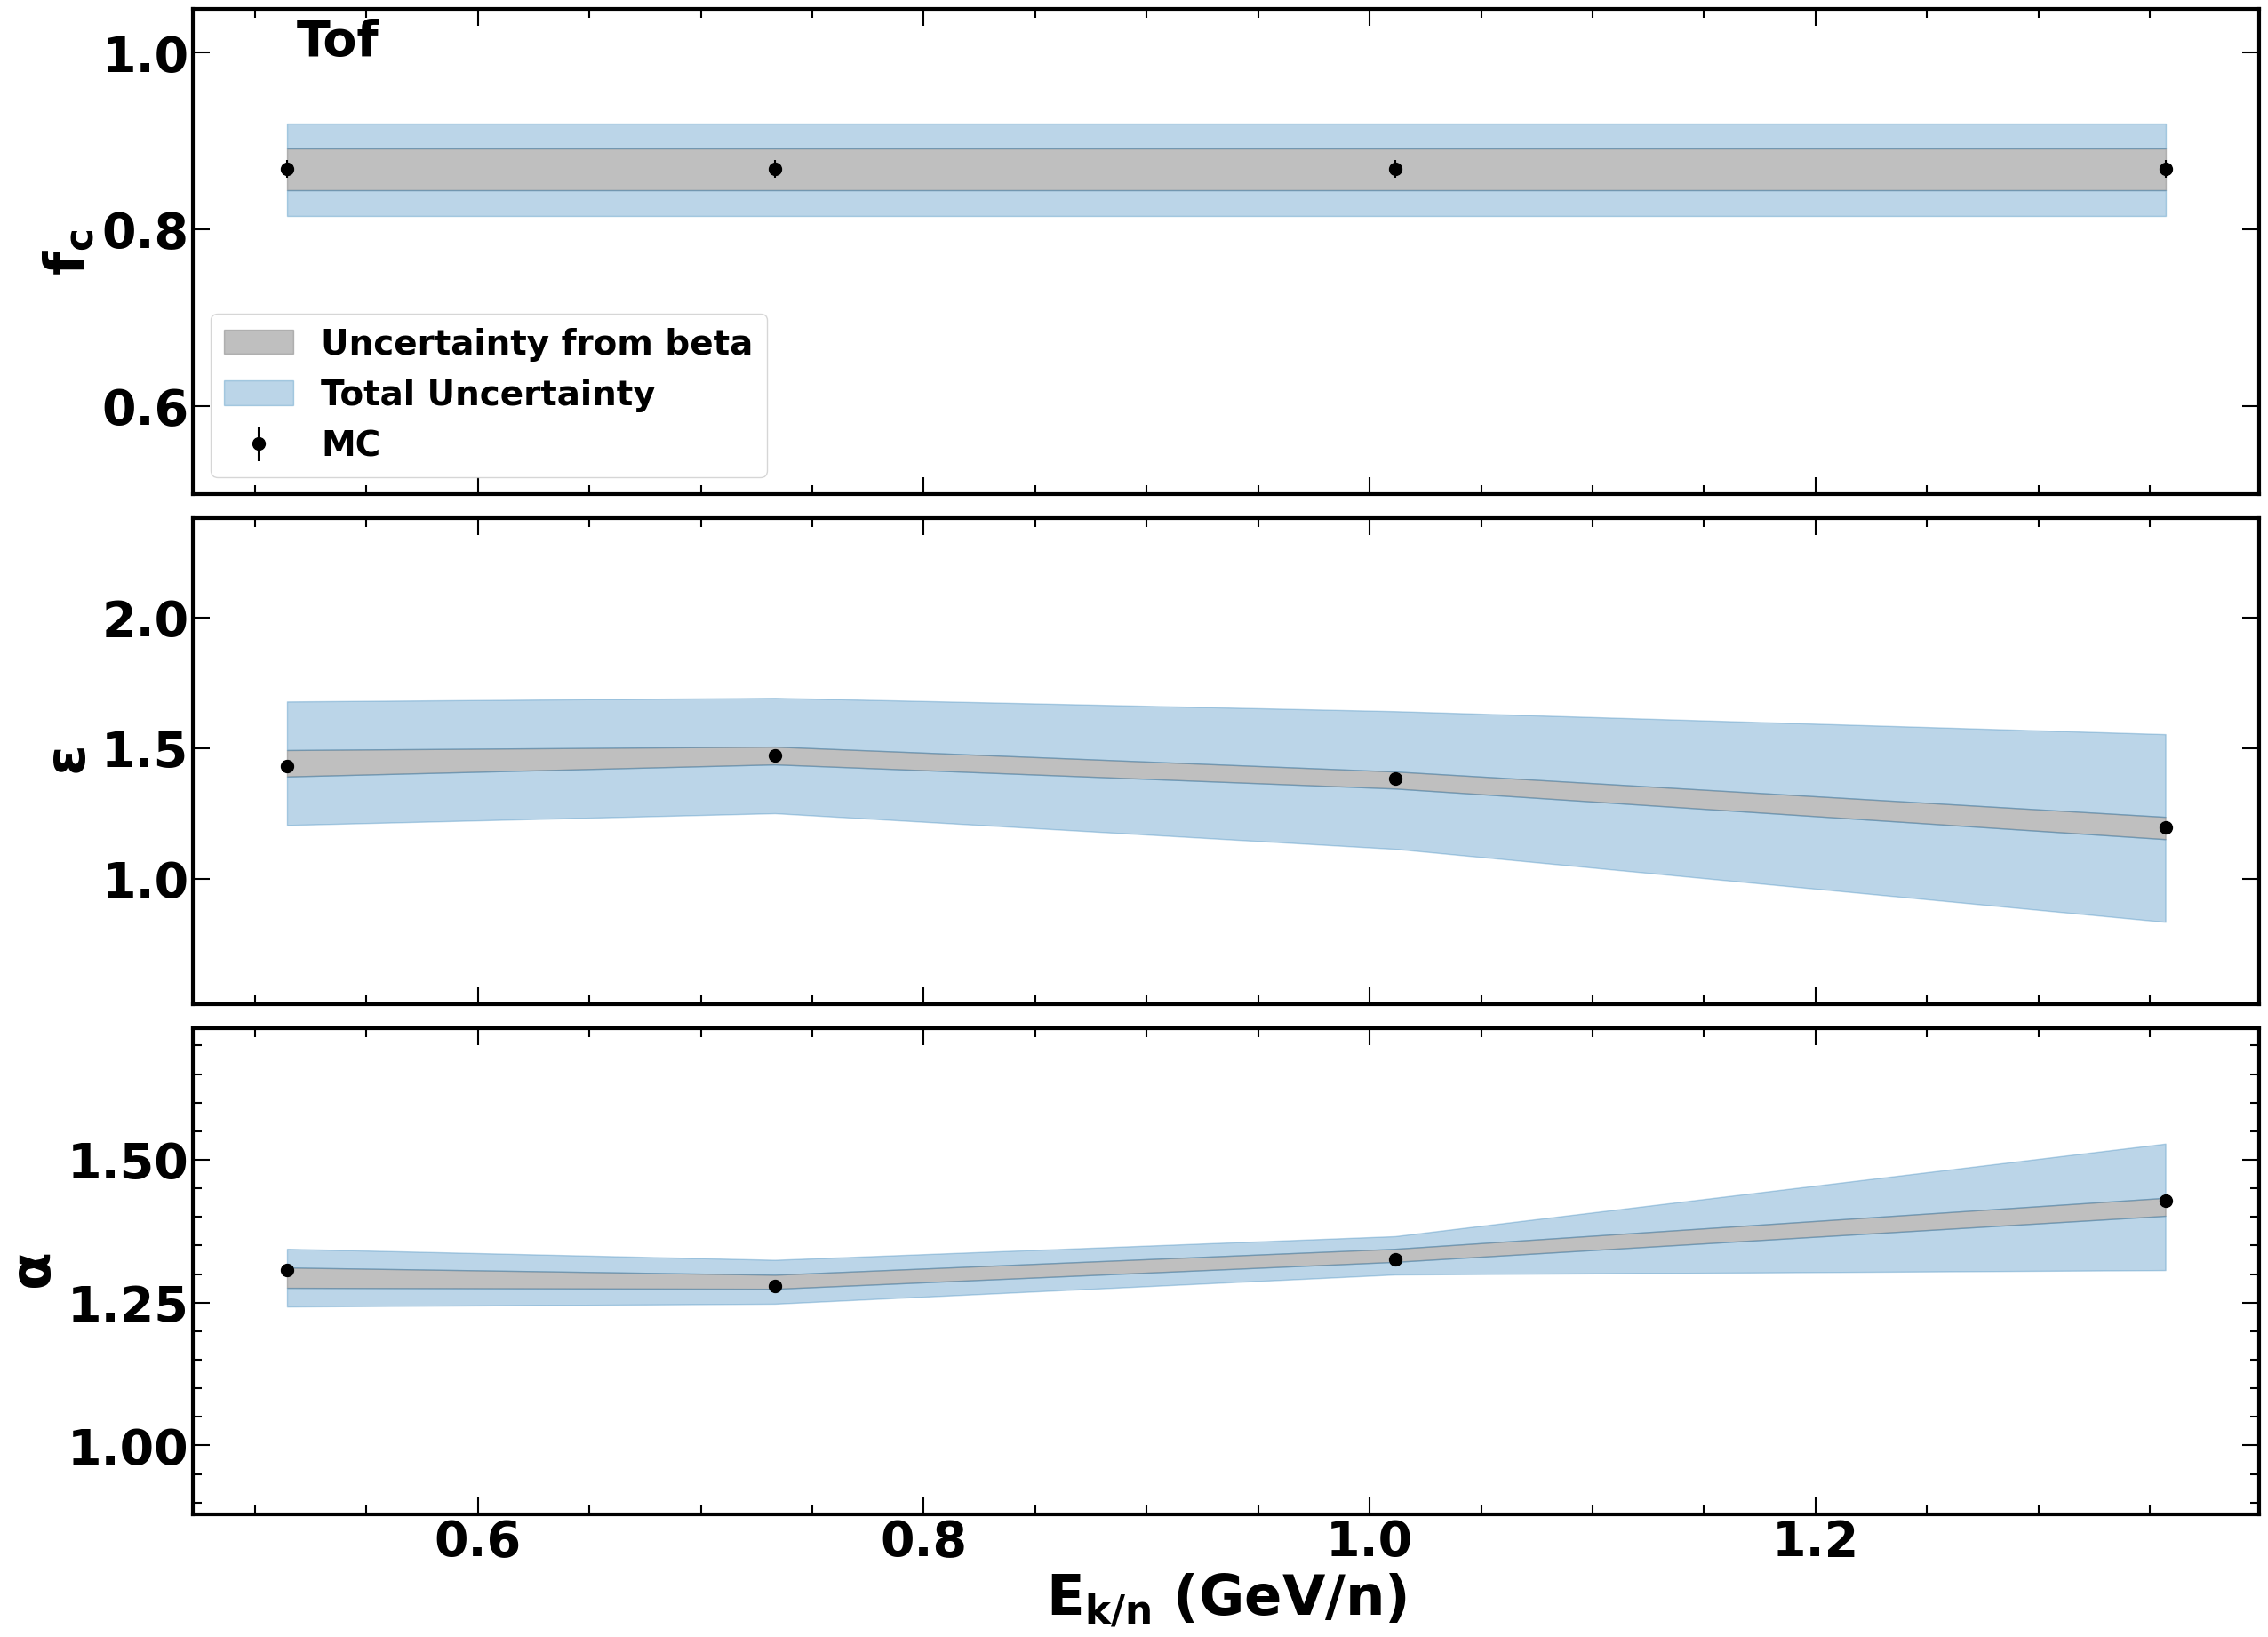

In [55]:
dec = 'Tof'
with open('/home/manbing/Documents/Data/data_BeP8/FitParsRange/splines_pars_uncertainty_rigTail.pkl', 'rb') as file:
    loaddic_rigTail_uncertainty = pickle.load(file)
    print(loaddic_rigTail_uncertainty.items())

def plotparsonthis(axn, par, dec):
    plot_graph(fig, axn, graphfitted_TunedBeta0[dec][par], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label='MC')
    #axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 1.0 *graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues , color='grey', alpha=0.6)
    #axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitup[dec][par].yvalues, 1.0 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues , color='grey', alpha=0.6)   
    #axn.fill_between(graph_fitlow[dec][par].xvalues, graph_fitlow[dec][par].yvalues, graph_fitup[dec][par].yvalues , color='grey', alpha=0.6, label=r'Beta Tuning: Data/MC ratio')
    
    #axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.2 * graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues -  1.1 *graph_MaxScaleErr[dec][par].yvalues , color='grey', alpha=0.6)
    
    axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 1.2 * graph_MaxScaleErr[dec][par].yvalues  , 1.2 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues,  color='grey', alpha=0.5, label=r'Uncertainty from beta')
    
    
    axn.set_ylim([0.85 * min(graphfitted_TunedBeta0[dec][par].yvalues), 1.15 *max(graphfitted_TunedBeta0[dec][par].yvalues)] )
    
    rigTailErr = 2.0 * loaddic_rigTail_uncertainty[dec][par](np.log(graph_MaxScaleErr[dec][par].xvalues))
    lowPile2 = graph_fitlow[dec][par].yvalues - 1.2 * graph_MaxScaleErr[dec][par].yvalues
    upPile2 = 1.2 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues
    
    axn.fill_between(graph_MaxScaleErr[dec][par].xvalues,  lowPile2 - rigTailErr, lowPile2, color='tab:blue', alpha=0.3, label=r'Total Uncertainty')
    axn.fill_between(graph_MaxScaleErr[dec][par].xvalues,  upPile2, upPile2 + rigTailErr, color='tab:blue', alpha=0.3)
    #axn.fill_between(graph_MaxScaleLow[dec][par].xvalues, graph_MaxScaleLow[dec][par].yvalues, graph_MaxScaleUp[dec][par].yvalues , color='blue', alpha=0.3, label=r'uncertainty from MC $\mathrm{\sigma_{\beta}}$ at R>200GV')
    
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.33, 0.33, 0.33]}, figsize=FIGSIZE_Y123)
set_plot_style(ax1) 
set_plot_style(ax2)  
set_plot_style(ax3)
plt.subplots_adjust(hspace=.0)     


plotparsonthis(ax1, 'fraccore', dec)
plotparsonthis(ax2, 'sigma_ratio', dec)
plotparsonthis(ax3, 'asy_factor', dec)

ax1.legend(loc='lower left', fontsize=28)
ax1.set_ylabel(r'$\mathrm{f_{c}}$', fontsize=fontsize1)
ax2.set_ylabel(r'$\mathrm{\epsilon}$', fontsize=fontsize1)
ax3.set_ylabel(r'$\mathrm{\alpha}$', fontsize=fontsize1)
ax1.set_ylim([0.5, 1.05])
ax2.set_ylim([0.52, 2.38])
ax3.set_ylim([0.88, 1.73])

ax1.sharex(ax3)   
ax2.sharex(ax3)
    
set_plot_style(ax1)                                                                                                                                                                                 
set_plot_style(ax2)  
set_plot_style(ax3) 
plt.subplots_adjust(hspace=.05)
for label in ax1.get_xticklabels():
    label.set_visible(False)
# Repeat the process for ax2
for label in ax2.get_xticklabels():
    label.set_visible(False)

ax3.set_xlabel(r'$\mathrm{E_{k/n} \ (GeV/n)}$', fontsize=fontsize1)

ax1.text(0.05, 0.98, f"{dec}", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                                                                                                                                                                                           
print(plotfile)
savefig_tofile(fig, plotfile, f'Pars_tailpars_iter0_{dec}', 1)
